# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!

# Step 0: Business Understanding

### Baseline data/analysis definitions

I will be selecting zip codes based off of average home value using information from Zillow.

A "good" zip code will be determined assuming we are interested in renting these properties. 

Return will be calculated assuming the properties will be purchased outright, monthly rent will be set at 1%, annual cost of maintenance will be 1% of the property value, other expenses will cost an additional 1%, and we are aiming for a 5 year selling strategy.

ROI example is that for a 325,000 home, charging 3,250 a month in rent, 3,250 annual in maintenance, and and additional 3,250 in insurance and taxes:

(3,250 x 12) - 3,250 * 2 = 32,500 / 325,000 = 10% return

General practice states that a return of 6-12% is great, so we would be happy with that.

We'll also be concerned with the general appreciation of the housing market in that zip code, with the intention of seeing at least 10% of increase in the home price over that time frame.


### Potential markets for investigation

According to a US News report in May 2019, these were among the ten cities with the top growth between 2017-2018:

- Provo-Orem, Utah - 2.6% growth, growth is driven by booming tech sector. Salt Lake County has experienced a housing shortage driving people to PO.
- Bend-Redmond, Oregon - 22% growth between 2010 and 2018.
- Boise City, Idaho - 2.9% growth, largely driven by Californian migration
- Greeley, Colorado - 3.0% growth, 24% between 2010 and 2018
- The Villages, Florida - grew by 38% between 2010 and 2018
- Odessa, Texas - 3.2% growth, the oil industry is attracting workers
- Midland, Texas - 4.3% growth, driven mostly by job growth


### Sources

https://www.usnews.com/news/cities/slideshows/new-census-estimates-reveal-the-fastest-growing-cities-in-america?slide=13

https://www.mashvisor.com/blog/average-return-on-investment-us-real-estate-market/

https://www.google.com/search?q=how+much+money+should+a+rental+property+have+in+expenses&rlz=1C1CHBF_enUS858US858&oq=how+much+money+should+a+rental+property+have+in+expen&aqs=chrome.1.69i57j33l2.21976j0j7&sourceid=chrome&ie=UTF-8


# Step 1: Load the Data/Filtering for Chosen Zipcodes

## Dictionaries

Import and use Folium

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns
sns.set(style="whitegrid")

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARMA

import copy
import itertools
import warnings
warnings.filterwarnings("ignore")

import folium
import os
from folium.plugins import MarkerCluster

In [2]:
df = pd.read_csv('zillow_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


## Filtering

The data has 22 years worth of monthly home prices for 14,723 zip codes. Not all of them have all 264 months of data. I know that I will want to avoid years around 2008-09 due to the housing market crash that occurred during the Great Recession.

In [3]:
#Provo-Orem UT
provooremUT = ['84097', '84601', '84604', '84606', '84663', '84057', '84058']

#Bend-Redmond OR
bendOR = ['97701', '97702', '97703', '97756']

#Boise City, ID
boiseID = ['83702', '83703', '83704', '83705', '83706', '83709', '83712', 
           '83713', '83714', '83716']

#Greeley, CO
greeleyCO = ['80543', '80550', '80620', '80631', '80634']

#The Villages, FL
villagesFL = ['32159', '32162', '32163', '34484', '34731', '34785']

#Midlane - Odessa, TX
midlandTX = ['79761', '79762', '79763', '79764', '79765', '79766']

I've preselected 38 zip codes based on the informational research conducted regarding growing cities in the US.

In [4]:
#This adds the data from the preselected zipcodes to a new dataframe, 'data'. 
#We immediately discard all other data and will move forward with this selection. 
#I anticipate finding the top 5 from a selection of 10 after modeling the top 
# 10 from these preselected locations.

a = []
zc = [provooremUT, bendOR, boiseID, greeleyCO, villagesFL, midlandTX]
for b in zc:
    c = [a,b]
    a = list(itertools.chain.from_iterable(c))
    
data = df[df['RegionName'].isin(a)]

In [5]:
#There are no missing values in the data set
data.isna().sum().value_counts()

0    272
dtype: int64

# Step 2: Data Preprocessing

In [6]:
#this function will convert the headers of the dataframe 'data' to the datetime
#format, allowing me to set that header to the index.
def get_datetimes(data):
    return pd.to_datetime(data.columns.values[7:], format='%Y-%m')

In [7]:
get_datetimes(data)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [8]:
#I know that I will only be working with information from 2010 onwards. This
#is because I would like to avoid using the housing market price slump during
#the Great Recession in 2008-2009. I create a dictionary of dataframes that 
#include only lines for the zip codes I want with data from 2010-present (end 
#of dataset)

cols = list(data.columns[7:172])

zips = {'provo': provooremUT, 'bend': bendOR, 'boise': boiseID, 
        'greeley': greeleyCO, 'villages': villagesFL, 'midland': midlandTX}

dict_of_zips = {}
for key in zips:
    key_name = key
    dict_of_zips[key_name] = data[data['RegionName'].isin(zips[key])]
    dict_of_zips[key_name] = dict_of_zips[key_name].set_index(['RegionName'])
    dict_of_zips[key_name] = dict_of_zips[key_name].drop(['RegionID', 'City', 
                                                          'State', 'Metro', 
                                                          'CountyName', 
                                                          'SizeRank'], axis=1)
    dict_of_zips[key_name] = dict_of_zips[key_name].drop(cols, axis=1)

In [9]:
dict_of_zips['provo']

2010-01   2010-02   2010-03   2010-04   2010-05   2010-06  \
RegionName                                                               
84604       269400.0  270100.0  268700.0  264100.0  260700.0  260300.0   
84058       223300.0  224100.0  222500.0  217600.0  213700.0  213500.0   
84057       203900.0  203700.0  202500.0  199300.0  196700.0  196800.0   
84601       186600.0  186600.0  185700.0  183900.0  182500.0  182300.0   
84663       202700.0  202800.0  201100.0  198200.0  197000.0  197700.0   
84606       178000.0  178000.0  176000.0  173100.0  172200.0  173900.0   
84097       240200.0  240800.0  239900.0  237500.0  235100.0  234600.0   

             2010-07   2010-08   2010-09   2010-10  ...  2017-07  2017-08  \
RegionName                                          ...                     
84604       259700.0  258300.0  257700.0  257300.0  ...   342600   342800   
84058       212900.0  209800.0  206200.0  203700.0  ...   275000   279300   
84057       195900.0  194400.0  193800.0  192900.0  ...   265300   267700   
84601       181400.0  179800.0  178900.0  178200.0  ...   243800   246400   
84663       197300.0  196100.0  195700.0  195400.0  ...   268500   272900   
84606       174600.0  174500.0  174000.0  173500.0  ...   246700   247400   
84097       234300.0  232500.0  231000.0  229900.0  ...   299200   301800   

            2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  \
RegionName                                                                  
84604        341300   340700   342500   345400   347500   349400   352200   
84058        281600   282400   283800   286500   288900   291100   294300   
84057        268400   269200   271400   274400   276600   278200   281100   
84601        247700   248500   250500   253300   256100   257500   259200   
84663        275800   277300   279600   282200   284400   286800   290200   
84606        246800   246800   248800   252700   256500   258000   258200   
84097        303800   304600   305700   306900   308900   309500   309600   

            2018-04  
RegionName           
84604        354600  
84058        297500  
84057        284300  
84601        261100  
84663        293200  
84606        258700  
84097        310600  

[7 rows x 100 columns]

# Step 3: EDA and Visualization

In [10]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 
#'plt.gcf().autofmt_xdate()'!

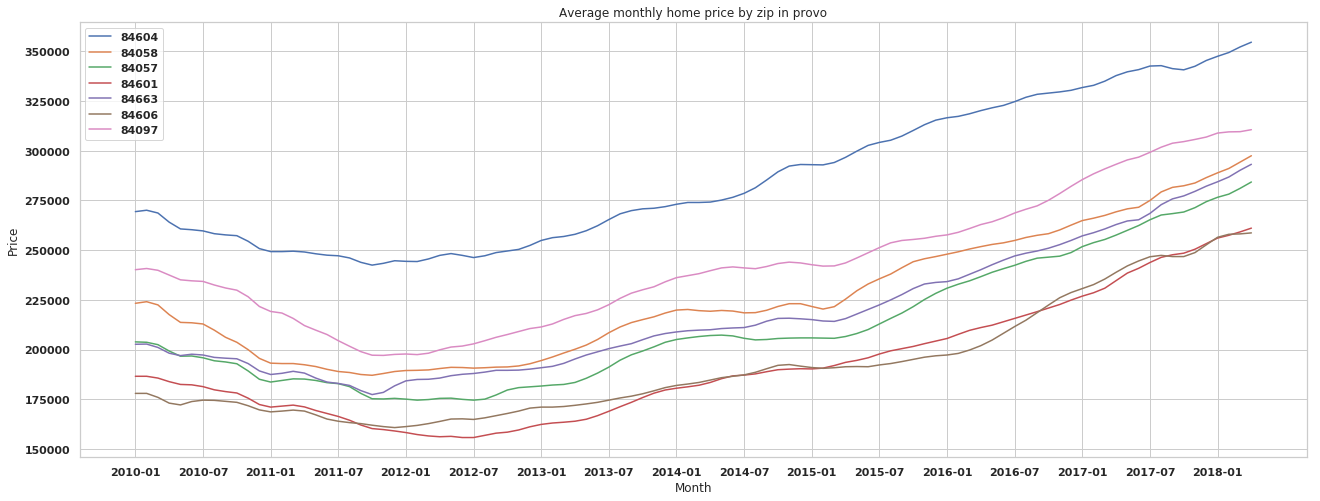

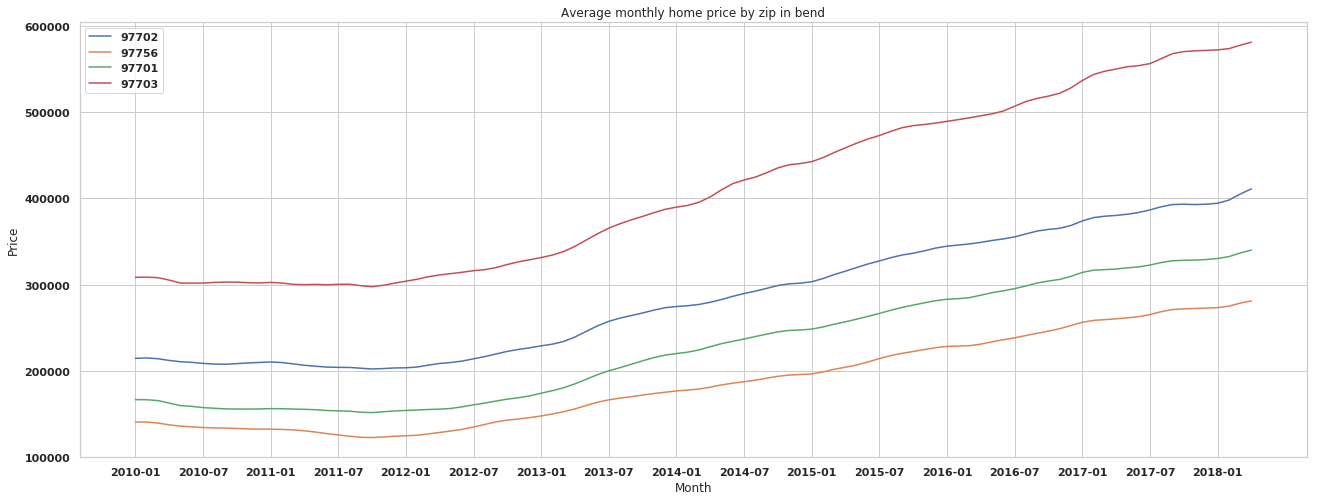

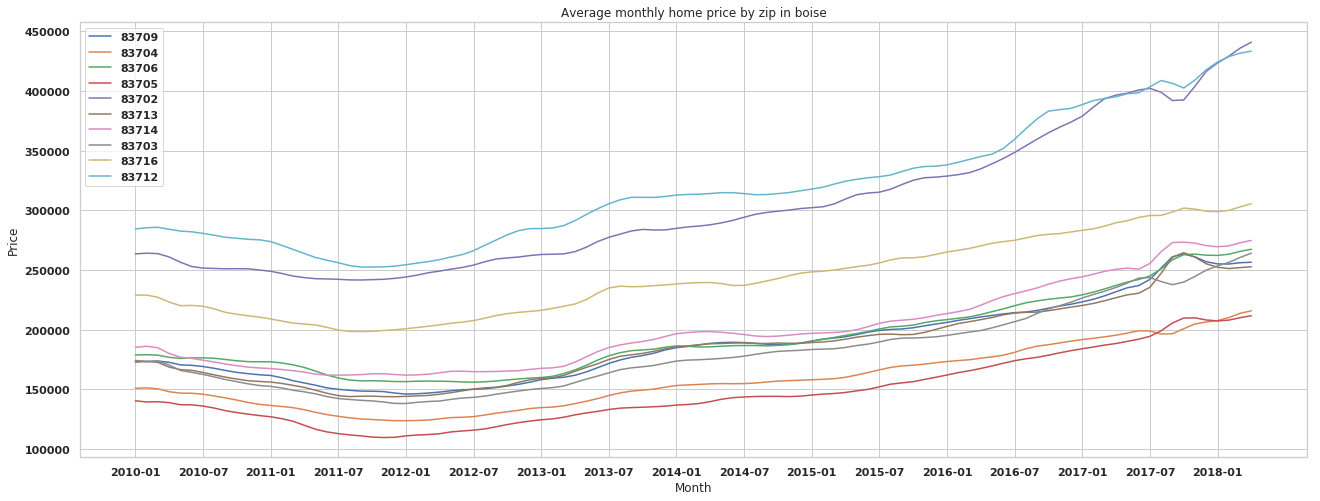

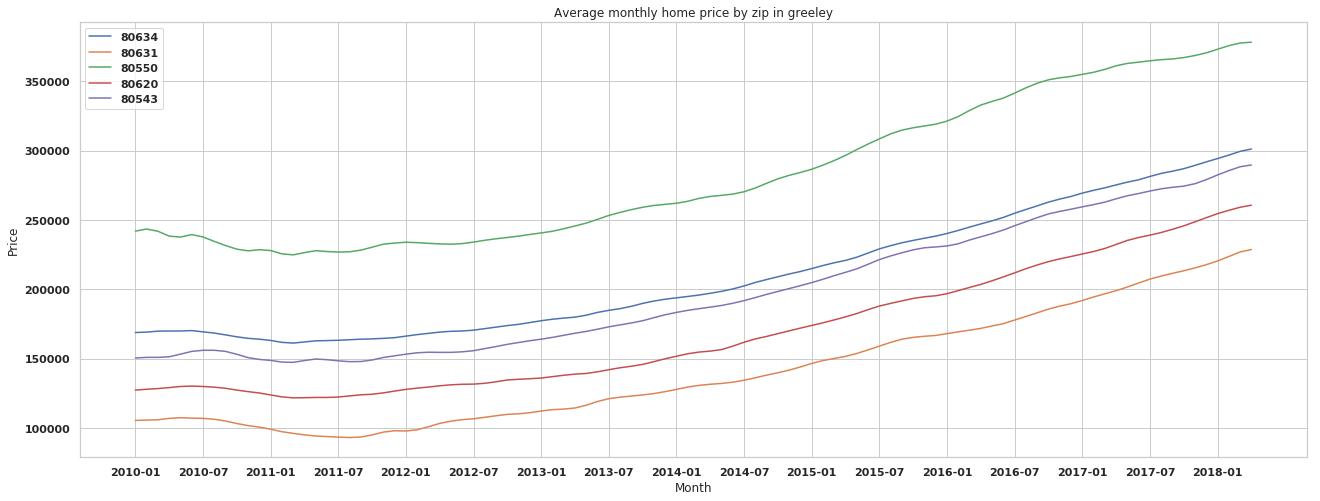

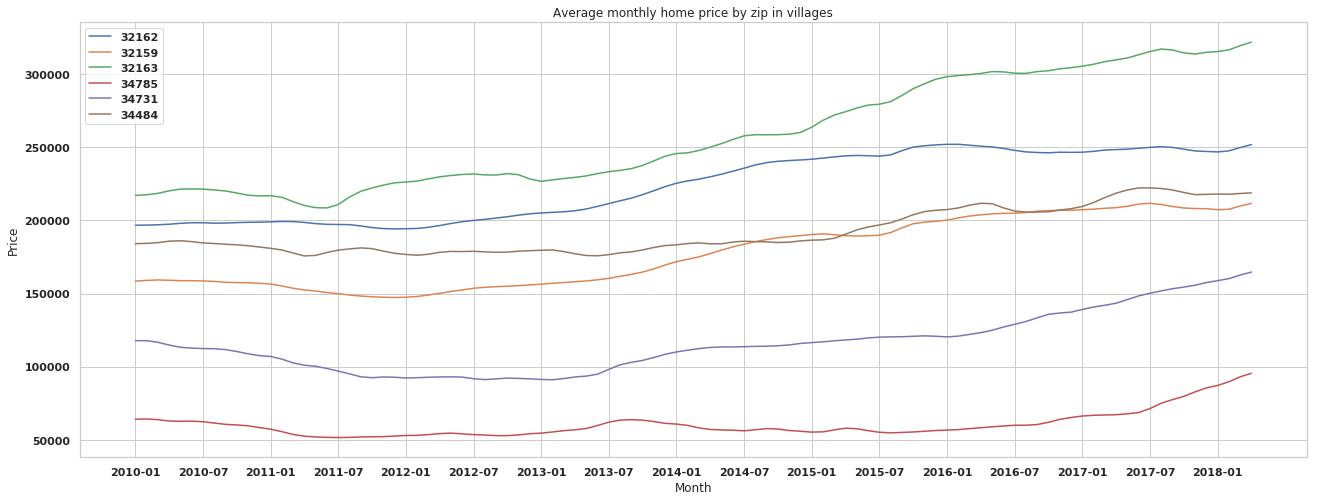

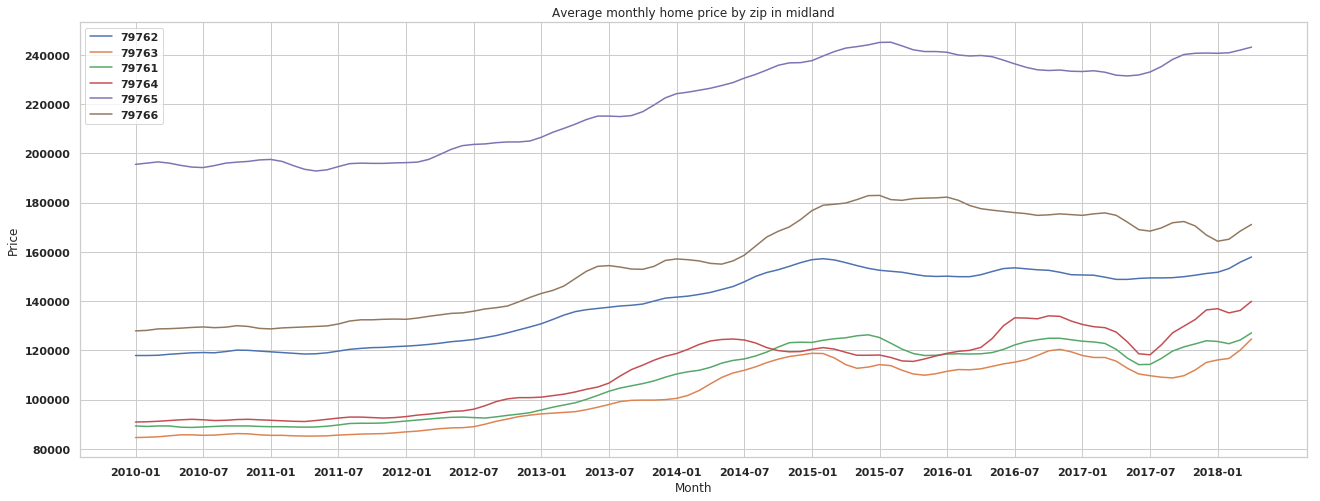

In [11]:
#This code will plot each of the cities over time since 2010.

c = ['green', 'blue', 'red', 'orange', 'yellow', 'pink', 'purple', 'white', 
     'cyan', 'magenta']

for i in dict_of_zips.keys():
   
    graph = {'x': dict_of_zips[i].columns}
    
    z = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
    labs = []
    for j, k in enumerate(dict_of_zips[i].index):
        graph[z[j]] = dict_of_zips[i].loc[k]
        labs.append(graph[z[j]].name)
    
        df = pd.DataFrame(graph)
    
    plt.figure(figsize=(22,8))
    for l, column in enumerate(df.drop('x', axis=1),1):
        plt.plot(df['x'], df[column], label=labs[l-1])
    
    plt.legend(loc='best')
    plt.xticks(df['x'][::6])
    plt.title("Average monthly home price by zip in {}".format(i))
    plt.xlabel('Month')
    plt.ylabel('Price')
    plt.show()

To make a selection, I want to calculate an annual appraisal - based on the avg January price. 

In [12]:
provo = dict_of_zips['provo']
bend = dict_of_zips['bend']
boise = dict_of_zips['boise']
greeley = dict_of_zips['greeley']
villages = dict_of_zips['villages']
midland = dict_of_zips['midland']

In [13]:
#This code will calculate the average annual value of the zip code. I'll use 
#this to select the average home value change YOY. Zips with the largest avg
#annual growth will be selected for modeling.

yrs = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
sets = [provo, bend, boise, greeley, villages, midland]
mos = ['-01', '-02', '-03', '-04', '-05', '-06', '-07', '-08', '-09', '-10', 
       '-11', '-12']

for i in sets:
    for j in yrs:
        k = []
        for l in mos:
            m = j + l
            k.append(i[m])
            annual_avg = sum(k)/12
            i[j] = annual_avg

In [14]:
aa = {'pvo': provo, 'bnd': bend, 'bse': boise, 'gre': greeley, 
      'vil': villages, 'mid': midland}

In [15]:
dict_of_aa = {}

for key in aa:
    key_name = key
    time = []
    for i in aa[key_name].columns[100:]:
        time.append(i)
    dict_of_aa[key_name] = aa[key_name].reset_index()
    dict_of_aa[key_name] = pd.melt(dict_of_aa[key_name], id_vars=['RegionName'], value_vars=time)
    dict_of_aa[key_name] = dict_of_aa[key_name].sort_values(by=['variable', 'value'])
    dict_of_aa[key_name].RegionName = dict_of_aa[key_name].RegionName.astype('str')

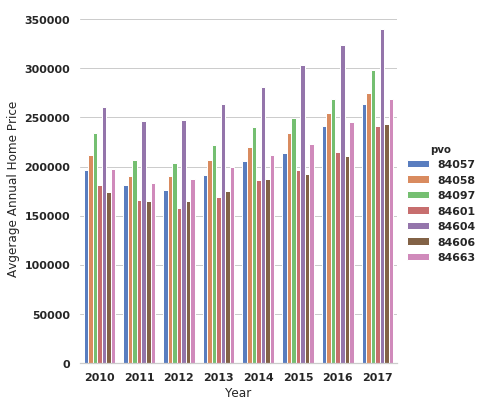

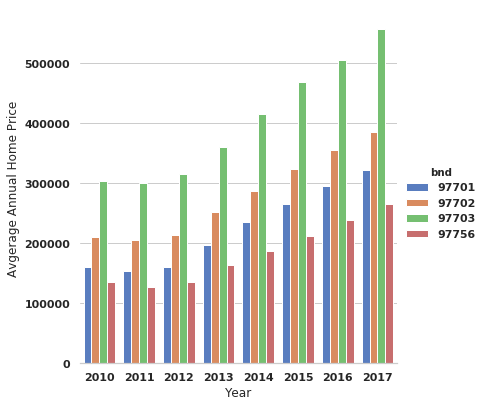

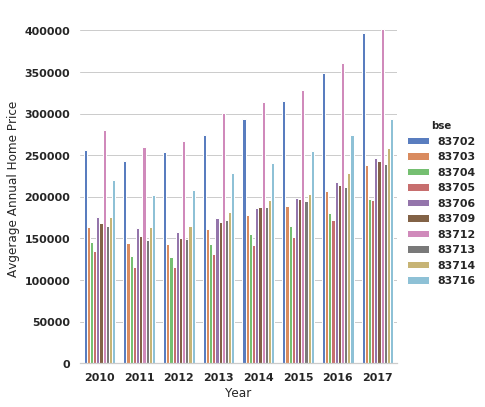

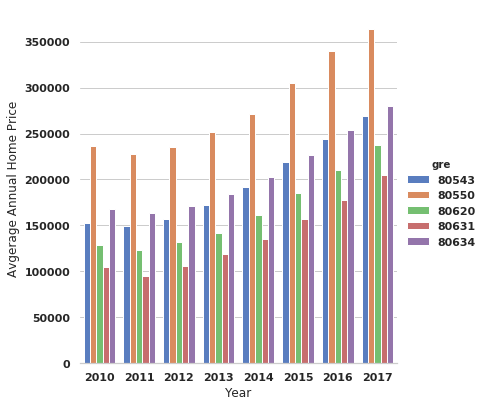

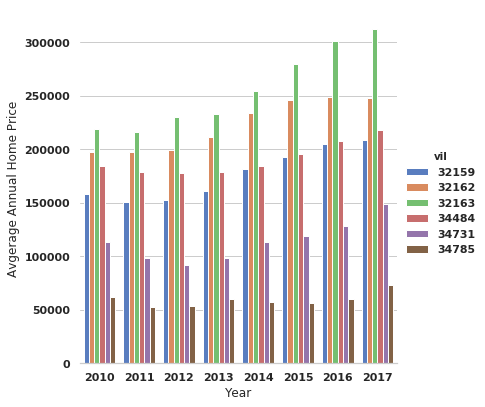

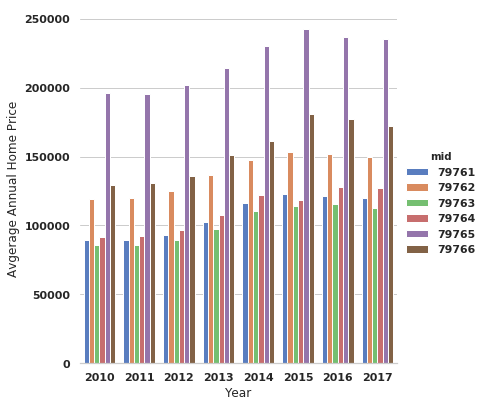

In [16]:
for key in dict_of_aa.keys():
    g = sns.catplot(x="variable", y="value", hue="RegionName", data=dict_of_aa[key], 
                    height=6, kind="bar", palette="muted", legend_out=True)
    g._legend.set_title(key)
    g.despine(left=True)
    g.set_ylabels("Avgerage Annual Home Price")
    g.set_xlabels("Year")

In [17]:
for key in aa:
    growth = ['2010', '2011', '2012', '2013', '2014', '2015', '2016']
    for a, b in enumerate(growth, 2011):
        cols = []
        col = str(a)+'-YOY_Delta'
        aa[key][col] = ((aa[key][str(a)] - aa[key][b]) / aa[key][b])
        cols.append(aa[key][col])

In [18]:
for key in aa.keys():
    aa[key]['Avg_YOY_growth'] = (aa[key]['2011-YOY_Delta'] + aa[key]['2012-YOY_Delta'] + 
                                 aa[key]['2013-YOY_Delta'] + aa[key]['2014-YOY_Delta'] + 
                                 aa[key]['2015-YOY_Delta'] + aa[key]['2016-YOY_Delta'] + 
                                 aa[key]['2017-YOY_Delta']) / 7

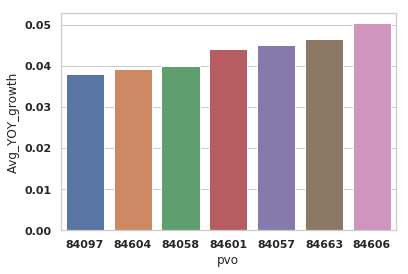

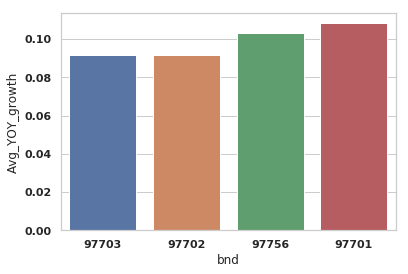

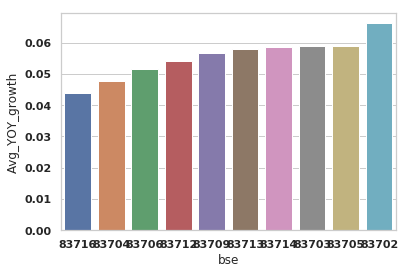

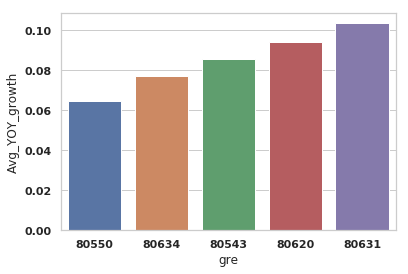

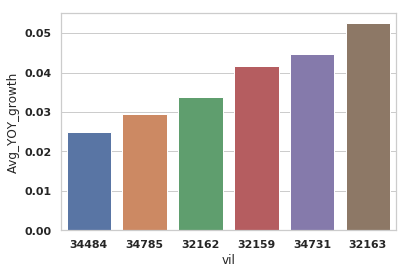

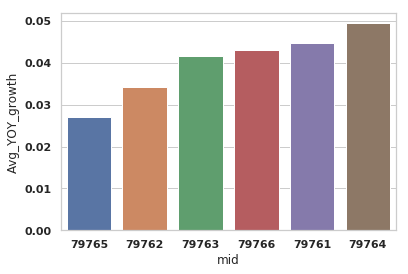

In [19]:
for key in aa.keys():
    h = pd.DataFrame(aa[key]['Avg_YOY_growth'].sort_values())
    sns.barplot(x=h.index, y="Avg_YOY_growth", data=h, order=h.index)
    plt.xlabel(key)
    plt.show()

I will select the top 10 zip codes with the criteria being highest average YOY growth during the period Jan 2010 - Dec 2017, with at least one from each of the areas explored.

That criteria yields the following - 84606 (provo), 97701(bend), 97756(bend), 97702(bend), 83702(boise), 83705(boise), 80631(greeley), 80620(greeley), 32163(villages), 79764(midland)

In [20]:
a = pd.DataFrame({'RegionName': [1], 'Avg_YOY_growth': [1]})
a = a.set_index('RegionName')
for key in aa.keys():
    b = pd.DataFrame(aa[key]['Avg_YOY_growth'])
    a = pd.concat([a,b], axis=0)
    
a = a.drop(1)

# Step 4: Reshape from Wide to Long Format

In [21]:
#This code will "melt" the data, converting it into a format with the datetime
#as an index. This melted format allows me to manipulate the data into 
#visualizations that show how the average housing prices by zip codes change
#over time. I will bring the full data set back in, melt it, and then strip
#it down to the 10 selected zip codes with the data from 2010 to present(end 
#of the data set)

df = pd.read_csv('zillow_data.csv')

time = []
for i in df.columns[7:]:
    time.append(i)
    
data2 = pd.melt(df, id_vars=['RegionName'], value_vars=time)
data2 = data2.sort_values(by=['RegionName', 'variable'])
data2.variable = pd.to_datetime(data2.variable, format='%Y-%m')
data2.set_index('variable', inplace=True)
data2.RegionName = data2.RegionName.astype('str')
data2.head(3)

RegionName     value
variable                       
1996-04-01       1001  113100.0
1996-05-01       1001  112800.0
1996-06-01       1001  112600.0

In [22]:
#a = [84606, 97701, 97756, 97702, 83702, 83705, 80631, 80620, 32163, 79764]

In [23]:
b = ['84606', '97701', '97756', '97702', '83702', '83705', '80631', '80620', '32163', '79764']

zcs = {}
for k, v in enumerate(b):
    zcs['zip_'+b[k]] = data2[data2['RegionName'] == v]
    zcs['zip_'+b[k]] = zcs['zip_'+b[k]]['2010':]
    zcs['zip_'+b[k]] = zcs['zip_'+b[k]].drop(['RegionName'], axis=1)

In [24]:
#A quick preview of the new dfs
zcs['zip_79764'].head()

value
variable           
2010-01-01  90900.0
2010-02-01  91000.0
2010-03-01  91200.0
2010-04-01  91500.0
2010-05-01  91800.0

In [25]:
#This is a QC on the data restructuring
data2[data2['RegionName'] == '79764']['2010':].head()

RegionName    value
variable                      
2010-01-01      79764  90900.0
2010-02-01      79764  91000.0
2010-03-01      79764  91200.0
2010-04-01      79764  91500.0
2010-05-01      79764  91800.0

In [26]:
midland.loc[[79764]]

2010-01  2010-02  2010-03  2010-04  2010-05  2010-06  2010-07  \
RegionName                                                                  
79764       90900.0  91000.0  91200.0  91500.0  91800.0  92000.0  91800.0   

            2010-08  2010-09  2010-10  ...           2016      2017  \
RegionName                             ...                            
79764       91500.0  91600.0  91900.0  ...  127766.666667  127075.0   

            2011-YOY_Delta  2012-YOY_Delta  2013-YOY_Delta  2014-YOY_Delta  \
RegionName                                                                   
79764              0.00546        0.050498        0.114145        0.129978   

            2015-YOY_Delta  2016-YOY_Delta  2017-YOY_Delta  Avg_YOY_growth  
RegionName                                                                  
79764            -0.029834        0.081394       -0.005414        0.049461  

[1 rows x 116 columns]

# Step 5: ARIMA Modeling

The next portion of code will be designing models to predict future values of the housing prices in the selected zip codes. I will ultimately use a SARIMA model, or Seasonal AutoRegressive Integrated Moving Average model. The SARIMA model will adjust for seasonal trends present in the data and also allow for finding the relevant order of lags for the previous value (AR(p) term), the level of non-seasonal differencing that ought to be conducted (I(d) term), and finally it will provide the MA(q) error term.

I will use one zip code, 84606, to show knowledge of the process I am working through. Following the test, I will utilize functions in Python to expedite the process.

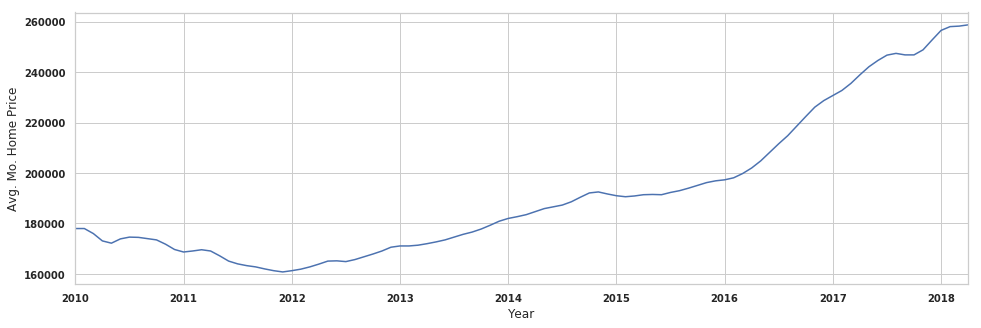

In [168]:
#First, we plot the time series
ax = zcs['zip_84606'].plot(figsize=(16,5), linewidth=1.5, fontsize=10, legend=False)
ax.set_xlabel('Year')
ax.set_ylabel('Avg. Mo. Home Price');

Not surprisingly, it appears that housing prices rise over time. The rate at which the housing prices are increasing is changing. This points to data that is not stationary.

The below function will use the Dickey-Fuller test to check for stationarity in a TS model. It will also plot the rolling mean and rolling standard deviation in one plot.

In [28]:
def stationarity_check(data):
    
    # Import adfuller to perform the Dickey Fuller test
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    rolmean = data.rolling(window = 8, center = False).mean()
    rolstd = data.rolling(window = 8, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(data['value']) # change the pricing column as required 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',
                                             '#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return None

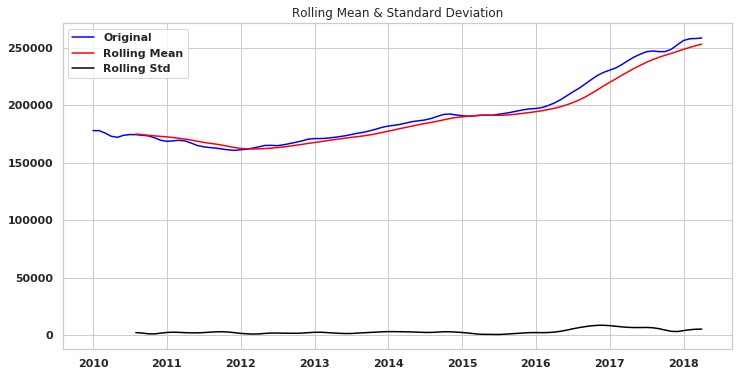

Results of Dickey-Fuller Test:
Test Statistic                  0.793392
p-value                         0.991529
#Lags Used                      4.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


In [29]:
stationarity_check(zcs['zip_84606'])

Looking at the plot of the zip code, we can see three things.
- The mean (red line) increases over time.
- The variance appears relatively stable over time - there are not large waves in the blue line.
- The covariance does not appear to be a function of time.

The increasing mean could point to the TS not being stationary.

It would appear that the trend is upward and relatively linear with stable variance. It also appears there is a growing periodic trend in the mean price on an annual basis.

The test statistic is not less than the critical value and the p-value is not significant at the 5% level, meaning we fail to reject the null hypothesis that the time series is stationary. This means we will need to adjust for the trends present in the data.

I will decompose the data to extract the trend, seasonality, and variance from the data.

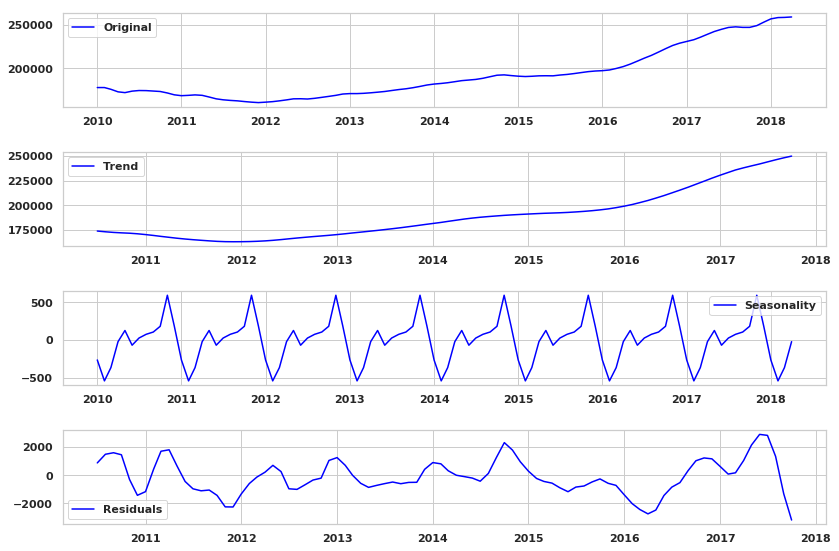

In [30]:
decomposition = seasonal_decompose(zcs['zip_84606'])

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(zcs['zip_84606'], label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

We see an upward, somewhat linear trend. There is slight seasonality, but notice the slightness of the y-axis - +- 500 on home prices in the hundreds of thousands. The residuals indicate increased variability in value in more recent years.

I'll be differencing the data once to account for the trend, so the non-seasonal trend term will be d = 1.

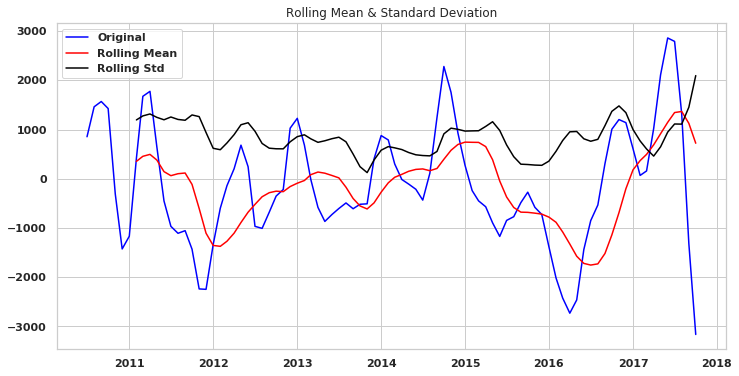

Results of Dickey-Fuller Test:
Test Statistic                 -3.783827
p-value                         0.003077
#Lags Used                      2.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64


In [31]:
ts_decompose = residual
ts_decompose.dropna(inplace=True)

# Check stationarity
stationarity_check(ts_decompose)

While there is a trend, there is little seasonality in the data. This would suggest that the data can be differenced for the non-seasonal d term to negate the trend, but we will not have to difference it again to remove any seasonal difference. The variance remains fairly stable, so I will elect to not transform the data with a log, exponential, or rolling mean subtracted transformation.

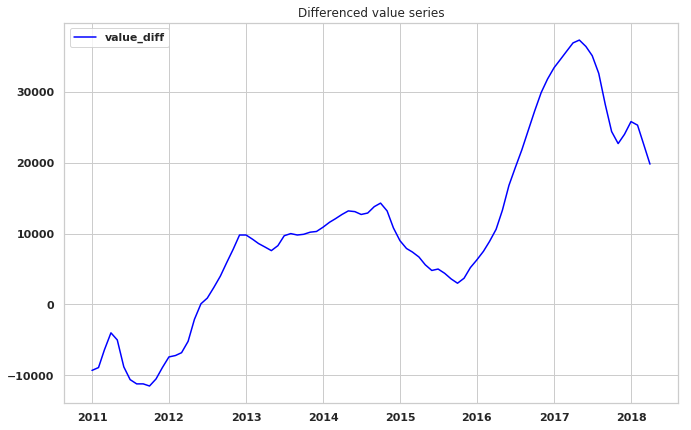

In [32]:
#Here I take the first difference of the data and then plot the ACF and PACF 
#curves to inspect potential lag

zip_diff = zcs['zip_84606'].diff(periods=12).dropna()
fig = plt.figure(figsize=(11,7))
plt.plot(zip_diff, color='blue',label='value_diff')
plt.legend(loc='best')
plt.title('Differenced value series')
plt.show(block=False)

By differencing the data by 12 months, we remove the annual trend of the data. Therefore, we are comparing January prices in one year to January prices of the next, so instead of comparing how one month prior might impact the current month price, we are comparing one year to the next. Therefore we see a true fluctuation of a local housing market over time. There is no apparent seasonality in the differenced data.

The graph shows a large annual growth during the 2017 calendar year, with home price averages increasing as much as ~$37,500 over the same month one year prior. All values above the 0 line indicate higher prices in the listed year than their standing 12 months before.

There is still an upward trend to the data, so I will take the first difference of the first difference, producing a D term of 1 for the seasonal trend term.

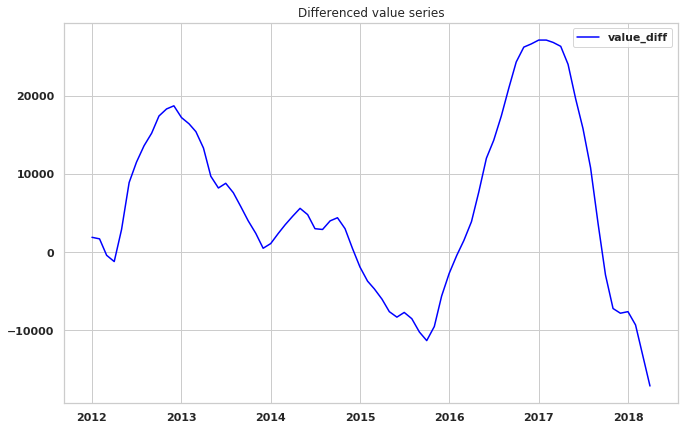

In [33]:
zip_diff_diff = zip_diff.diff(periods=12).dropna()
fig = plt.figure(figsize=(11,7))
plt.plot(zip_diff_diff, color='blue',label='value_diff')
plt.legend(loc='best')
plt.title('Differenced value series')
plt.show(block=False)

By differencing the data a second time, I have removed the seasonal trend from the data.

I will now explore the autocorrelation and partial autocorrelation for the differenced data.

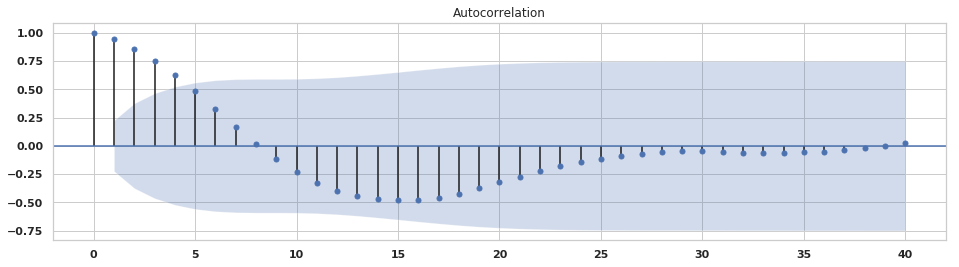

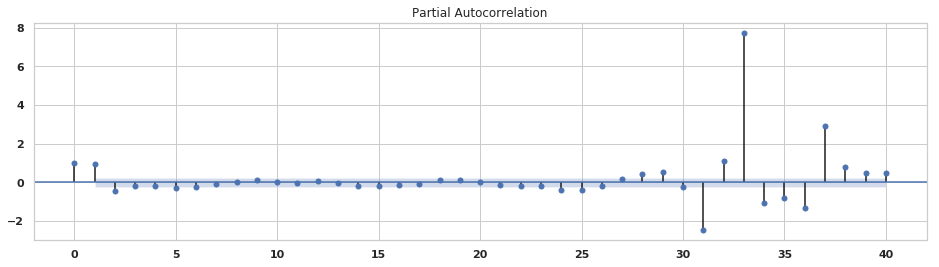

In [34]:
fig, ax = plt.subplots(figsize=(16,4))
plot_acf(zip_diff_diff,ax=ax, lags=40)

fig, ax = plt.subplots(figsize=(16,4))
plot_pacf(zip_diff_diff,ax=ax, lags=40);

Looking at the ACF, there are significant spikes in the closer lag terms, but there are no spikes in the seasonal lags. That might suggest that we have no seasonal MA terms, but we might have non-seasonal moving average terms significant up to a lag of 4 periods. Looking at the PACF, we see significance in the first and second lag terms and can confirm there are no significant seasonal autocorrelation terms.

We would say that the p,q terms of the ARMA(p,q) model could be AR(0-2)(based on the number of significant terms shown in the the PACF graph), and MA(0-4)(based on the number of significant terms present in the ACF chart).

In [35]:
# create a set of sarima configs to try
def sarima_configs(p,d,q,P,D,Q,s):
    models = list()
    # define config lists
    p_params = list(range(0, p+1))
    d_params = list(range(0, d+1))
    q_params = list(range(0, q+1))
    P_params = list(range(0, P+1))
    D_params = list(range(0, D+1))
    Q_params = list(range(0, Q+1))
    m_params = [s]
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            for m in m_params:
                                cfg = [(p,d,q), (P,D,Q,m)]
                                models.append(cfg)
    return models

In [36]:
#My inital model constraints will be non-seasonal AR terms of 0-2, d=1, 
#non-seasonal MA terms of 0-3, seasonal AR terms 0, D=1, seasonal MA terms 0
#and s=12
models = sarima_configs(2,1,3,1,1,1,12)

In [37]:
#This code will iterate through all of the possible combinations the above
#code put together, and output the AIC score of a SARIMA model with the given 
#order.

ans = []
for i in models:
    try:
        mod = sm.tsa.statespace.SARIMAX(zcs['zip_84606'],
                                        order=i[0],
                                        seasonal_order=i[1],
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        output = mod.fit()
        ans.append([i[0], i[1], output.aic])
        print('ARIMA {} x {}12 : AIC Calculated ={}'.format(i[0], i[1], output.aic))
    except:
        continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =2693.889887294655
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =2320.8167339851857
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =1941.3260947709816
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =1683.0951254914544
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1910.1805944937055
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1853.8125243841569
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =1652.663845360652
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =2120.6749158399944
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =2598.584793968643
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =2267.6126594947714
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =1851.408806531162
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =2426.5265706372643
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =2474.539486801415
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =2391.601529478459
ARIMA (0, 0,

ARIMA (1, 1, 2) x (1, 0, 0, 12)12 : AIC Calculated =1332.9488174483133
ARIMA (1, 1, 2) x (1, 0, 1, 12)12 : AIC Calculated =1304.5097500511488
ARIMA (1, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =1191.7447706422922
ARIMA (1, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =1148.4199244935535
ARIMA (1, 1, 3) x (0, 0, 0, 12)12 : AIC Calculated =1484.167602588693
ARIMA (1, 1, 3) x (0, 0, 1, 12)12 : AIC Calculated =1289.9185758628425
ARIMA (1, 1, 3) x (0, 1, 0, 12)12 : AIC Calculated =1337.0313074795565
ARIMA (1, 1, 3) x (0, 1, 1, 12)12 : AIC Calculated =1137.5785442732895
ARIMA (1, 1, 3) x (1, 0, 0, 12)12 : AIC Calculated =1326.5269084992115
ARIMA (1, 1, 3) x (1, 0, 1, 12)12 : AIC Calculated =1289.3089183024097
ARIMA (1, 1, 3) x (1, 1, 0, 12)12 : AIC Calculated =1192.630699237005
ARIMA (1, 1, 3) x (1, 1, 1, 12)12 : AIC Calculated =1142.0517921857522
ARIMA (2, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =1586.6194750007742
ARIMA (2, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =1503.4114009864961
ARIMA (2

In [38]:
#I've iterated through the combinations and been able to select the lowest 5 
#AIC scores. By selecting the second lowest, I am able to reduce the order
#count by 1 by removing the seasonal Autoregressive lag.
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.sort_values('aic').head()

pdq           pdqs          aic
63   (0, 1, 3)  (1, 1, 1, 12)  1135.721731
59   (0, 1, 3)  (0, 1, 1, 12)  1136.642961
123  (1, 1, 3)  (0, 1, 1, 12)  1137.578544
187  (2, 1, 3)  (0, 1, 1, 12)  1140.273084
191  (2, 1, 3)  (1, 1, 1, 12)  1141.458602

In [39]:
#I'll plug in the selected parameters to a model and receive an output of 
#non-seasonal MA coefficients which all have significant p-values.
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(zcs['zip_84606'],
                                order=(0, 1, 3),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.4654      0.097     15.058      0.000       1.275       1.656
ma.L2          1.0464      0.150      6.991      0.000       0.753       1.340
ma.L3          0.3621      0.104      3.482      0.000       0.158       0.566
ma.S.L12      -0.2211      0.069     -3.197      0.001      -0.357      -0.086
sigma2      4.247e+05   7.04e+04      6.037      0.000    2.87e+05    5.63e+05


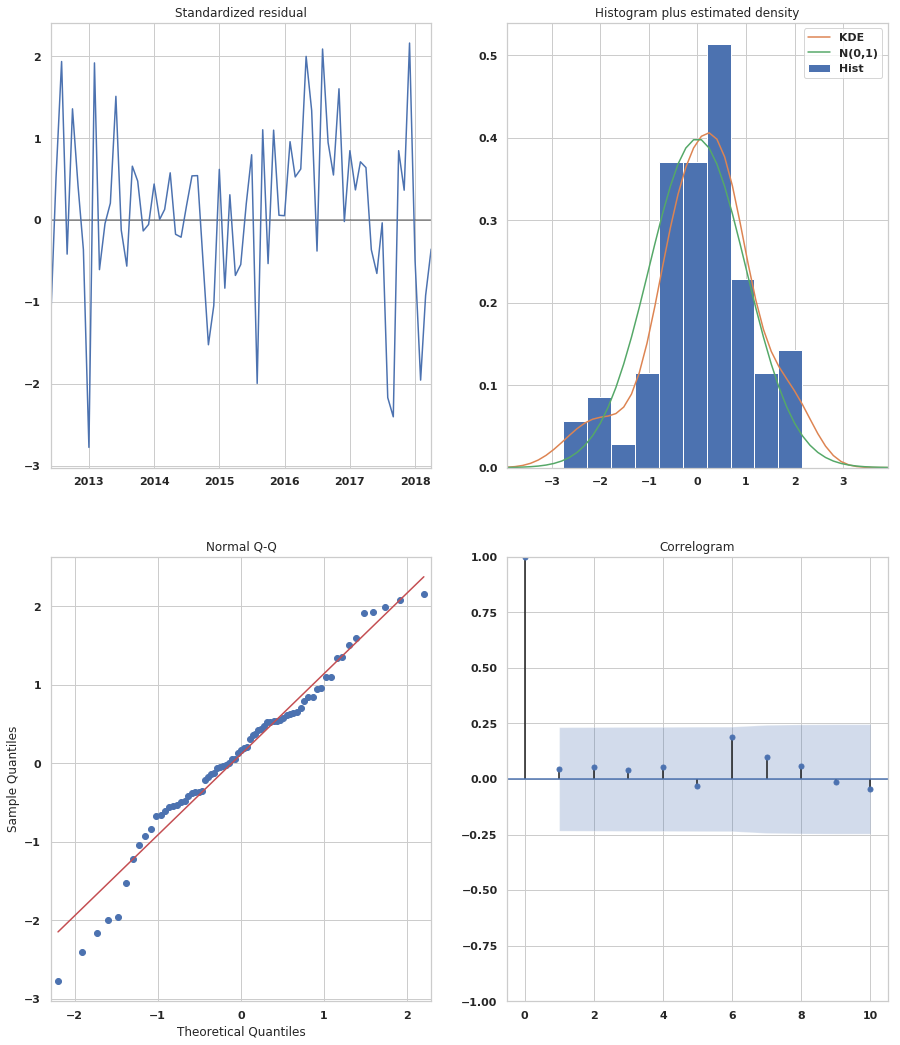

In [40]:
#This code will produce the model diagnostics. This is run to ensure none of the 
#model assumptions were violated.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

- The residuals over time plot shows little to no seasonality, which confirms the correlogram showing the residuals have low correlation with lagged versions of themselves.
- The KDE plot is fairly close to the normal distribution with mean = 0, meaning that residuals maintain a normal distribution.
- The QQ plot shows the residuals maintain fairly normal distribution along a linear trend.

Now I need to validate the model and see if predictions will come close to real data. I'll use the last 40 months of data as a test set of data for validation.

In [41]:
pred = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_conf = pred.conf_int()

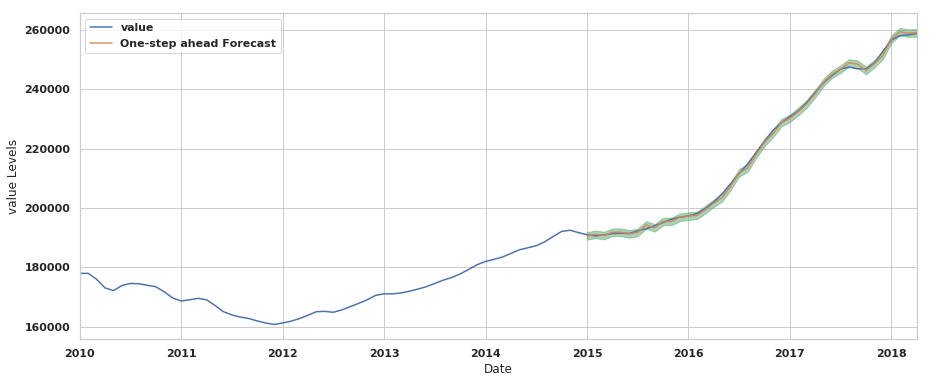

In [42]:
rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = zcs['zip_84606'].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('value Levels')
plt.legend()

plt.show()

The above graph shows a pretty close fit! The one-step ahead forecast sits almost perfectly on the real data. We'll also take the Mean Squared Error to determine the average error of the test terms.

In [43]:
value_forecasted = pred.predicted_mean
value_truth = zcs['zip_84606']['2015-01-01':]['value']

# Compute the mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 512197.82


In [44]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

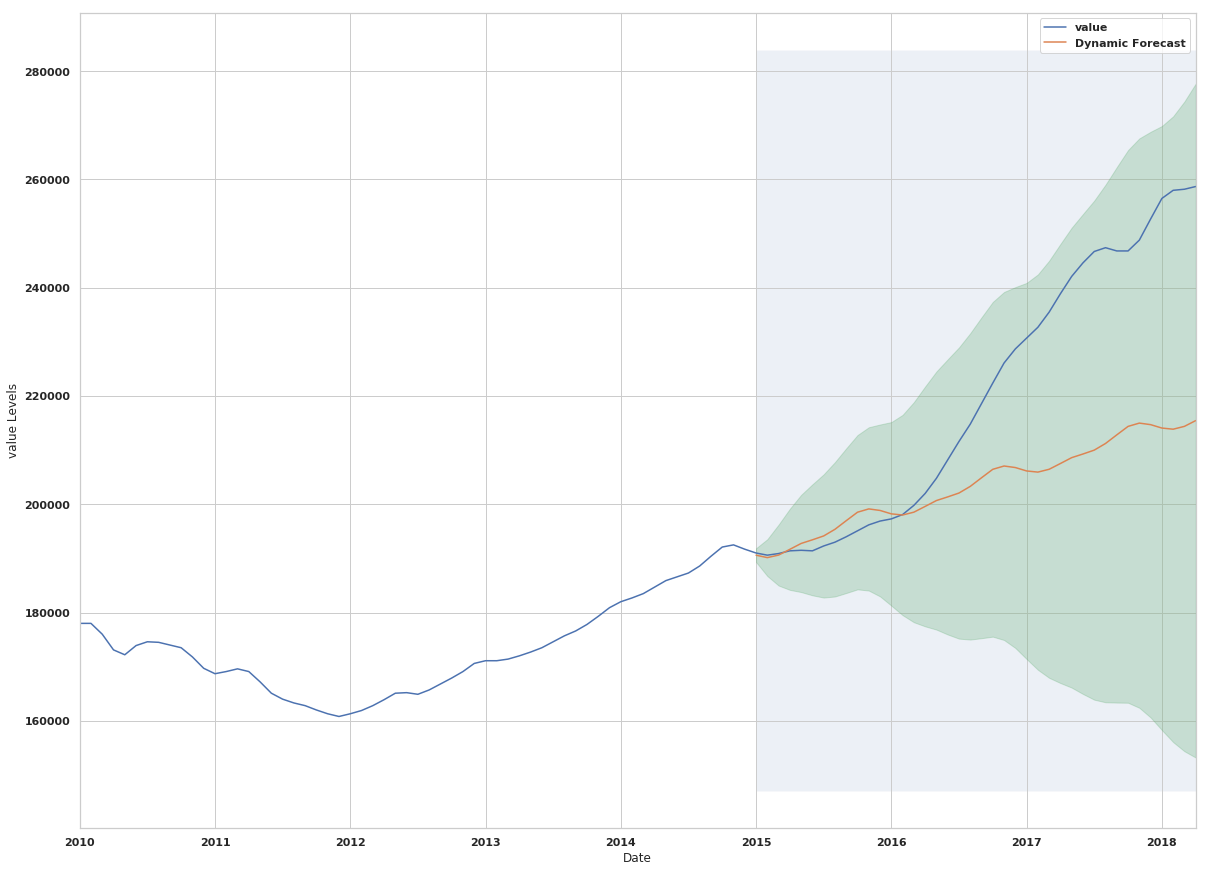

In [45]:
ax = zcs['zip_84606'].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-01'), value_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('value Levels')

plt.legend()
plt.show()

In [46]:
value2_forecasted = pred_dynamic.predicted_mean
value2_truth = zcs['zip_84606']['value']

# Compute the mean square error
mse = ((value2_forecasted - value2_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 553033875.27


In [47]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=72)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

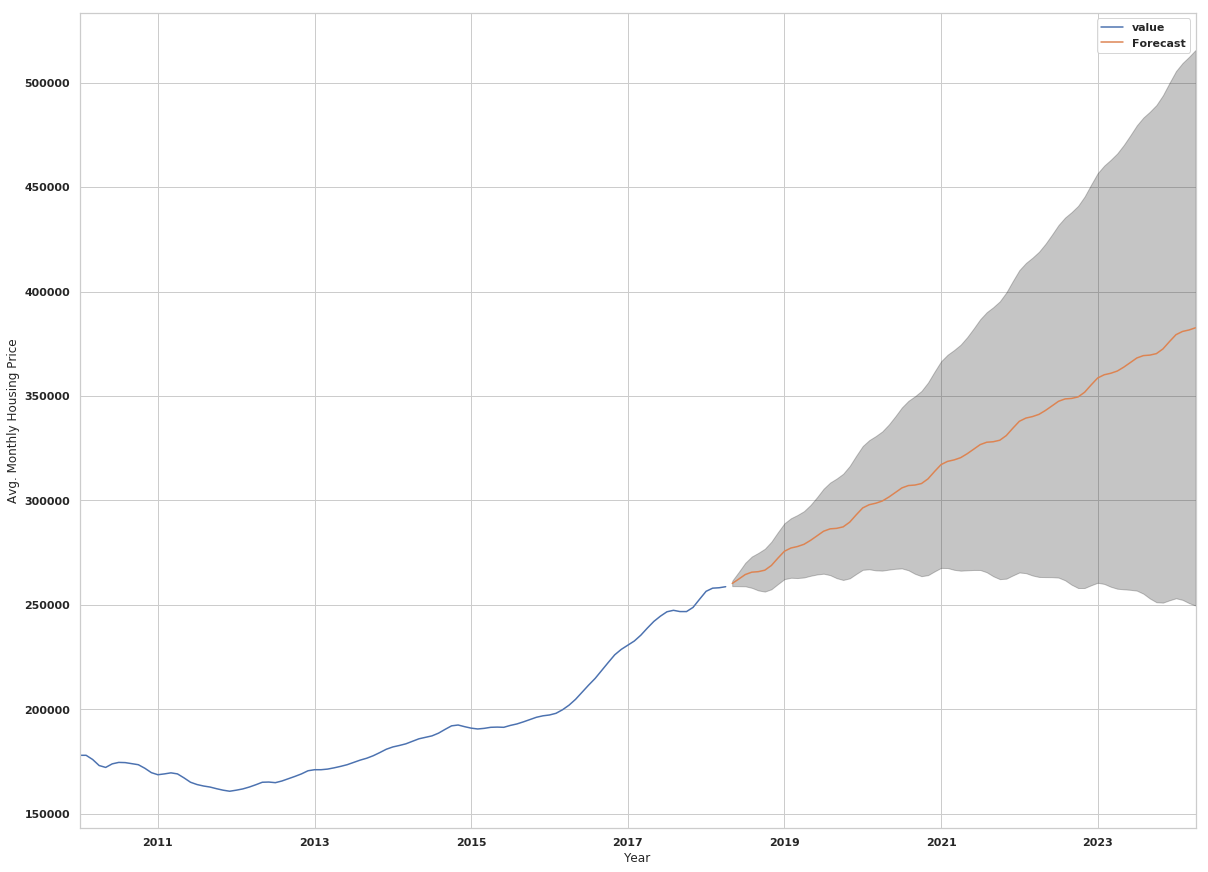

In [48]:
ax = zcs['zip_84606'].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Avg. Monthly Housing Price')

plt.legend()
plt.show()

In [49]:
a = [84606, 97701, 97756, 97702, 83702, 83705, 80631, 80620, 32163, 79764]
j = {}
for key in aa.keys():
    for i in aa[key].index:
        j[i] = aa[key].loc[i]['Avg_YOY_growth']
        
z = {}
for val in a:
    z[val] = j[val]
    
z

{84606: 0.05040849403471733,
 97701: 0.10827979607494724,
 97756: 0.10309948125087334,
 97702: 0.09184796034248412,
 83702: 0.06621284839599413,
 83705: 0.05907613211399325,
 80631: 0.10358596127437543,
 80620: 0.09412343626794462,
 32163: 0.05251994590560243,
 79764: 0.049460861267927425}

In [50]:
def new_rate(zipcode, order, sorder, data):
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(data,
                                            order=order,
                                            seasonal_order=sorder,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
    output = ARIMA_MODEL.fit()
    prediction = output.get_forecast(steps=72)
    
    pred_yr1 = []
    for i in prediction.predicted_mean.index[:12]:
        pred_yr1.append(prediction.predicted_mean.loc[i])
    
    pred_yr2 = []
    for i in prediction.predicted_mean.index[12:24]:
        pred_yr2.append(prediction.predicted_mean.loc[i])
        
    pred_yr3 = []
    for i in prediction.predicted_mean.index[24:36]:
        pred_yr3.append(prediction.predicted_mean.loc[i])
        
    pred_yr4 = []
    for i in prediction.predicted_mean.index[36:48]:
        pred_yr4.append(prediction.predicted_mean.loc[i])
        
    pred_yr5 = []
    for i in prediction.predicted_mean.index[48:60]:
        pred_yr5.append(prediction.predicted_mean.loc[i])
        
    pred_yr6 = []
    for i in prediction.predicted_mean.index[60:]:
        pred_yr6.append(prediction.predicted_mean.loc[i])
        
    first = {}
    first = {'prior_rate': z[zipcode], 'yr1': sum(pred_yr1)/12, 
             'yr2': sum(pred_yr2)/12, 'yr3': sum(pred_yr3)/12, 
             'yr4': sum(pred_yr4)/12, 'yr5': sum(pred_yr5)/12, 'yr6': sum(pred_yr6)/12}
    
    first['pred_ar'] = (((first['yr2'] - first['yr1'])/first['yr1']) + 
                   ((first['yr3'] - first['yr2'])/first['yr2']) + 
                   ((first['yr4'] - first['yr3'])/first['yr3']) + 
                   ((first['yr5'] - first['yr4'])/first['yr4']) + 
                   ((first['yr6'] - first['yr5'])/first['yr5'])) / 5
    return first

In [51]:
new_rate(84606, (0,1,3), (0,1,1,12), zcs['zip_84606'])

{'prior_rate': 0.05040849403471733,
 'yr1': 269696.2281775238,
 'yr2': 290415.6087589548,
 'yr3': 311146.5116922416,
 'yr4': 331877.41462552827,
 'yr5': 352608.31755881506,
 'yr6': 373339.22049210174,
 'pred_ar': 0.06721889272358215}

97701

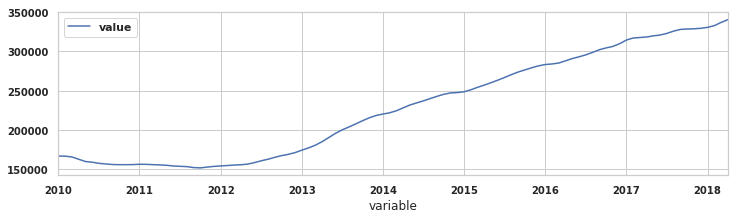

In [52]:
zcs['zip_97701'].plot(figsize=(12,3), linewidth=1.5, fontsize=10);

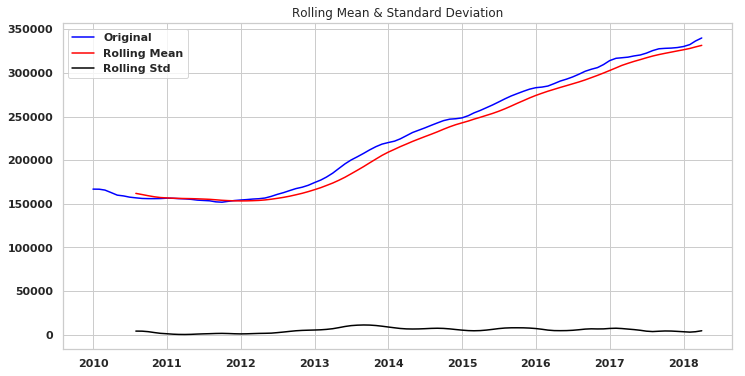

Results of Dickey-Fuller Test:
Test Statistic                 -0.023362
p-value                         0.956557
#Lags Used                      5.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


In [53]:
stationarity_check(zcs['zip_97701'])

In [54]:
def decomp(data):
    decomposition = seasonal_decompose(data)
    
    # Gather the trend, seasonality and noise of decomposed object
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plot gathered statistics
    plt.figure(figsize=(8,4))
    plt.subplot(411)
    plt.plot(data, label='Original', color="blue")
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color="blue")
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color="blue")
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color="blue")
    plt.legend(loc='best')
    plt.tight_layout()
    
    ts_decompose = residual
    ts_decompose.dropna(inplace=True)
    
    # Check stationarity
    stationarity_check(ts_decompose)

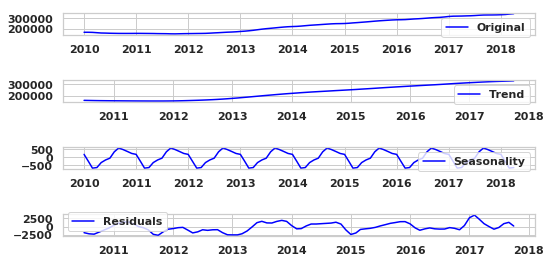

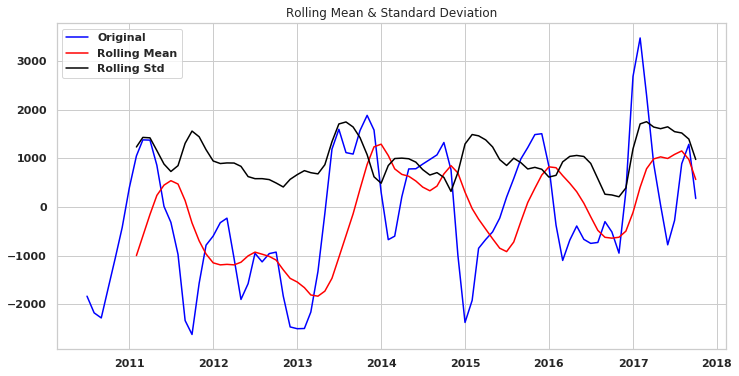

Results of Dickey-Fuller Test:
Test Statistic                 -3.546086
p-value                         0.006879
#Lags Used                      5.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [55]:
decomp(zcs['zip_97701'])

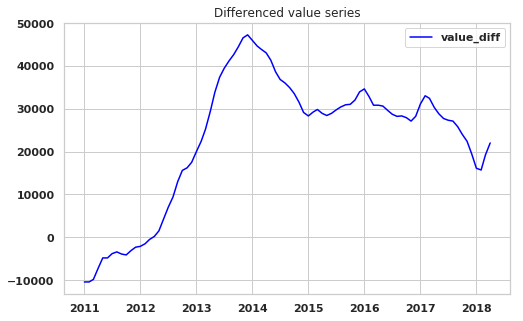

In [56]:
zip_diff = zcs['zip_97701'].diff(periods=12).dropna()
fig = plt.figure(figsize=(8,5))
plt.plot(zip_diff, color='blue',label='value_diff')
plt.legend(loc='best')
plt.title('Differenced value series')
plt.show(block=False)

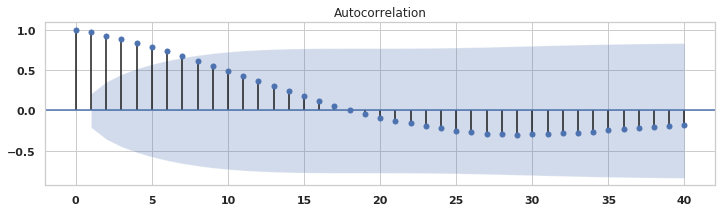

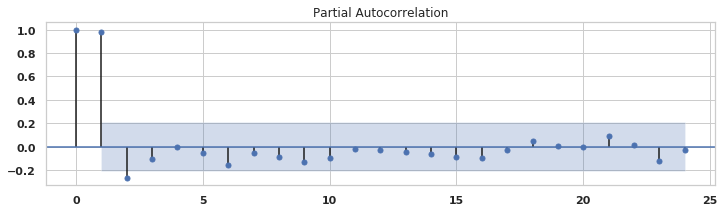

In [57]:
fig, ax = plt.subplots(figsize=(12,3))
plot_acf(zip_diff,ax=ax, lags=40)

fig, ax = plt.subplots(figsize=(12,3))
plot_pacf(zip_diff,ax=ax, lags=24);

In [58]:
models = sarima_configs(2,1,5,1,0,1,12)

In [59]:
ans = []
for i in models:
    try:
        mod = sm.tsa.statespace.SARIMAX(zcs['zip_97701'],
                                        order=i[0],
                                        seasonal_order=i[1],
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        output = mod.fit()
        ans.append([i[0], i[1], output.aic])
        print('ARIMA {} x {}12 : AIC Calculated ={}'.format(i[0], i[1], output.aic))
    except:
        continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =2734.008266451684
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =2364.5119514114754
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1943.3169160547473
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1892.3584012936258
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =2638.5887099062193
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =2432.219543730987
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =2348.063965253534
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =2429.7629349158688
ARIMA (0, 0, 2) x (0, 0, 0, 12)12 : AIC Calculated =2598.833316446055
ARIMA (0, 0, 2) x (0, 0, 1, 12)12 : AIC Calculated =2382.2792214164165
ARIMA (0, 0, 2) x (1, 0, 0, 12)12 : AIC Calculated =2352.062511731472
ARIMA (0, 0, 2) x (1, 0, 1, 12)12 : AIC Calculated =2382.9927054562936
ARIMA (0, 0, 3) x (0, 0, 0, 12)12 : AIC Calculated =3445.1239653974576
ARIMA (0, 0, 3) x (0, 0, 1, 12)12 : AIC Calculated =292720.95407913084
ARIMA (0, 0

ARIMA (2, 0, 5) x (0, 0, 0, 12)12 : AIC Calculated =1467.4446612762933
ARIMA (2, 0, 5) x (0, 0, 1, 12)12 : AIC Calculated =1842.0174599895722
ARIMA (2, 0, 5) x (1, 0, 0, 12)12 : AIC Calculated =1341.8600613172794
ARIMA (2, 0, 5) x (1, 0, 1, 12)12 : AIC Calculated =1366.985807441447
ARIMA (2, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =1565.891336878376
ARIMA (2, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =1386.0520511043546
ARIMA (2, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =1370.5803305298102
ARIMA (2, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =1372.5783020341999
ARIMA (2, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =1551.0453424093607
ARIMA (2, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =1350.4990131116613
ARIMA (2, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =1350.3968984774965
ARIMA (2, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =1352.3728624953064
ARIMA (2, 1, 2) x (0, 0, 0, 12)12 : AIC Calculated =1524.1282944291843
ARIMA (2, 1, 2) x (0, 0, 1, 12)12 : AIC Calculated =1331.0379970142324
ARIMA (2

In [60]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.sort_values('aic').head()

pdq           pdqs          aic
141  (2, 1, 5)  (0, 0, 1, 12)  1260.881482
95   (1, 1, 5)  (1, 0, 1, 12)  1262.132743
93   (1, 1, 5)  (0, 0, 1, 12)  1264.927247
143  (2, 1, 5)  (1, 0, 1, 12)  1266.184384
137  (2, 1, 4)  (0, 0, 1, 12)  1273.111883

In [61]:
#This code sets the selected orders to the SARIMA model

ARIMA_MODEL = sm.tsa.statespace.SARIMAX(zcs['zip_97701'],
                                order=(2, 1, 4),
                                seasonal_order=(0, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9103      0.033     57.775      0.000       1.845       1.975
ar.L2         -0.9114      0.033    -27.614      0.000      -0.976      -0.847
ma.L1         -0.3143      0.204     -1.543      0.123      -0.714       0.085
ma.L2         -1.3783      0.178     -7.755      0.000      -1.727      -1.030
ma.L3         -0.1773      0.170     -1.045      0.296      -0.510       0.155
ma.L4          0.8794      0.186      4.734      0.000       0.515       1.243
ma.S.L12      -0.1575      0.089     -1.762      0.078      -0.333       0.018
sigma2      3.149e+05   8.89e-07   3.54e+11      0.000    3.15e+05    3.15e+05


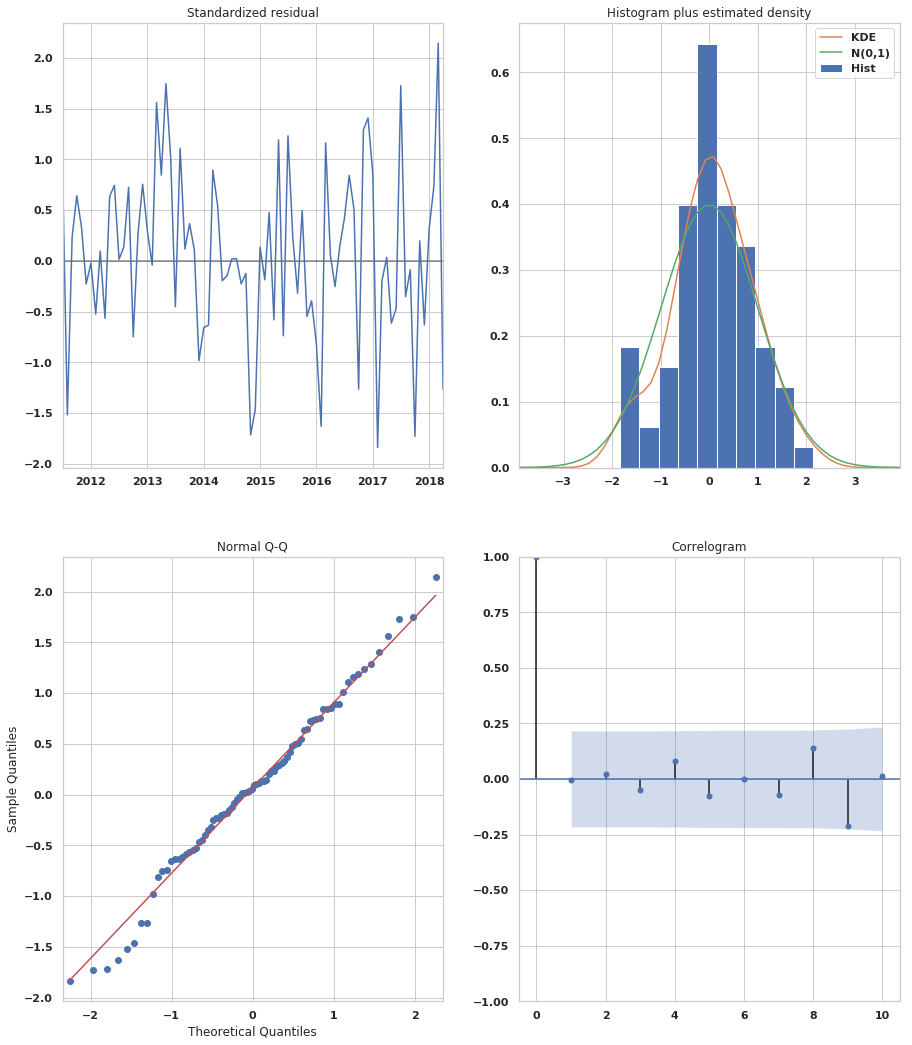

In [62]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

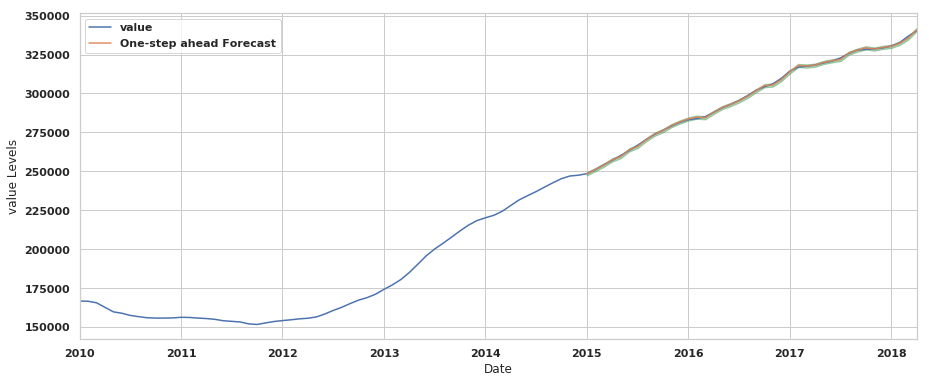

In [63]:
pred = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_conf = pred.conf_int()

rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = zcs['zip_97701'].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('value Levels')
plt.legend()

plt.show()

In [64]:
value_forecasted = pred.predicted_mean
value_truth = zcs['zip_97701']['2015-01-01':]['value']

# Compute the mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 272634.2


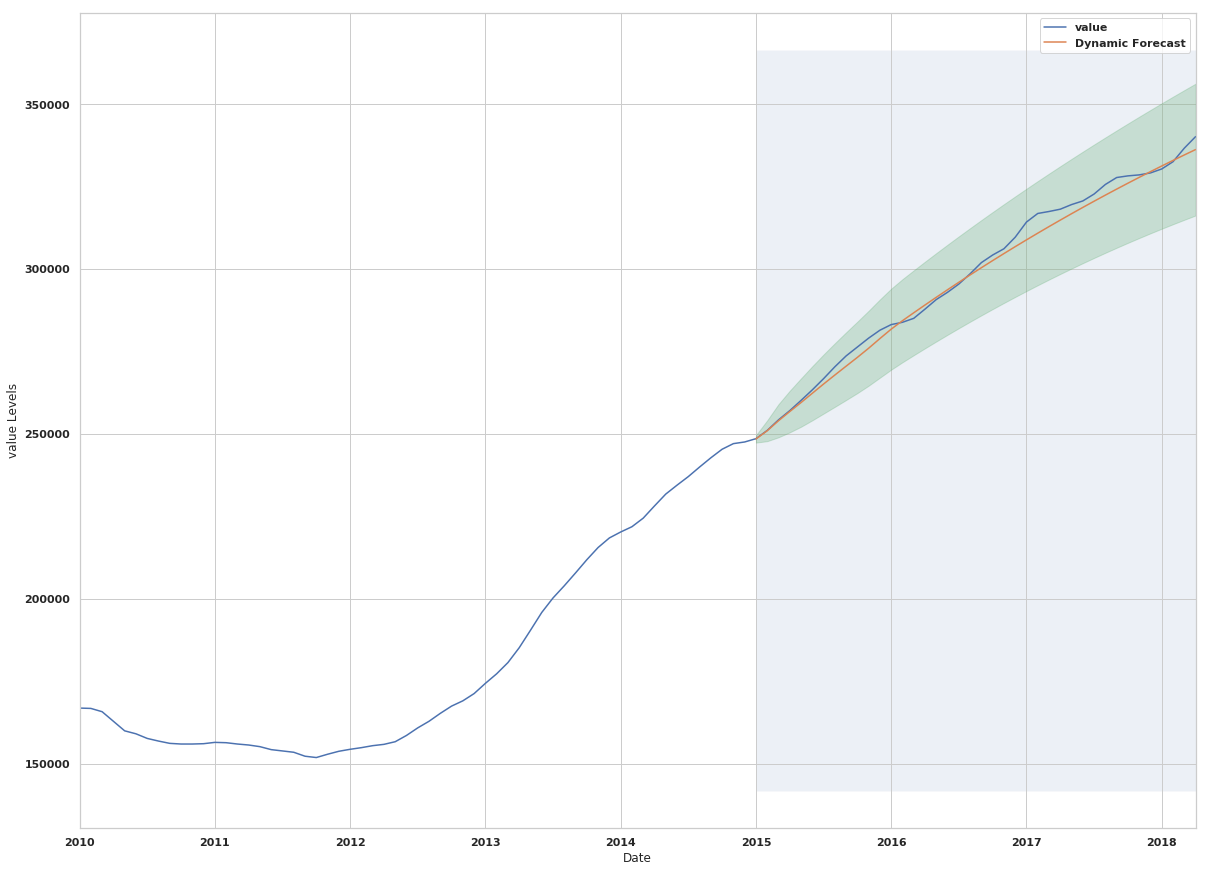

In [65]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

ax = zcs['zip_97701'].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-01'), value_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('value Levels')

plt.legend()
plt.show()

In [66]:
value2_forecasted = pred_dynamic.predicted_mean
value2_truth = zcs['zip_97701']['value']

# Compute the mean square error
mse = ((value2_forecasted - value2_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 5785935.35


In [67]:
# Get forecast 5 years ahead in future
prediction = output.get_forecast(steps=72)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

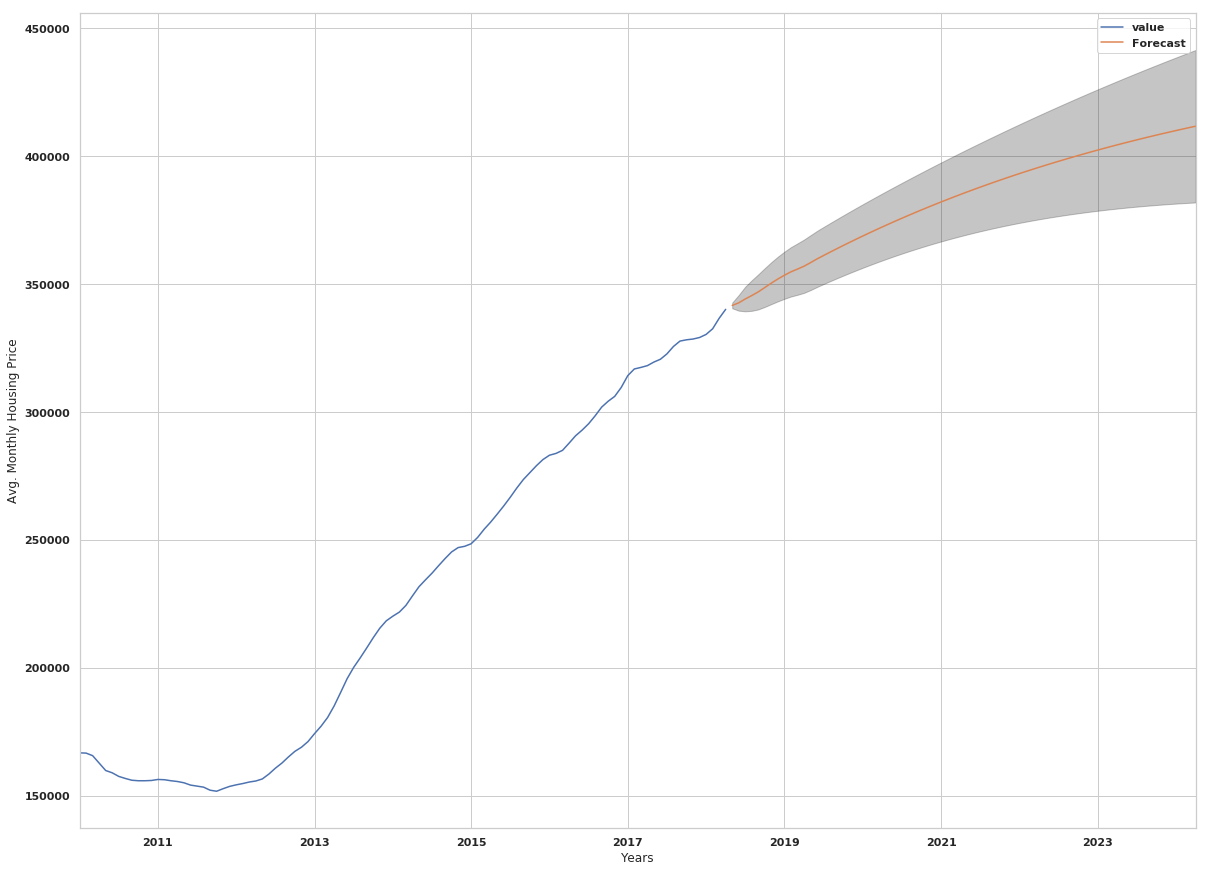

In [68]:
ax = zcs['zip_97701'].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Years')
ax.set_ylabel('Avg. Monthly Housing Price')

plt.legend()
plt.show()

In [69]:
new_rate(97701, (0,1,4), (0,1,1,12), zcs['zip_97701'])

{'prior_rate': 0.10827979607494724,
 'yr1': 350019.22729773377,
 'yr2': 372124.1087422211,
 'yr3': 394271.2351552152,
 'yr4': 416418.3615682094,
 'yr5': 438565.48798120365,
 'yr6': 460712.61439419776,
 'pred_ar': 0.0565049783395849}

97756

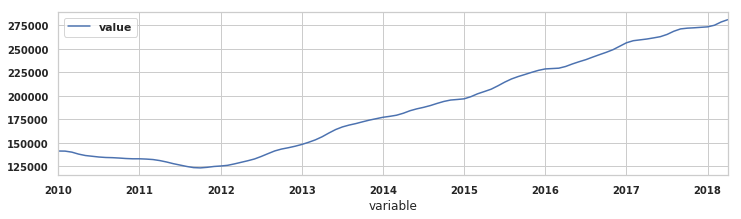

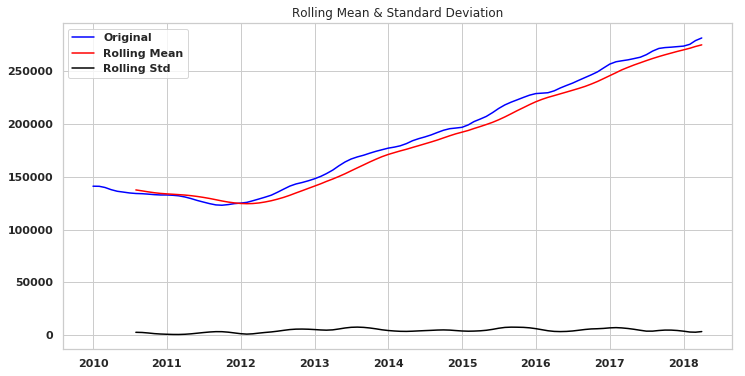

Results of Dickey-Fuller Test:
Test Statistic                 -0.199059
p-value                         0.938634
#Lags Used                      5.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


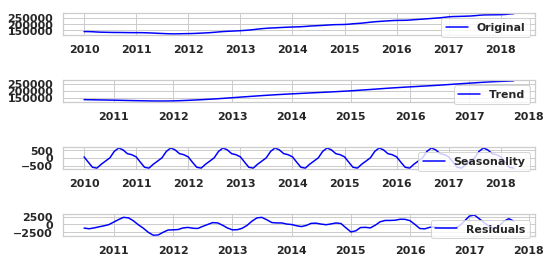

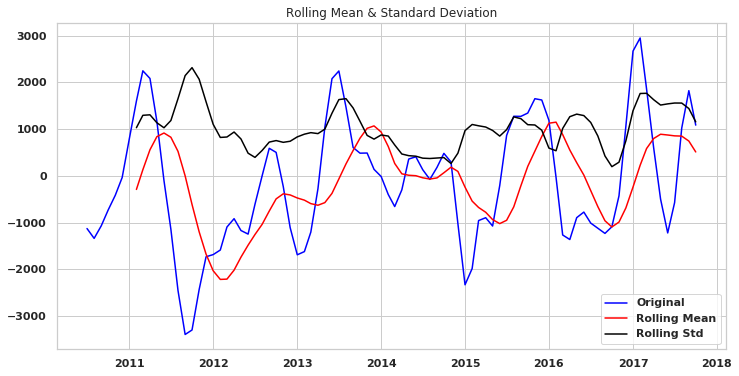

Results of Dickey-Fuller Test:
Test Statistic                 -3.347963
p-value                         0.012866
#Lags Used                      4.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [70]:
current_zip = zcs['zip_97756']

current_zip.plot(figsize=(12,3), linewidth=1.5, fontsize=10);

stationarity_check(current_zip);

decomp(current_zip)

In [71]:
def first_diff(data):
    zip_diff = data.diff(periods=12).dropna()
    fig = plt.figure(figsize=(8,5))
    plt.plot(zip_diff, color='blue',label='value_diff')
    plt.legend(loc='best')
    plt.title('Differenced value series')
    plt.show(block=False)

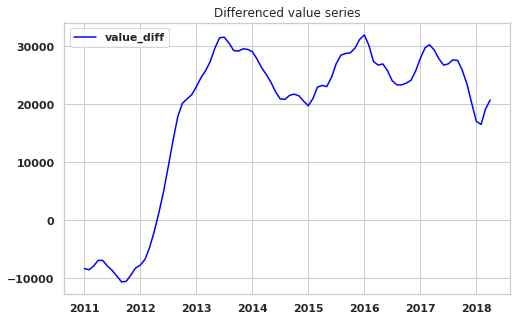

In [72]:
first_diff(current_zip)

In [73]:
def acf_pacf(data):
    fig, ax = plt.subplots(figsize=(12,3))
    plot_acf(data,ax=ax, lags=40)
    fig, ax = plt.subplots(figsize=(12,3))
    plot_pacf(data,ax=ax, lags=24);

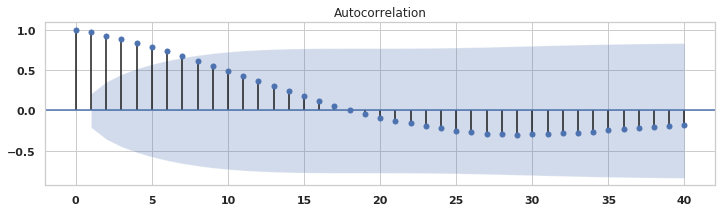

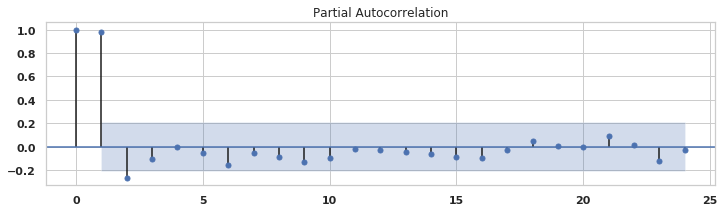

In [74]:
acf_pacf(zip_diff)

In [75]:
models = sarima_configs(2,1,3,2,1,1,12)

In [76]:
def trial_models(data):
    ans = []
    for i in models:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                            order=i[0],
                                            seasonal_order=i[1],
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([i[0], i[1], output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(i[0], i[1], output.aic))
        except:
            continue
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    return ans_df.sort_values('aic').head(10)

In [77]:
trial_models(current_zip)

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =2693.8871007176135
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =2327.7525960103612
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =1996.7120594951004
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =1732.4144207993593
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1907.126949409716
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1822.3254408797354
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =1659.5625070633494
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =1641.337333469593
ARIMA (0, 0, 0) x (2, 0, 0, 12)12 : AIC Calculated =1596.3957572106403
ARIMA (0, 0, 0) x (2, 0, 1, 12)12 : AIC Calculated =1592.4690909028639
ARIMA (0, 0, 0) x (2, 1, 0, 12)12 : AIC Calculated =1382.5629247566103
ARIMA (0, 0, 0) x (2, 1, 1, 12)12 : AIC Calculated =1330.3385503302316
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =2598.777218651315
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =2268.4538140617474
ARIMA (0,

ARIMA (1, 0, 1) x (2, 0, 0, 12)12 : AIC Calculated =1256.8848614231786
ARIMA (1, 0, 1) x (2, 0, 1, 12)12 : AIC Calculated =1217.8910066013016
ARIMA (1, 0, 1) x (2, 1, 0, 12)12 : AIC Calculated =1042.3206149356013
ARIMA (1, 0, 1) x (2, 1, 1, 12)12 : AIC Calculated =1044.177864611969
ARIMA (1, 0, 2) x (0, 0, 0, 12)12 : AIC Calculated =1534.9580049879578
ARIMA (1, 0, 2) x (0, 0, 1, 12)12 : AIC Calculated =1345.4406366613339
ARIMA (1, 0, 2) x (0, 1, 0, 12)12 : AIC Calculated =1439.6984505124667
ARIMA (1, 0, 2) x (0, 1, 1, 12)12 : AIC Calculated =1178.4532516708093
ARIMA (1, 0, 2) x (1, 0, 0, 12)12 : AIC Calculated =1378.2094990626765
ARIMA (1, 0, 2) x (1, 0, 1, 12)12 : AIC Calculated =1359.1032277479158
ARIMA (1, 0, 2) x (1, 1, 0, 12)12 : AIC Calculated =1223.835852591422
ARIMA (1, 0, 2) x (1, 1, 1, 12)12 : AIC Calculated =1312.1920639179036
ARIMA (1, 0, 2) x (2, 0, 0, 12)12 : AIC Calculated =1187.7480385594536
ARIMA (1, 0, 2) x (2, 0, 1, 12)12 : AIC Calculated =1189.445451046248
ARIMA (1,

ARIMA (2, 0, 3) x (1, 0, 0, 12)12 : AIC Calculated =1316.7682626389935
ARIMA (2, 0, 3) x (1, 0, 1, 12)12 : AIC Calculated =1323.0338669697098
ARIMA (2, 0, 3) x (1, 1, 0, 12)12 : AIC Calculated =1183.050806533805
ARIMA (2, 0, 3) x (1, 1, 1, 12)12 : AIC Calculated =1238.4195831866095
ARIMA (2, 0, 3) x (2, 0, 0, 12)12 : AIC Calculated =1184.9944078440883
ARIMA (2, 0, 3) x (2, 0, 1, 12)12 : AIC Calculated =1153.5023615613916
ARIMA (2, 0, 3) x (2, 1, 0, 12)12 : AIC Calculated =983.4947365791094
ARIMA (2, 0, 3) x (2, 1, 1, 12)12 : AIC Calculated =1107.9613514057398
ARIMA (2, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =1521.3198878620078
ARIMA (2, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =1353.6463180324977
ARIMA (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =1390.8239376384172
ARIMA (2, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =1212.2287467777255
ARIMA (2, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =1337.0138347751579
ARIMA (2, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =1338.986682825438
ARIMA (2,

pdq           pdqs         aic
287  (2, 1, 3)  (2, 1, 1, 12)  965.726375
275  (2, 1, 2)  (2, 1, 1, 12)  968.608074
274  (2, 1, 2)  (2, 1, 0, 12)  968.808137
263  (2, 1, 1)  (2, 1, 1, 12)  969.087325
262  (2, 1, 1)  (2, 1, 0, 12)  969.367029
250  (2, 1, 0)  (2, 1, 0, 12)  976.548117
251  (2, 1, 0)  (2, 1, 1, 12)  978.153312
286  (2, 1, 3)  (2, 1, 0, 12)  980.292039
179  (1, 1, 2)  (2, 1, 1, 12)  981.965797
238  (2, 0, 3)  (2, 1, 0, 12)  983.494737

In [78]:
model_selection = [(2,1,0), (2,1,0,12)]

In [79]:
def model(data, order, sorder):
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(data,
                                            order=order,
                                            seasonal_order=sorder,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
    output = ARIMA_MODEL.fit()
    print(output.summary().tables[1])
    output.plot_diagnostics(figsize=(12, 9))
    plt.show()
    
    pred = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
    pred_conf = pred.conf_int()
    
    rcParams['figure.figsize'] = 15, 6
    
    #Plot observed values
    ax = data.plot(label='observed')
    
    #Plot predicted values
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)
    
    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=.5)
    
    #Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Prices')
    plt.legend()
    plt.show()
    
    value_forecasted = pred.predicted_mean
    value_truth = data['2015-01-01':]['value']

    # Compute the mean square error
    mse = ((value_forecasted - value_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True, full_results=True)
    pred_dynamic_conf = pred_dynamic.conf_int()

    ax = data.plot(label='observed', figsize=(20, 15))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.25)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-01'), value_forecasted.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('value Levels')

    plt.legend()
    plt.show()
    
    value2_forecasted = pred_dynamic.predicted_mean
    value2_truth = data['value']
    
    # Compute the mean square error
    mse = ((value2_forecasted - value2_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    
    # Get forecast 5 years ahead in future
    prediction = output.get_forecast(steps=72)
    
    # Get confidence intervals of forecasts
    pred_conf = prediction.conf_int()
    
    ax = data.plot(label='observed', figsize=(20, 15))
    prediction.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Years')
    ax.set_ylabel('Avg. Monthly Housing Price')

    plt.legend()
    plt.show()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3015      0.119     10.979      0.000       1.069       1.534
ar.L2         -0.4653      0.126     -3.702      0.000      -0.712      -0.219
ar.S.L12      -0.9341      0.121     -7.706      0.000      -1.172      -0.697
ar.S.L24      -0.6758      0.135     -5.019      0.000      -0.940      -0.412
sigma2      4.456e+05   9.81e+04      4.541      0.000    2.53e+05    6.38e+05


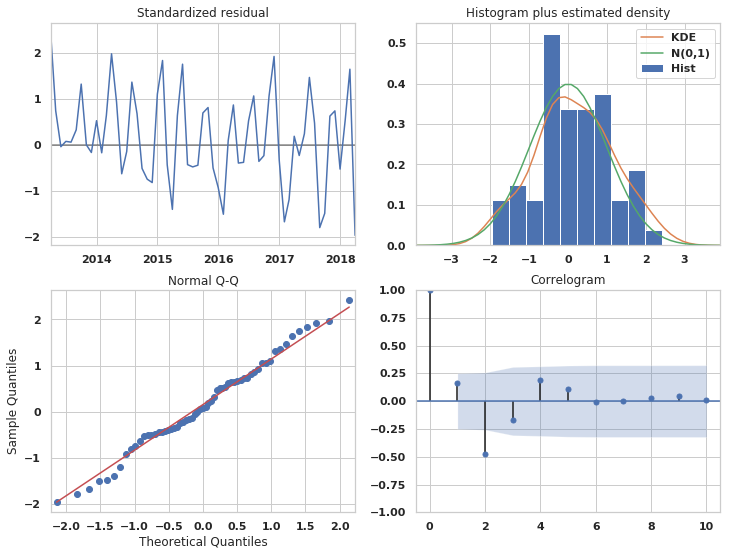

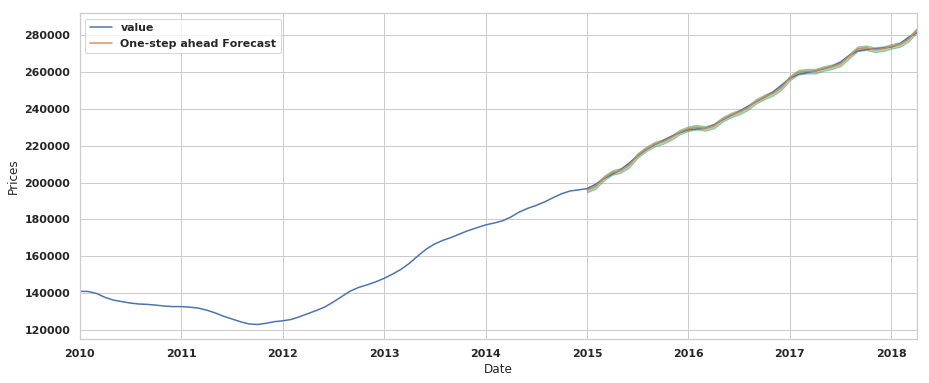

The Mean Squared Error of our forecasts is 479393.68


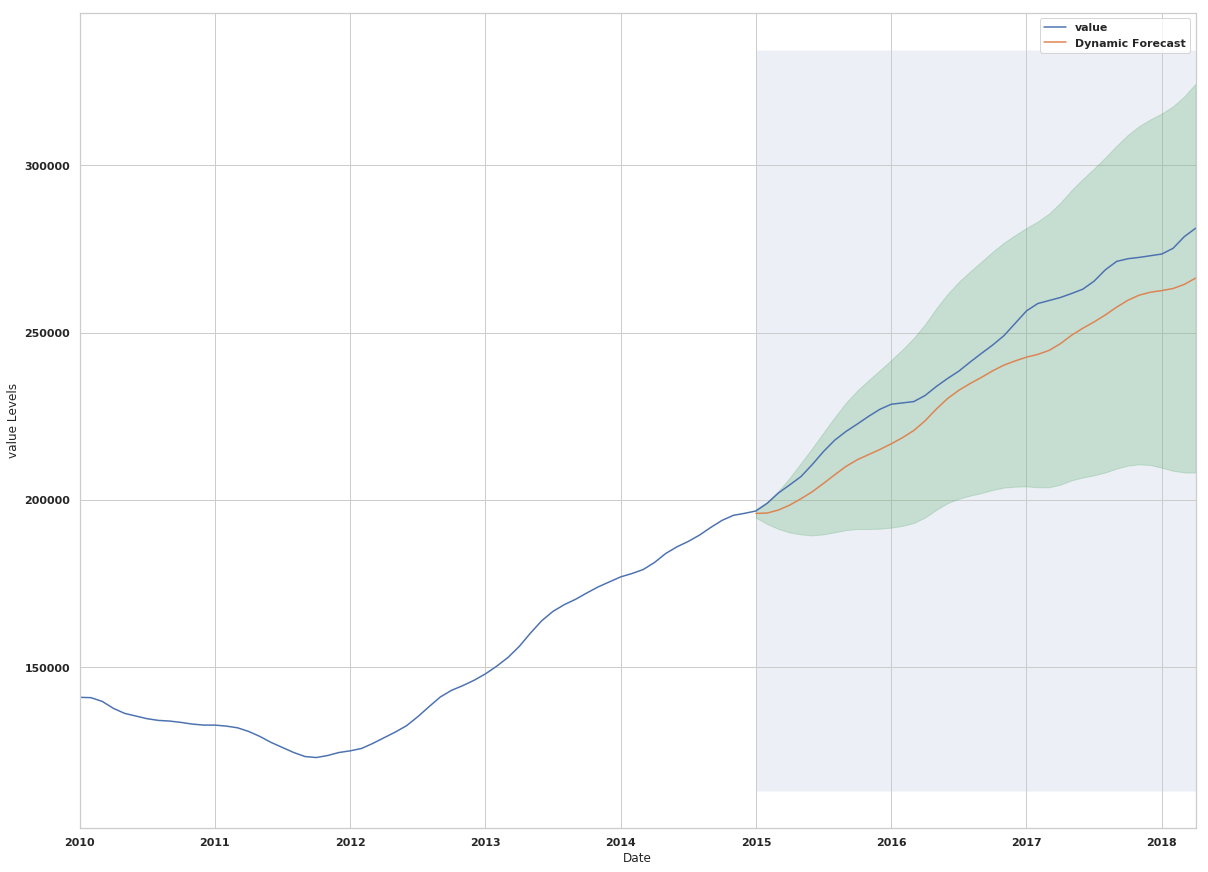

The Mean Squared Error of our forecasts is 111590563.63


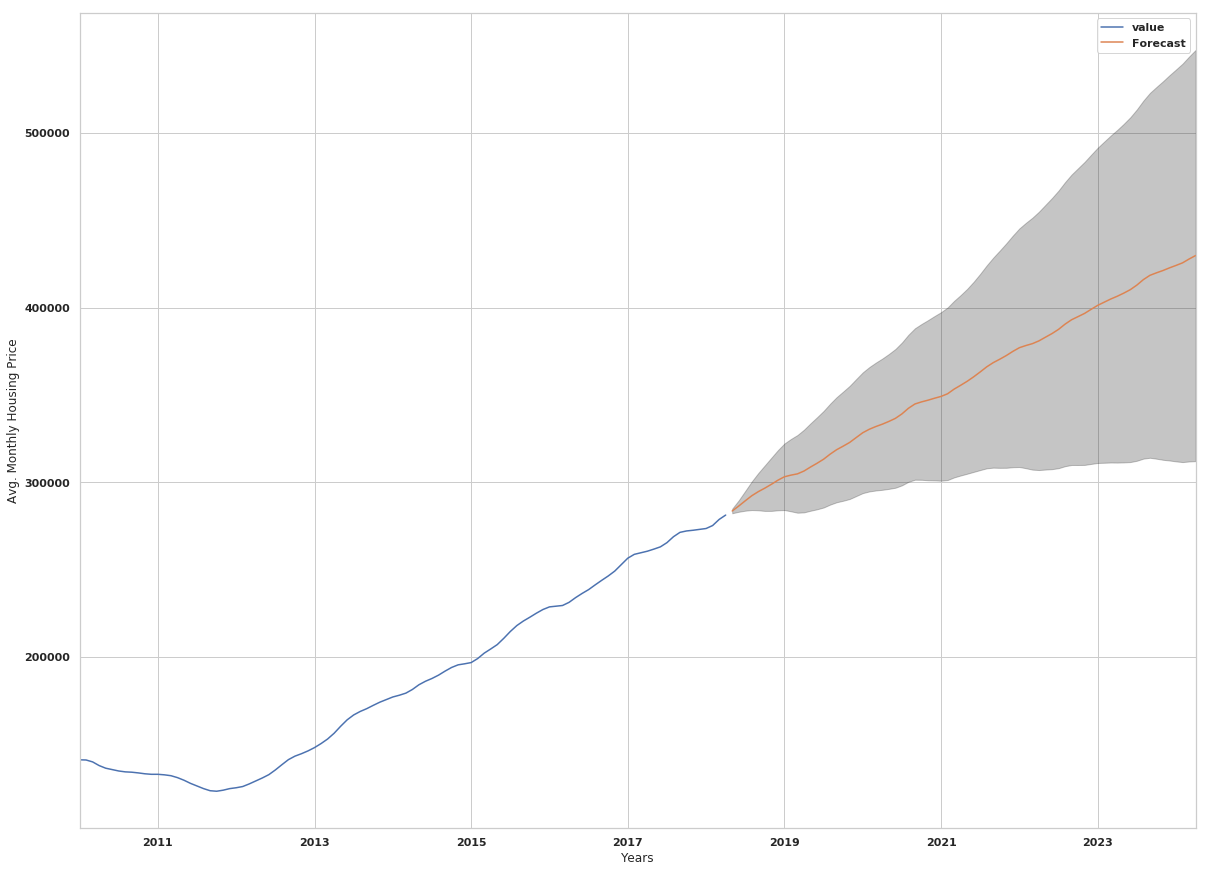

In [80]:
model(current_zip, model_selection[0], model_selection[1])

In [81]:
new_rate(97756, (2,1,0), (2,1,0,12), zcs['zip_97756'])

{'prior_rate': 0.10309948125087334,
 'yr1': 296769.27234230645,
 'yr2': 321702.66207591974,
 'yr3': 345634.8741474124,
 'yr4': 370819.3643210822,
 'yr5': 395510.6200673508,
 'yr6': 419816.38351519586,
 'pred_ar': 0.07186253048090294}

97702

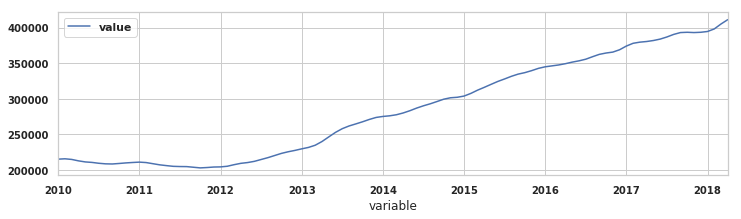

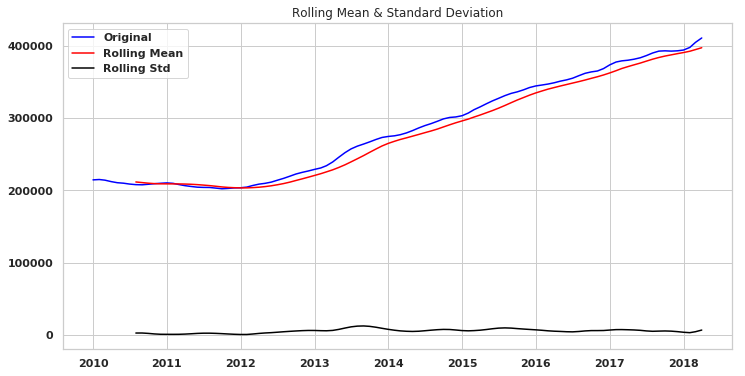

Results of Dickey-Fuller Test:
Test Statistic                  0.208002
p-value                         0.972707
#Lags Used                      5.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


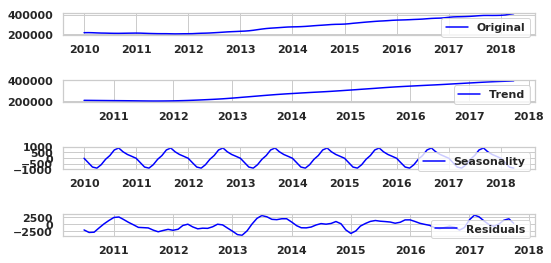

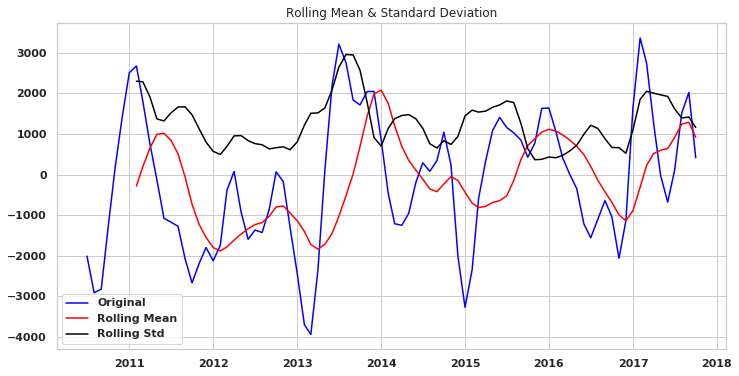

Results of Dickey-Fuller Test:
Test Statistic                 -4.008239
p-value                         0.001368
#Lags Used                      5.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [82]:
current_zip = zcs['zip_97702']

current_zip.plot(figsize=(12,3), linewidth=1.5, fontsize=10);

stationarity_check(current_zip);

decomp(current_zip)

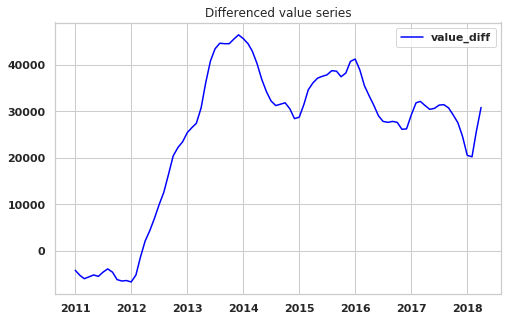

In [83]:
first_diff(current_zip)

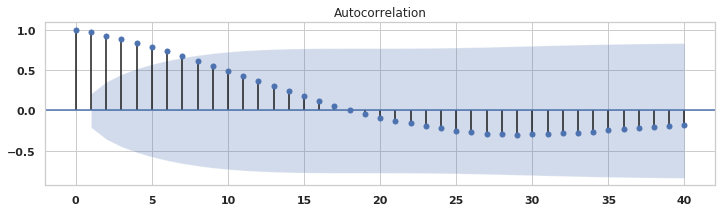

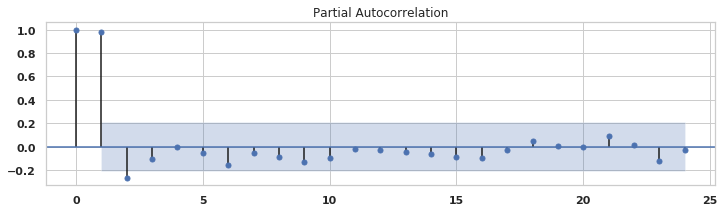

In [84]:
acf_pacf(zip_diff)

In [86]:
models = sarima_configs(2,1,3,2,1,2,12)

trial_models(current_zip)

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =2775.645844117141
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =2399.208819740968
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =2079.0980753459703
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =2042.6053239227388
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =1773.112105536904
ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =2064.1727662401654
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1944.2352055765284
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1881.5432807309564
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =1777.358793204857
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =1687.6185468435424
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =2307.8433056588874
ARIMA (0, 0, 0) x (1, 1, 2, 12)12 : AIC Calculated =2436.6317862789824
ARIMA (0, 0, 0) x (2, 0, 0, 12)12 : AIC Calculated =1643.434268252526
ARIMA (0, 0, 0) x (2, 0, 1, 12)12 : AIC Calculated =1657.0267566088244
ARIMA (0, 0

ARIMA (0, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =1195.146790100573
ARIMA (0, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =4850.622944629915
ARIMA (0, 1, 2) x (2, 0, 0, 12)12 : AIC Calculated =1233.3751481798204
ARIMA (0, 1, 2) x (2, 0, 1, 12)12 : AIC Calculated =1311.940975509852
ARIMA (0, 1, 2) x (2, 0, 2, 12)12 : AIC Calculated =1181.341751599388
ARIMA (0, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =1043.7435440409622
ARIMA (0, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =1043.6868108468082
ARIMA (0, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3626.0208354169895
ARIMA (0, 1, 3) x (0, 0, 0, 12)12 : AIC Calculated =1544.7750525670149
ARIMA (0, 1, 3) x (0, 0, 1, 12)12 : AIC Calculated =1337.1859345890055
ARIMA (0, 1, 3) x (0, 0, 2, 12)12 : AIC Calculated =1149.0944271770757
ARIMA (0, 1, 3) x (0, 1, 0, 12)12 : AIC Calculated =1406.2881846201135
ARIMA (0, 1, 3) x (0, 1, 1, 12)12 : AIC Calculated =1151.9187441156666
ARIMA (0, 1, 3) x (0, 1, 2, 12)12 : AIC Calculated =4585.454712363341
ARIMA (0, 1

ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =1372.541622268041
ARIMA (1, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =1185.0097906615063
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =1467.5454743484431
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =1226.0182042646709
ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =nan
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =1393.3505635189147
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =1373.360209045674
ARIMA (1, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =1186.89918087099
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =1242.7164205266633
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =1245.0664958169036
ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =4733.042244574652
ARIMA (1, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =1201.903337915098
ARIMA (1, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =1201.754252470556
ARIMA (1, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =1188.5544947303829
ARIMA (1, 1, 1) x (2, 1, 0, 

ARIMA (2, 0, 3) x (1, 1, 1, 12)12 : AIC Calculated =1283.211443979894
ARIMA (2, 0, 3) x (1, 1, 2, 12)12 : AIC Calculated =1814.5231851695335
ARIMA (2, 0, 3) x (2, 0, 0, 12)12 : AIC Calculated =1221.2525935474678
ARIMA (2, 0, 3) x (2, 0, 1, 12)12 : AIC Calculated =1296.9516473288456
ARIMA (2, 0, 3) x (2, 0, 2, 12)12 : AIC Calculated =1276.252526758423
ARIMA (2, 0, 3) x (2, 1, 0, 12)12 : AIC Calculated =1029.1117296314833
ARIMA (2, 0, 3) x (2, 1, 1, 12)12 : AIC Calculated =1110.7900960778234
ARIMA (2, 0, 3) x (2, 1, 2, 12)12 : AIC Calculated =2916.685668736324
ARIMA (2, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =1596.741539748176
ARIMA (2, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =1422.6138518970276
ARIMA (2, 1, 0) x (0, 0, 2, 12)12 : AIC Calculated =1232.3547907772793
ARIMA (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =1449.9128152459386
ARIMA (2, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =1261.2673616904535
ARIMA (2, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =2682.440703201951
ARIMA (2, 1

pdq           pdqs          aic
429  (2, 1, 3)  (2, 1, 0, 12)   994.180267
430  (2, 1, 3)  (2, 1, 1, 12)   995.542313
412  (2, 1, 2)  (2, 1, 1, 12)  1002.821311
394  (2, 1, 1)  (2, 1, 1, 12)  1005.452240
411  (2, 1, 2)  (2, 1, 0, 12)  1007.018275
285  (1, 1, 3)  (2, 1, 0, 12)  1013.751580
393  (2, 1, 1)  (2, 1, 0, 12)  1015.794854
286  (1, 1, 3)  (2, 1, 1, 12)  1016.068492
339  (2, 0, 2)  (2, 1, 0, 12)  1018.157619
267  (1, 1, 2)  (2, 1, 0, 12)  1020.464791

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6968      0.162      4.295      0.000       0.379       1.015
ar.L2         -0.0599      0.171     -0.351      0.725      -0.394       0.274
ma.L1          1.0001      0.231      4.325      0.000       0.547       1.453
ar.S.L12      -0.8344      0.191     -4.360      0.000      -1.209      -0.459
ar.S.L24       0.0441      0.014      3.234      0.001       0.017       0.071
sigma2      1.033e+06   2.23e-07   4.63e+12      0.000    1.03e+06    1.03e+06


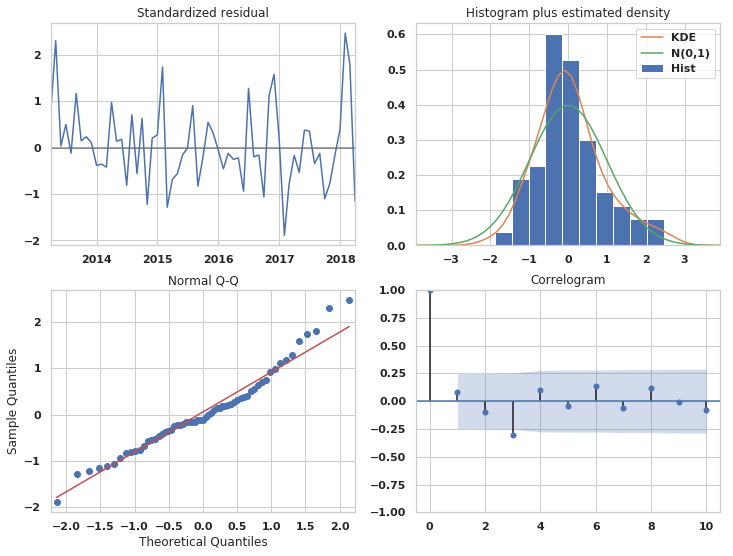

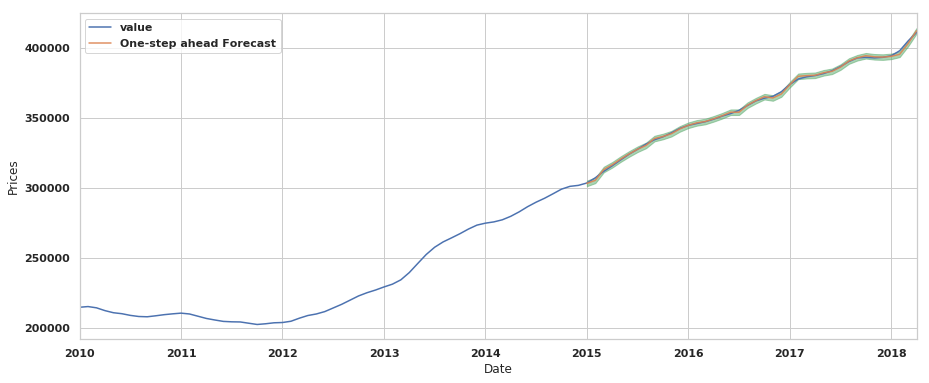

The Mean Squared Error of our forecasts is 863753.38


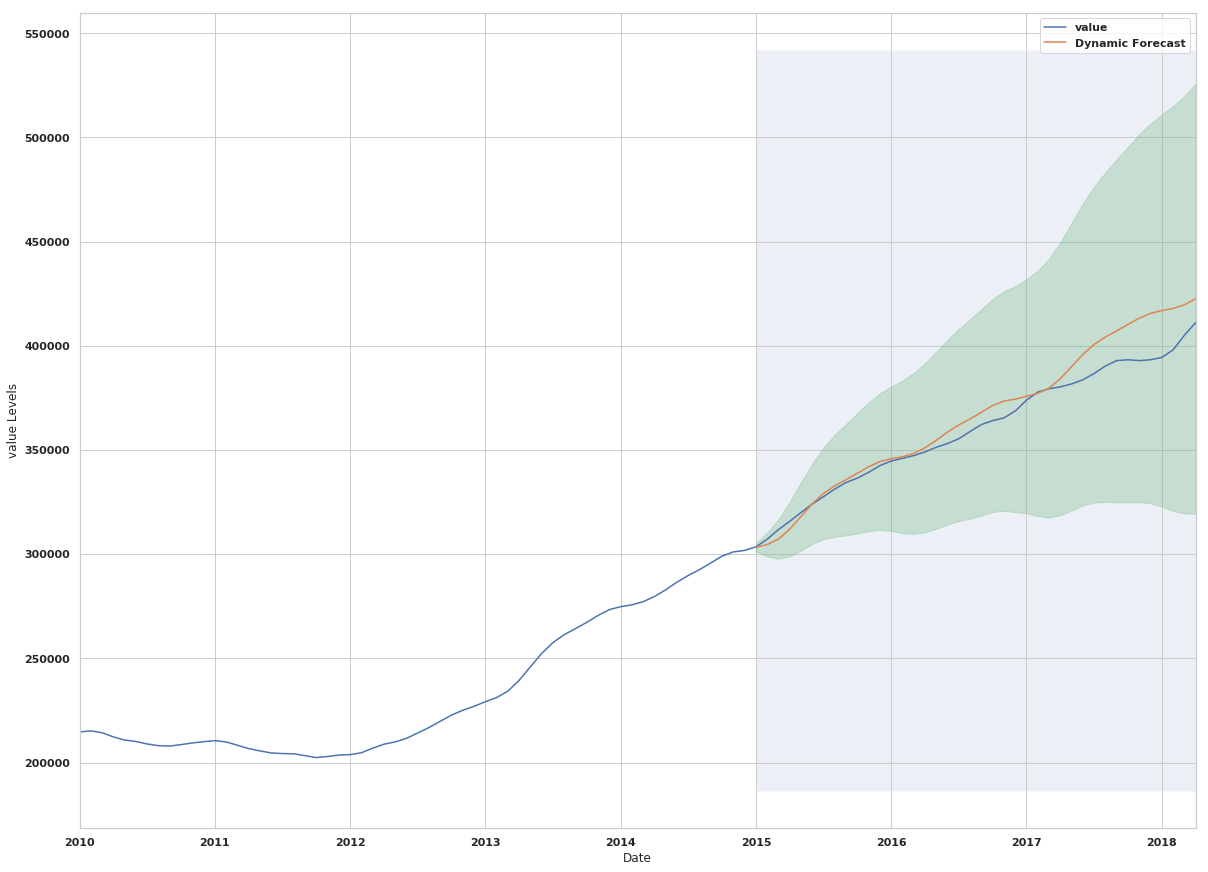

The Mean Squared Error of our forecasts is 91352245.43


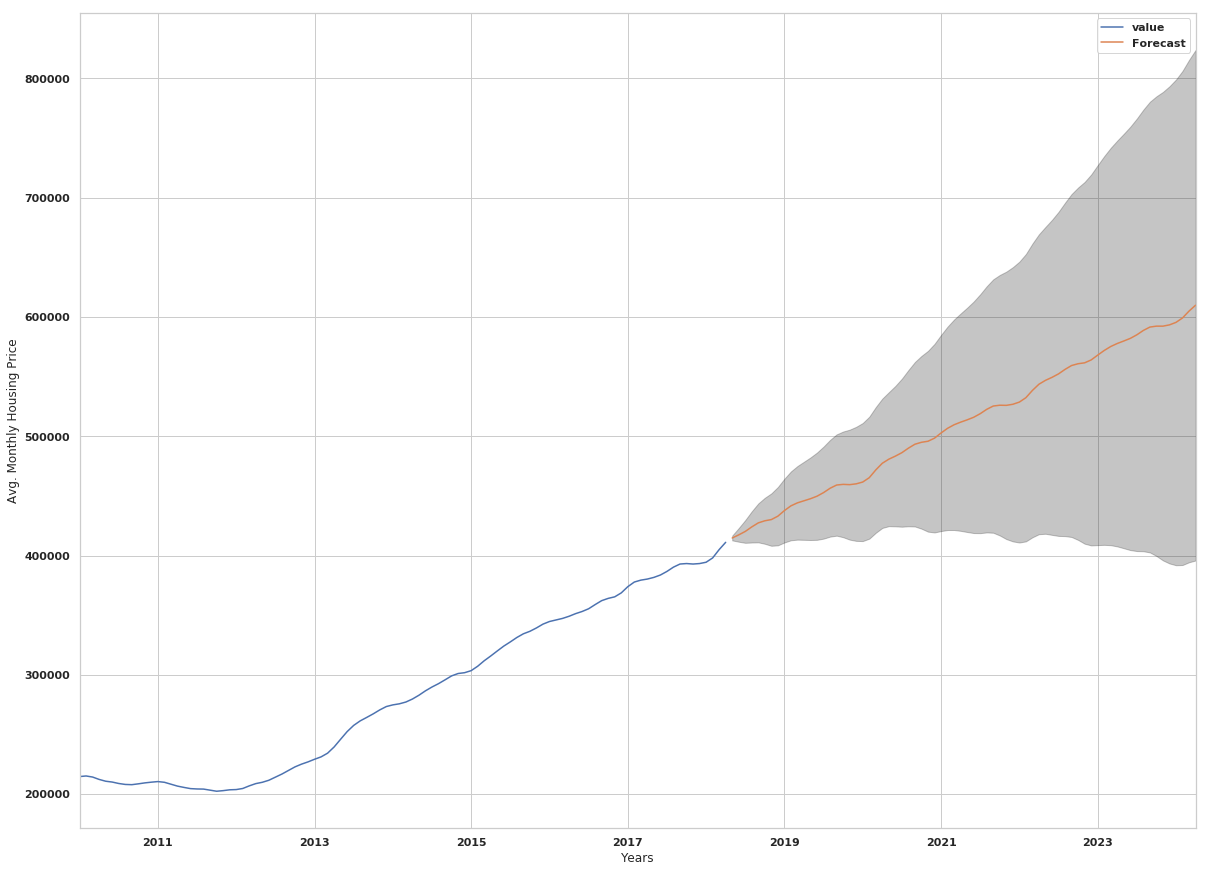

In [88]:
model_selection = [(2,1,1), (2,1,0,12)]

model(current_zip, model_selection[0], model_selection[1])

In [89]:
new_rate(97702, (2,1,1), (2,1,0,12), zcs['zip_97702'])

{'prior_rate': 0.09184796034248412,
 'yr1': 430475.3939762265,
 'yr2': 460106.43604481773,
 'yr3': 496178.6868518968,
 'yr4': 526557.4819535463,
 'yr5': 561970.7816311846,
 'yr6': 592932.3615721257,
 'pred_ar': 0.06616152783093888}

83702

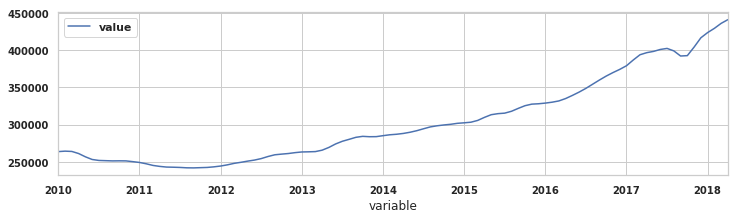

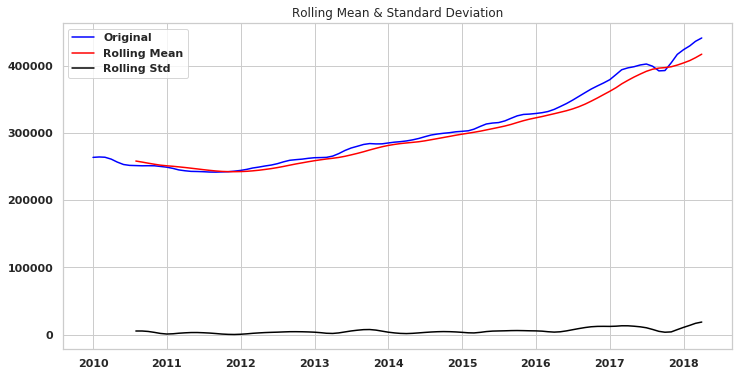

Results of Dickey-Fuller Test:
Test Statistic                  1.629341
p-value                         0.997943
#Lags Used                      7.000000
Number of Observations Used    92.000000
Critical Value (1%)            -3.503515
Critical Value (5%)            -2.893508
Critical Value (10%)           -2.583824
dtype: float64


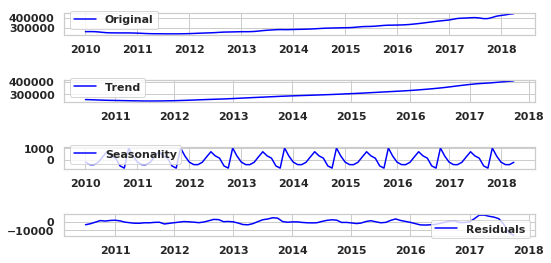

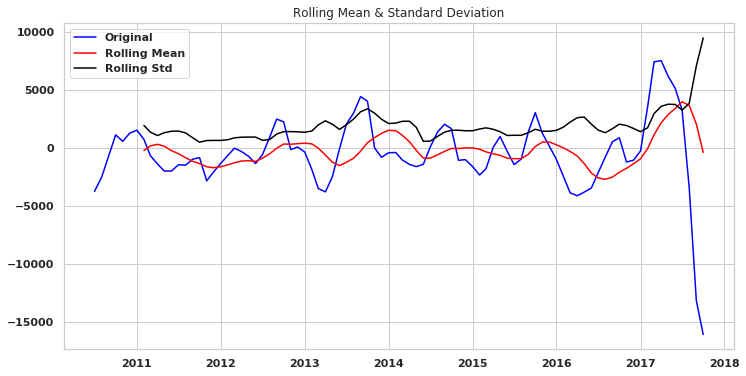

Results of Dickey-Fuller Test:
Test Statistic                 -4.805857
p-value                         0.000053
#Lags Used                     12.000000
Number of Observations Used    75.000000
Critical Value (1%)            -3.520713
Critical Value (5%)            -2.900925
Critical Value (10%)           -2.587781
dtype: float64


In [90]:
current_zip = zcs['zip_83702']

current_zip.plot(figsize=(12,3), linewidth=1.5, fontsize=10);

stationarity_check(current_zip);

decomp(current_zip)

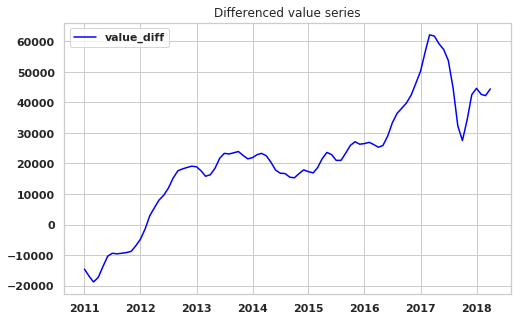

In [91]:
first_diff(current_zip)

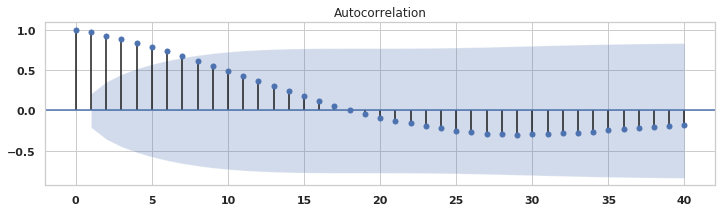

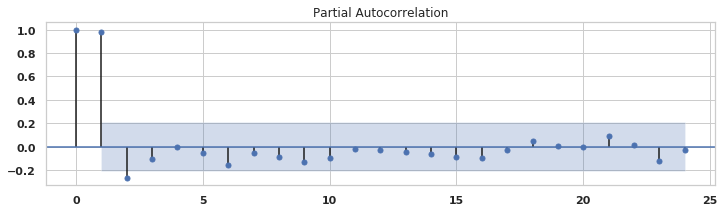

In [92]:
acf_pacf(zip_diff)

In [94]:
models = sarima_configs(2,1,3,2,1,2,12)

trial_models(current_zip)

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =2785.618843074288
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =2404.1679532754433
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =2082.8366601356133
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =2034.1667791218747
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =1764.3631939489499
ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =2419.2807942728527
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1963.3532285140727
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1877.7326314979155
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =2380.808756097801
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =1685.8101619045167
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =1702.0543773020654
ARIMA (0, 0, 0) x (1, 1, 2, 12)12 : AIC Calculated =2800.9729703759367
ARIMA (0, 0, 0) x (2, 0, 0, 12)12 : AIC Calculated =1616.5411999274368
ARIMA (0, 0, 0) x (2, 0, 1, 12)12 : AIC Calculated =1618.162125281259
ARIMA (0,

ARIMA (0, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =4687.297448008024
ARIMA (0, 1, 2) x (2, 0, 0, 12)12 : AIC Calculated =1321.085735296557
ARIMA (0, 1, 2) x (2, 0, 1, 12)12 : AIC Calculated =1322.7653000578441
ARIMA (0, 1, 2) x (2, 0, 2, 12)12 : AIC Calculated =1249.4945303527131
ARIMA (0, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =1099.1672394921666
ARIMA (0, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =1098.6086185431473
ARIMA (0, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =1955.436868482464
ARIMA (0, 1, 3) x (0, 0, 0, 12)12 : AIC Calculated =1616.0247976019543
ARIMA (0, 1, 3) x (0, 0, 1, 12)12 : AIC Calculated =1419.985943993813
ARIMA (0, 1, 3) x (0, 0, 2, 12)12 : AIC Calculated =1222.4299106192004
ARIMA (0, 1, 3) x (0, 1, 0, 12)12 : AIC Calculated =1453.9842904630875
ARIMA (0, 1, 3) x (0, 1, 1, 12)12 : AIC Calculated =1236.7819277863623
ARIMA (0, 1, 3) x (0, 1, 2, 12)12 : AIC Calculated =nan
ARIMA (0, 1, 3) x (1, 0, 0, 12)12 : AIC Calculated =1488.534152297371
ARIMA (0, 1, 3) x (1, 0, 1

ARIMA (1, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =1273.5404912498295
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =1597.5404170491183
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =1291.546567227665
ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =nan
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =1486.462242398068
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =1471.579816686278
ARIMA (1, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =1275.137893029862
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =1303.80684512515
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =1282.0618369836723
ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =4939.571454473828
ARIMA (1, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =1291.6831499729155
ARIMA (1, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =1291.8913939709976
ARIMA (1, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =1411.8160325866775
ARIMA (1, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =1095.3910400567208
ARIMA (1, 1, 1) x (2, 1, 1, 

ARIMA (2, 0, 3) x (1, 1, 2, 12)12 : AIC Calculated =5790.7740104876075
ARIMA (2, 0, 3) x (2, 0, 0, 12)12 : AIC Calculated =1292.940056876641
ARIMA (2, 0, 3) x (2, 0, 1, 12)12 : AIC Calculated =1264.215330808102
ARIMA (2, 0, 3) x (2, 0, 2, 12)12 : AIC Calculated =1412.0668475269651
ARIMA (2, 0, 3) x (2, 1, 0, 12)12 : AIC Calculated =1081.4576795366077
ARIMA (2, 0, 3) x (2, 1, 1, 12)12 : AIC Calculated =1082.8450975161297
ARIMA (2, 0, 3) x (2, 1, 2, 12)12 : AIC Calculated =2443.3666325825734
ARIMA (2, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =1713.729758534131
ARIMA (2, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =1529.6049849334076
ARIMA (2, 1, 0) x (0, 0, 2, 12)12 : AIC Calculated =1328.482554179567
ARIMA (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =1509.9845026240735
ARIMA (2, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =1322.0510336023474
ARIMA (2, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =nan
ARIMA (2, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =1507.457985806255
ARIMA (2, 1, 0) x (1, 0, 1

pdq           pdqs          aic
411  (2, 1, 2)  (2, 1, 0, 12)  1060.618550
412  (2, 1, 2)  (2, 1, 1, 12)  1061.585174
394  (2, 1, 1)  (2, 1, 1, 12)  1063.038468
393  (2, 1, 1)  (2, 1, 0, 12)  1064.202534
430  (2, 1, 3)  (2, 1, 1, 12)  1064.822879
429  (2, 1, 3)  (2, 1, 0, 12)  1072.683244
285  (1, 1, 3)  (2, 1, 0, 12)  1080.465318
286  (1, 1, 3)  (2, 1, 1, 12)  1080.819385
357  (2, 0, 3)  (2, 1, 0, 12)  1081.457680
267  (1, 1, 2)  (2, 1, 0, 12)  1082.428663

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8191      0.115      7.144      0.000       0.594       1.044
ar.L2         -0.4786      0.130     -3.682      0.000      -0.733      -0.224
ma.L1          0.9931      0.165      6.015      0.000       0.670       1.317
ar.S.L12      -0.2094      0.169     -1.237      0.216      -0.541       0.122
ar.S.L24       0.0283      0.016      1.717      0.086      -0.004       0.061
sigma2      1.961e+06    8.9e-08    2.2e+13      0.000    1.96e+06    1.96e+06


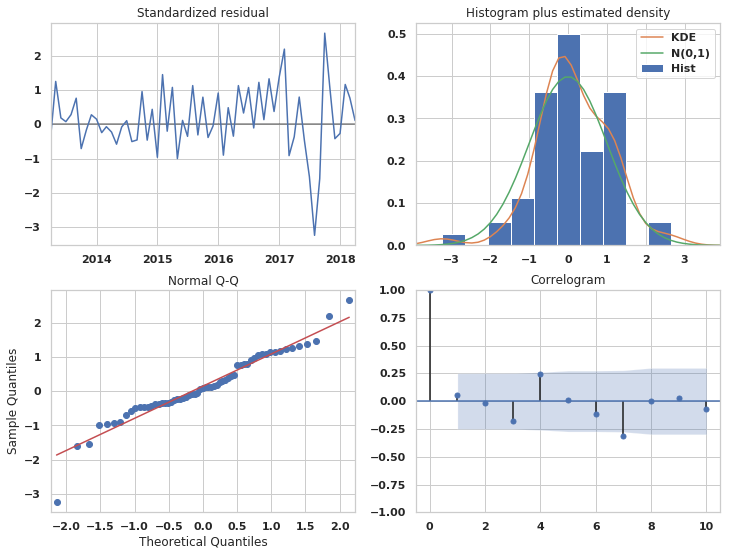

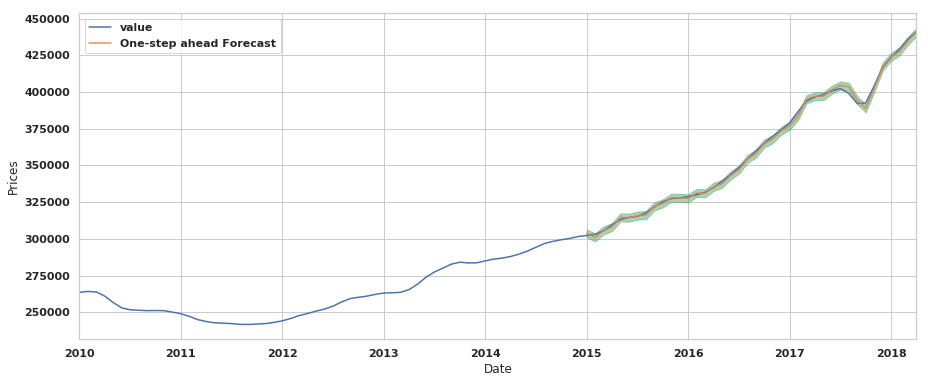

The Mean Squared Error of our forecasts is 2465896.38


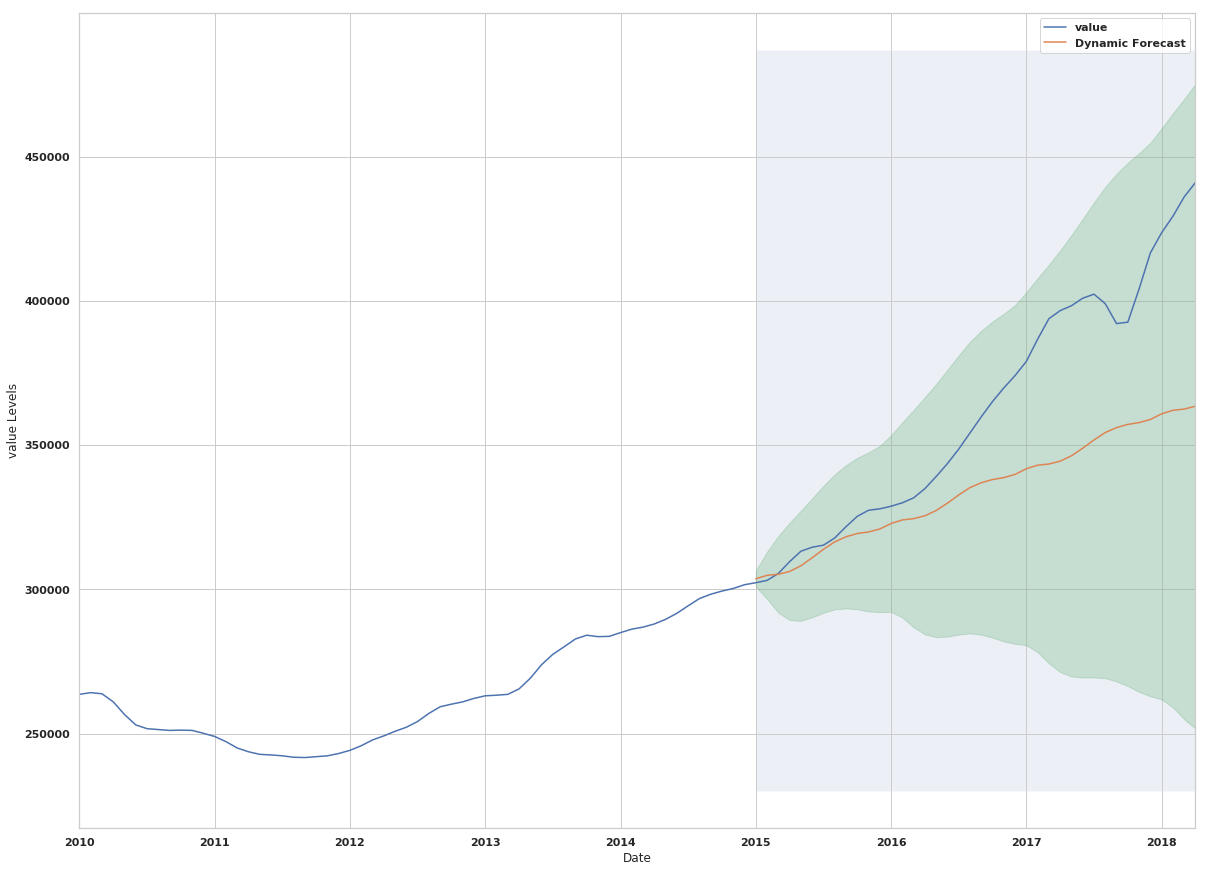

The Mean Squared Error of our forecasts is 1279324411.39


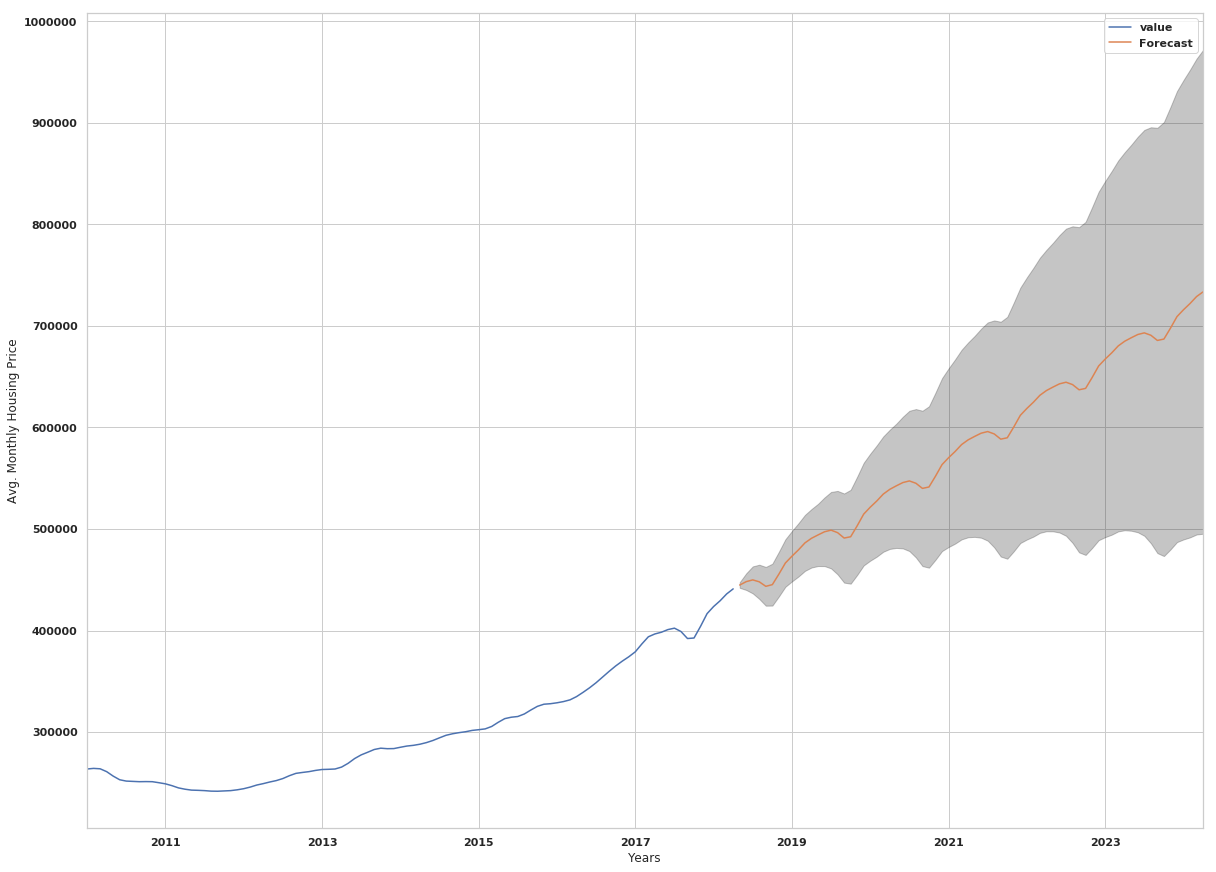

In [96]:
model_selection = [(2,1,1), (2,1,0,12)]

model(current_zip, model_selection[0], model_selection[1])

In [97]:
new_rate(83702, (2,1,1), (2,1,0,12), zcs['zip_83702'])

{'prior_rate': 0.06621284839599413,
 'yr1': 460918.6701951841,
 'yr2': 509167.2340543968,
 'yr3': 557863.8282992463,
 'yr4': 606428.3272079412,
 'yr5': 655033.1645551848,
 'yr6': 703625.8172038536,
 'pred_ar': 0.08834121210760154}

83705

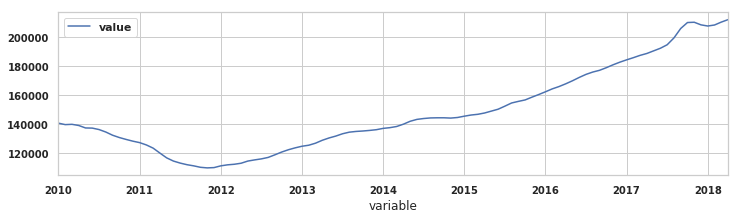

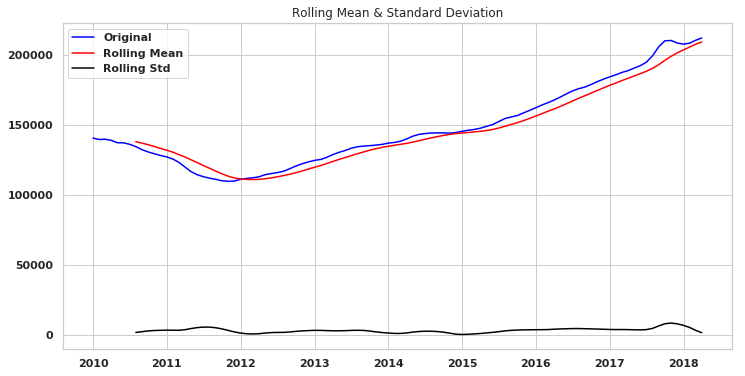

Results of Dickey-Fuller Test:
Test Statistic                  0.550711
p-value                         0.986336
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64


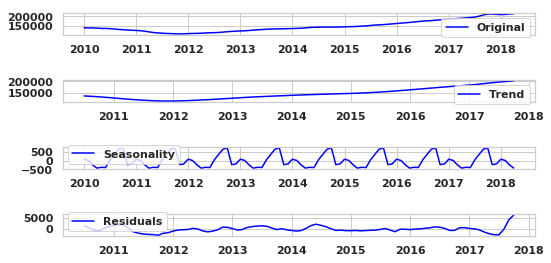

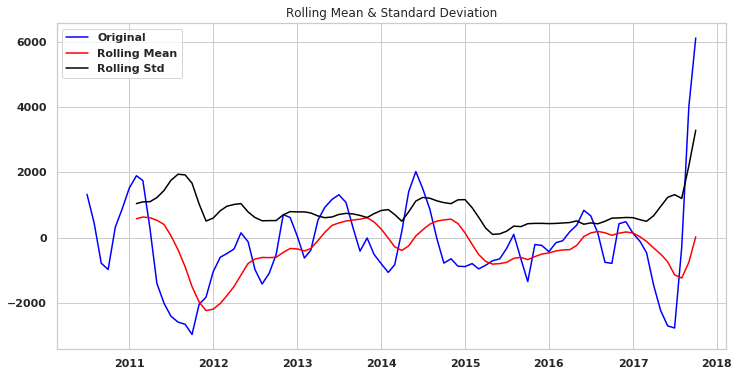

Results of Dickey-Fuller Test:
Test Statistic                 -5.410655
p-value                         0.000003
#Lags Used                      1.000000
Number of Observations Used    86.000000
Critical Value (1%)            -3.508783
Critical Value (5%)            -2.895784
Critical Value (10%)           -2.585038
dtype: float64


In [98]:
current_zip = zcs['zip_83705']

current_zip.plot(figsize=(12,3), linewidth=1.5, fontsize=10);

stationarity_check(current_zip);

decomp(current_zip)

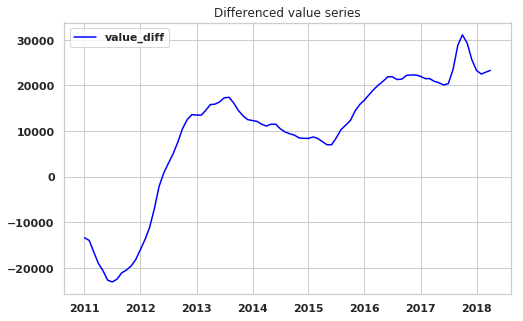

In [99]:
first_diff(current_zip)

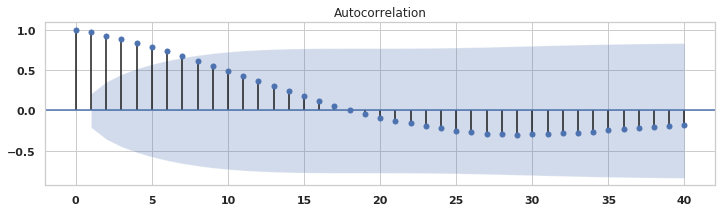

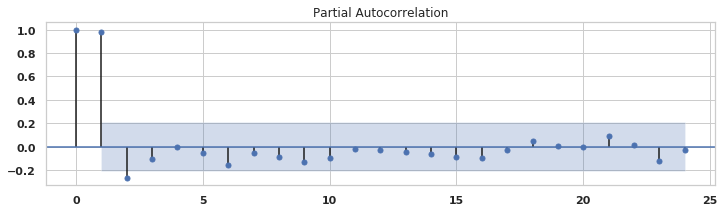

In [100]:
acf_pacf(zip_diff)

In [102]:
models = sarima_configs(2,1,3,2,1,2,12)

trial_models(current_zip)

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =2643.6193157765633
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =219928.4494864377
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =3424.2201708303896
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =1944.717826976112
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =1663.860056659848
ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =2539.1147064677707
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1928.3679522779066
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1876.6887799715864
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =1687.194636945318
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =1648.055492779653
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =1616.1266809921233
ARIMA (0, 0, 0) x (1, 1, 2, 12)12 : AIC Calculated =2273.9983007075966
ARIMA (0, 0, 0) x (2, 0, 0, 12)12 : AIC Calculated =1560.9665788410043
ARIMA (0, 0, 0) x (2, 0, 1, 12)12 : AIC Calculated =2313.7282293976955
ARIMA (0, 0

ARIMA (0, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =1164.8364855091668
ARIMA (0, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =2512.641803192557
ARIMA (0, 1, 2) x (2, 0, 0, 12)12 : AIC Calculated =1188.6367793497702
ARIMA (0, 1, 2) x (2, 0, 1, 12)12 : AIC Calculated =1190.4155396261233
ARIMA (0, 1, 2) x (2, 0, 2, 12)12 : AIC Calculated =1140.2759112402093
ARIMA (0, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =1013.9142295037436
ARIMA (0, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =1015.7668242842883
ARIMA (0, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =2322.554636209603
ARIMA (0, 1, 3) x (0, 0, 0, 12)12 : AIC Calculated =1515.67650258829
ARIMA (0, 1, 3) x (0, 0, 1, 12)12 : AIC Calculated =1307.8734123454265
ARIMA (0, 1, 3) x (0, 0, 2, 12)12 : AIC Calculated =1120.8009082086833
ARIMA (0, 1, 3) x (0, 1, 0, 12)12 : AIC Calculated =1338.2503873499782
ARIMA (0, 1, 3) x (0, 1, 1, 12)12 : AIC Calculated =1137.3695598844258
ARIMA (0, 1, 3) x (0, 1, 2, 12)12 : AIC Calculated =2473.6923692960545
ARIMA (0, 

ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =1348.789013880139
ARIMA (1, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =1160.9098237241822
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =1400.136554117658
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =1185.0419777459776
ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =2388.3081511838764
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =1365.1046423585628
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =1346.3477340022177
ARIMA (1, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =1161.8626724159176
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =1201.7185688268517
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =1184.5361900778341
ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =2403.404002054352
ARIMA (1, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =1177.0189413775938
ARIMA (1, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =1178.319014308004
ARIMA (1, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =1163.8461249227464
ARIMA (1, 

ARIMA (2, 0, 3) x (1, 1, 0, 12)12 : AIC Calculated =1193.4146022243242
ARIMA (2, 0, 3) x (1, 1, 1, 12)12 : AIC Calculated =1160.9996372317291
ARIMA (2, 0, 3) x (1, 1, 2, 12)12 : AIC Calculated =2115.473995920051
ARIMA (2, 0, 3) x (2, 0, 0, 12)12 : AIC Calculated =1187.2061559119982
ARIMA (2, 0, 3) x (2, 0, 1, 12)12 : AIC Calculated =1239.8824596387726
ARIMA (2, 0, 3) x (2, 0, 2, 12)12 : AIC Calculated =1125.0168926805077
ARIMA (2, 0, 3) x (2, 1, 0, 12)12 : AIC Calculated =990.4130218832627
ARIMA (2, 0, 3) x (2, 1, 1, 12)12 : AIC Calculated =991.0887707394193
ARIMA (2, 0, 3) x (2, 1, 2, 12)12 : AIC Calculated =2167.1842984452464
ARIMA (2, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =1557.82613762641
ARIMA (2, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =1375.9968006378294
ARIMA (2, 1, 0) x (0, 0, 2, 12)12 : AIC Calculated =1191.4152261589827
ARIMA (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =1387.569912748503
ARIMA (2, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =1209.0309636344423
ARIMA (2, 1,

pdq           pdqs         aic
411  (2, 1, 2)  (2, 1, 0, 12)  969.888454
429  (2, 1, 3)  (2, 1, 0, 12)  973.609476
430  (2, 1, 3)  (2, 1, 1, 12)  974.672871
412  (2, 1, 2)  (2, 1, 1, 12)  975.679193
393  (2, 1, 1)  (2, 1, 0, 12)  976.181825
394  (2, 1, 1)  (2, 1, 1, 12)  978.189218
375  (2, 1, 0)  (2, 1, 0, 12)  981.097744
376  (2, 1, 0)  (2, 1, 1, 12)  983.084292
267  (1, 1, 2)  (2, 1, 0, 12)  988.090869
285  (1, 1, 3)  (2, 1, 0, 12)  988.214220

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8793      0.123      7.122      0.000       0.637       1.121
ar.L2         -0.4248      0.139     -3.061      0.002      -0.697      -0.153
ma.L1          0.5319      0.157      3.398      0.001       0.225       0.839
ar.S.L12      -0.3476      0.212     -1.640      0.101      -0.763       0.068
ar.S.L24       0.0298      0.071      0.420      0.675      -0.110       0.169
sigma2      4.293e+05   7.33e+04      5.855      0.000    2.86e+05    5.73e+05


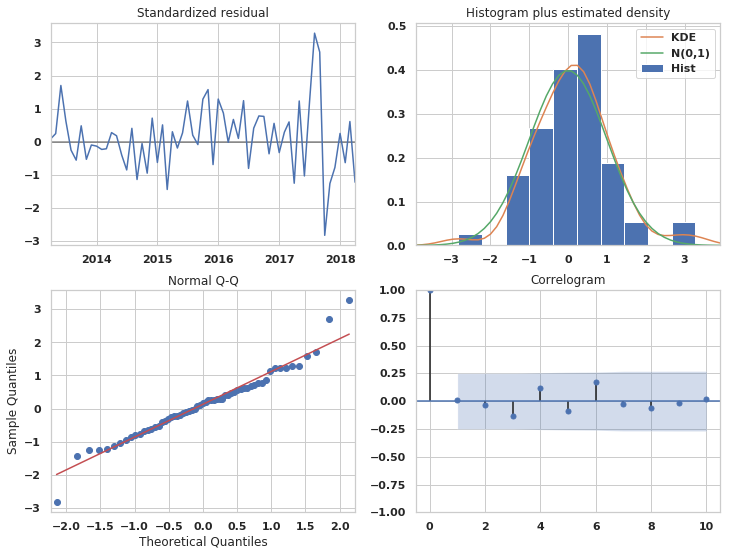

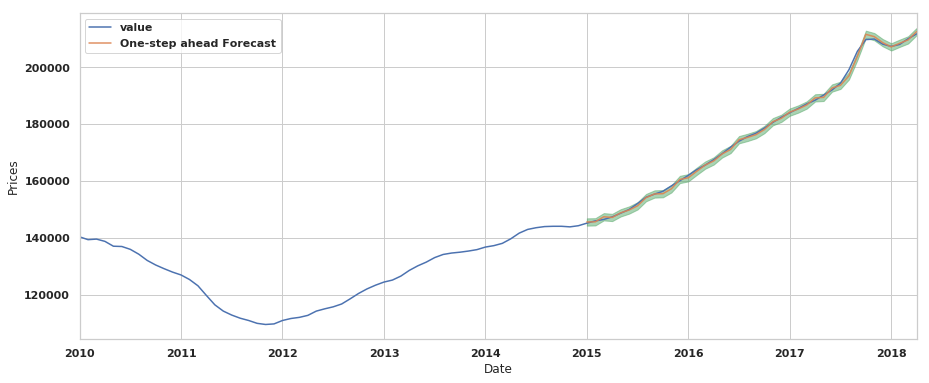

The Mean Squared Error of our forecasts is 565131.1


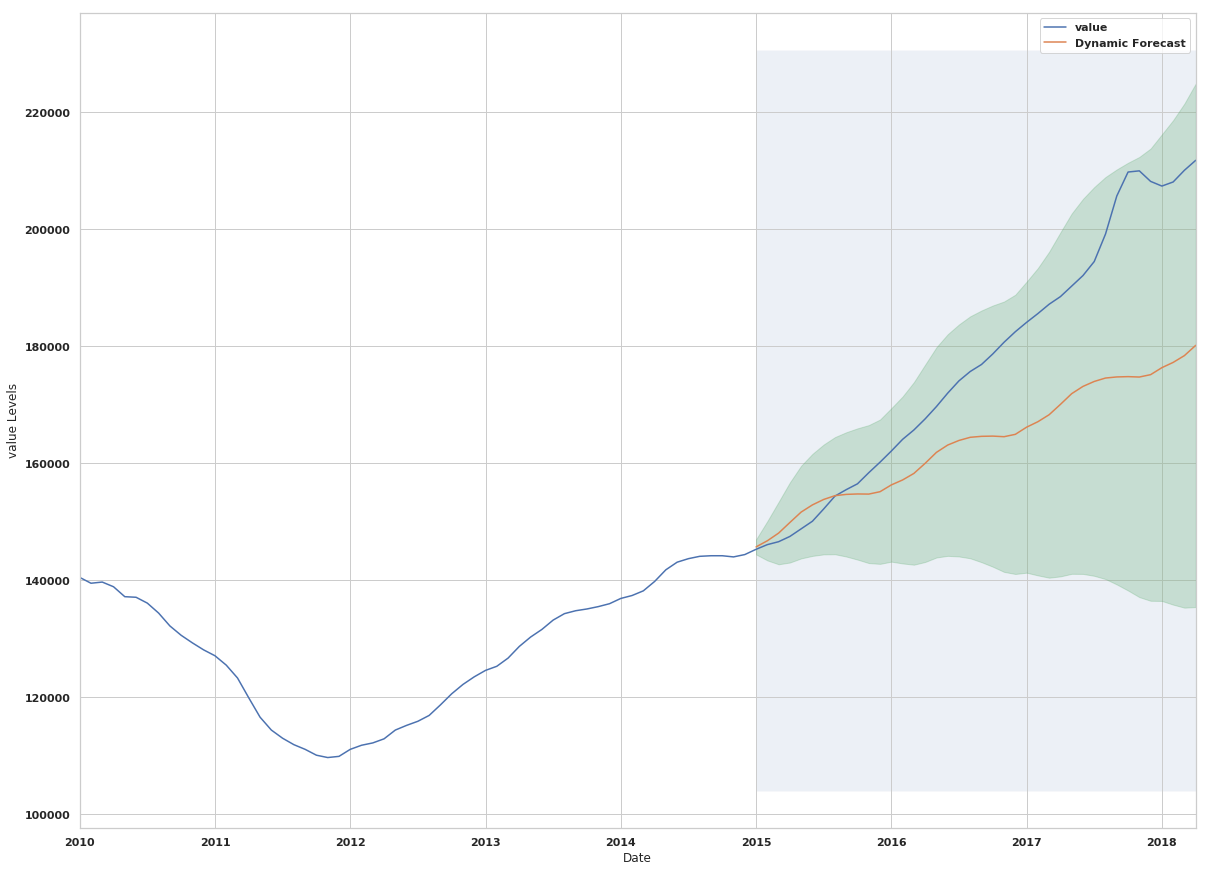

The Mean Squared Error of our forecasts is 326731225.52


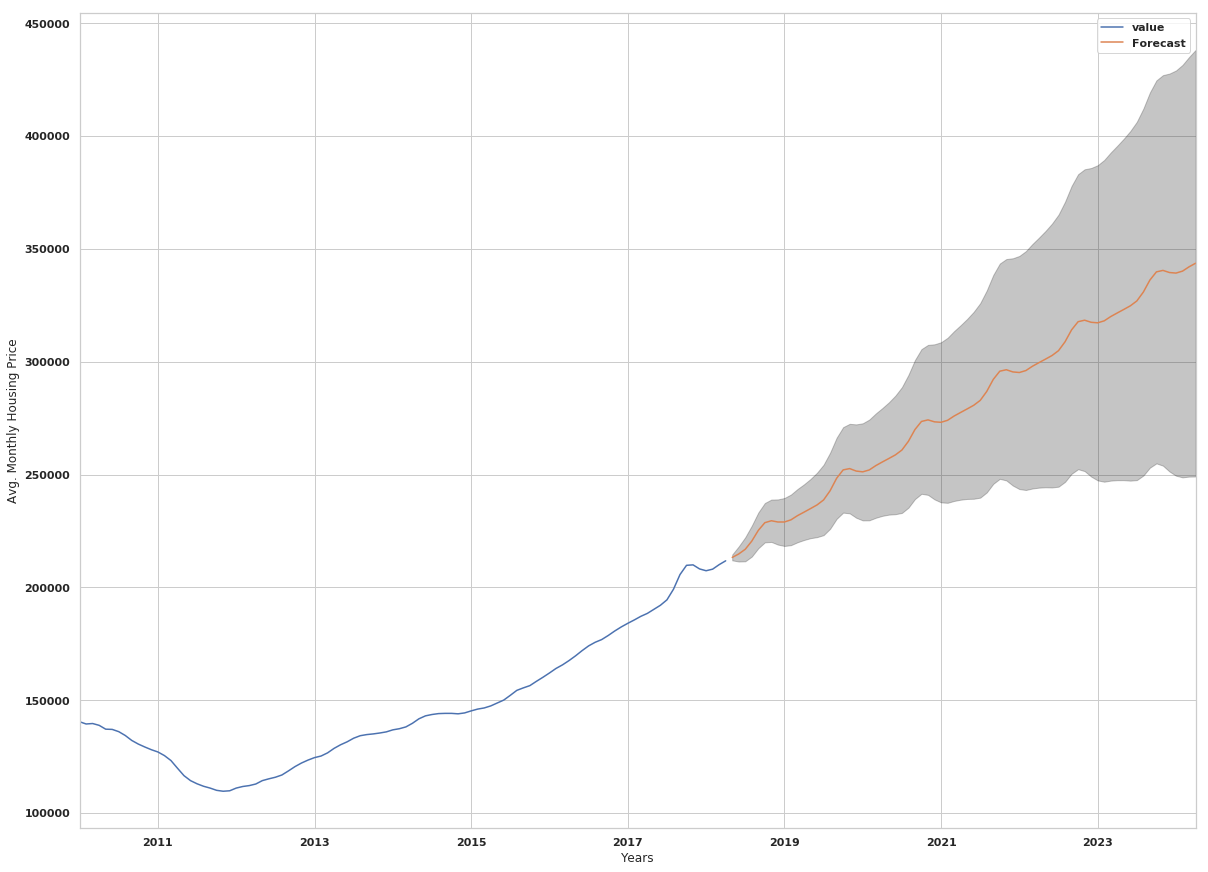

In [104]:
model_selection = [(2,1,1), (2,1,0,12)]

model(current_zip, model_selection[0], model_selection[1])

In [105]:
new_rate(83705, (2,1,1), (2,1,0,12), zcs['zip_83705'])

{'prior_rate': 0.05907613211399325,
 'yr1': 225181.94980145016,
 'yr2': 247552.09837587565,
 'yr3': 269441.3939909705,
 'yr4': 291531.33044050523,
 'yr5': 313537.1637179314,
 'yr6': 335578.22330046067,
 'pred_ar': 0.08310628074161029}

80631

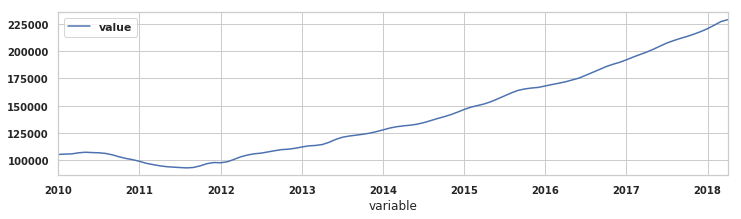

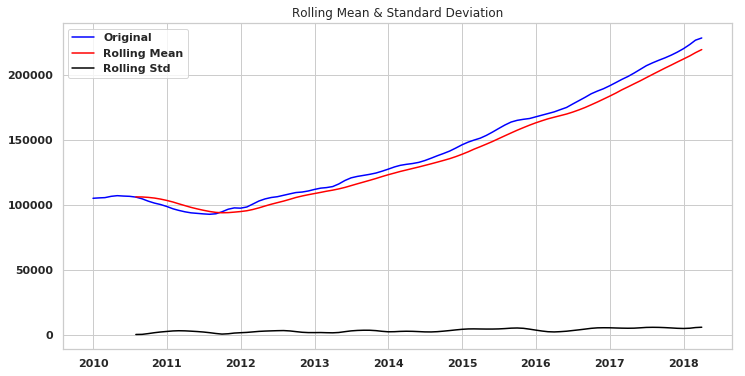

Results of Dickey-Fuller Test:
Test Statistic                  1.443044
p-value                         0.997301
#Lags Used                      9.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64


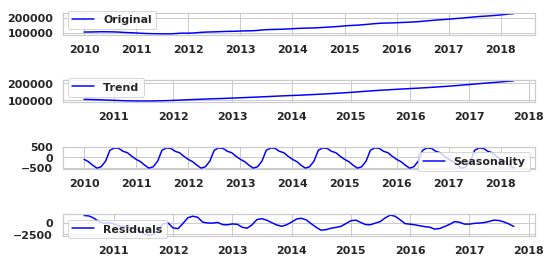

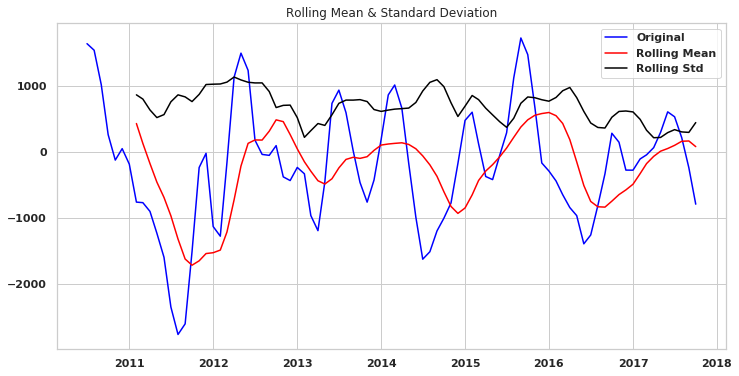

Results of Dickey-Fuller Test:
Test Statistic                 -3.578390
p-value                         0.006188
#Lags Used                      6.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


In [106]:
current_zip = zcs['zip_80631']

current_zip.plot(figsize=(12,3), linewidth=1.5, fontsize=10);

stationarity_check(current_zip);

decomp(current_zip)

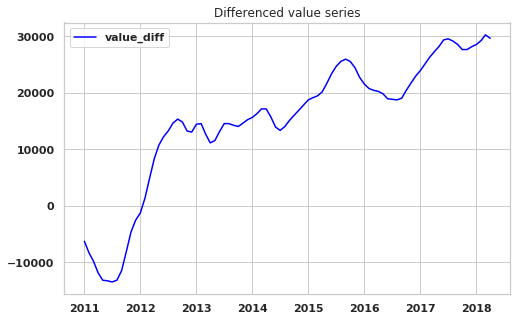

In [107]:
first_diff(current_zip)

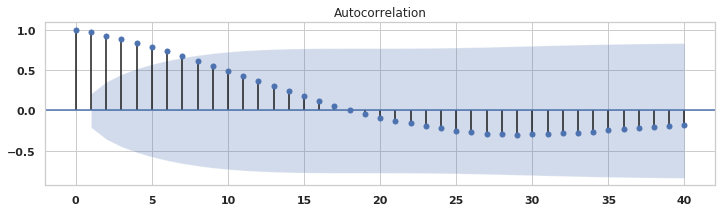

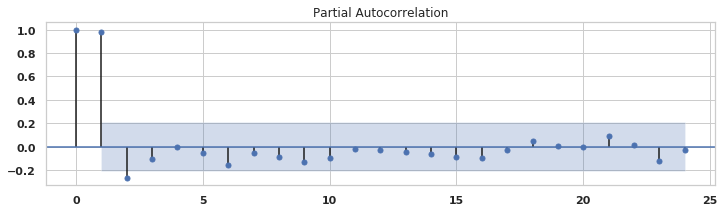

In [108]:
acf_pacf(zip_diff)

In [110]:
models = sarima_configs(2,1,2,2,1,2,12)

trial_models(current_zip)

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =2638.8465421127075
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =135068.32653822398
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =3398.3669616983725
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =1964.9913091231385
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =1693.83977819276
ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =2034.6257209998723
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1864.4987597363324
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1712.3943139956716
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =1412.1195643564947
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =1618.7521599373501
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =1486.8690448757632
ARIMA (0, 0, 0) x (1, 1, 2, 12)12 : AIC Calculated =2534.064690602796
ARIMA (0, 0, 0) x (2, 0, 0, 12)12 : AIC Calculated =1458.9853192830933
ARIMA (0, 0, 0) x (2, 0, 1, 12)12 : AIC Calculated =1473.413807363209
ARIMA (0, 

ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =1258.4687398721223
ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =1403.8258973211452
ARIMA (1, 0, 0) x (1, 1, 2, 12)12 : AIC Calculated =4464.281944455412
ARIMA (1, 0, 0) x (2, 0, 0, 12)12 : AIC Calculated =1222.1545019832135
ARIMA (1, 0, 0) x (2, 0, 1, 12)12 : AIC Calculated =1220.9225328171585
ARIMA (1, 0, 0) x (2, 0, 2, 12)12 : AIC Calculated =1207.4520869083635
ARIMA (1, 0, 0) x (2, 1, 0, 12)12 : AIC Calculated =1045.8865218618853
ARIMA (1, 0, 0) x (2, 1, 1, 12)12 : AIC Calculated =1047.4416797186475
ARIMA (1, 0, 0) x (2, 1, 2, 12)12 : AIC Calculated =4537.440388875109
ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =1566.483500796303
ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =1347.5821524704863
ARIMA (1, 0, 1) x (0, 0, 2, 12)12 : AIC Calculated =1521.1671932280187
ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =1461.258305211441
ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =1191.7338270581658
ARIMA (1, 

ARIMA (2, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =1506.0690903493905
ARIMA (2, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =1293.4892703388896
ARIMA (2, 0, 1) x (0, 0, 2, 12)12 : AIC Calculated =1820.0674206524839
ARIMA (2, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =1391.892245567913
ARIMA (2, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =1203.0817621916044
ARIMA (2, 0, 1) x (0, 1, 2, 12)12 : AIC Calculated =2003.6590031933072
ARIMA (2, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =1293.2495507980118
ARIMA (2, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =1292.0276079577275
ARIMA (2, 0, 1) x (1, 0, 2, 12)12 : AIC Calculated =1110.971138858647
ARIMA (2, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =1155.1694891760353
ARIMA (2, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =1227.5777583750191
ARIMA (2, 0, 1) x (1, 1, 2, 12)12 : AIC Calculated =4744.233359690109
ARIMA (2, 0, 1) x (2, 0, 0, 12)12 : AIC Calculated =1147.5039184275192
ARIMA (2, 0, 1) x (2, 0, 1, 12)12 : AIC Calculated =1122.8067323745047
ARIMA (2,

pdq           pdqs         aic
321  (2, 1, 2)  (2, 1, 0, 12)  926.318724
303  (2, 1, 1)  (2, 1, 0, 12)  926.738757
322  (2, 1, 2)  (2, 1, 1, 12)  927.438469
304  (2, 1, 1)  (2, 1, 1, 12)  928.709634
285  (2, 1, 0)  (2, 1, 0, 12)  929.128456
286  (2, 1, 0)  (2, 1, 1, 12)  932.442294
213  (1, 1, 2)  (2, 1, 0, 12)  939.909969
195  (1, 1, 1)  (2, 1, 0, 12)  943.633827
196  (1, 1, 1)  (2, 1, 1, 12)  945.631620
214  (1, 1, 2)  (2, 1, 1, 12)  948.551321

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1826      0.126      9.362      0.000       0.935       1.430
ar.L2         -0.4848      0.128     -3.790      0.000      -0.736      -0.234
ar.S.L12      -0.4428      0.142     -3.108      0.002      -0.722      -0.164
ar.S.L24      -0.0386      0.122     -0.316      0.752      -0.278       0.201
sigma2      2.048e+05   3.53e+04      5.806      0.000    1.36e+05    2.74e+05


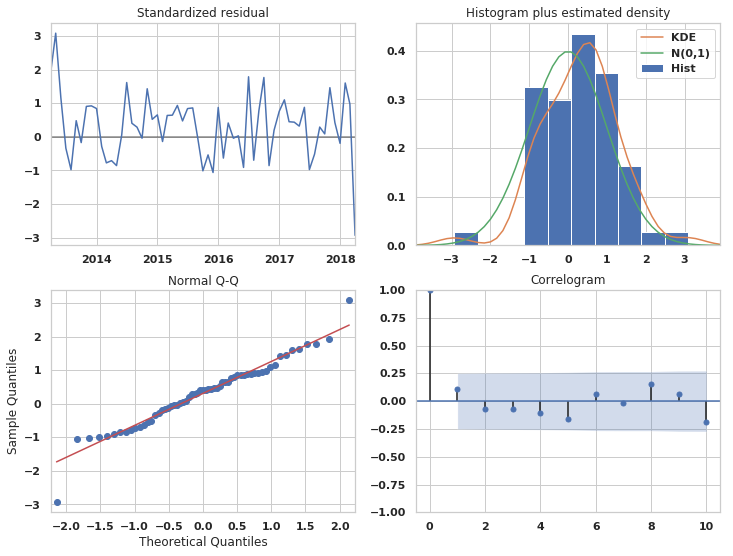

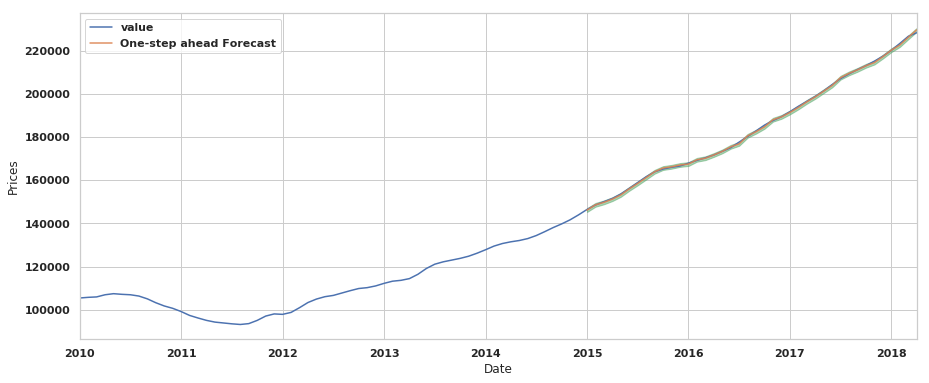

The Mean Squared Error of our forecasts is 182021.03


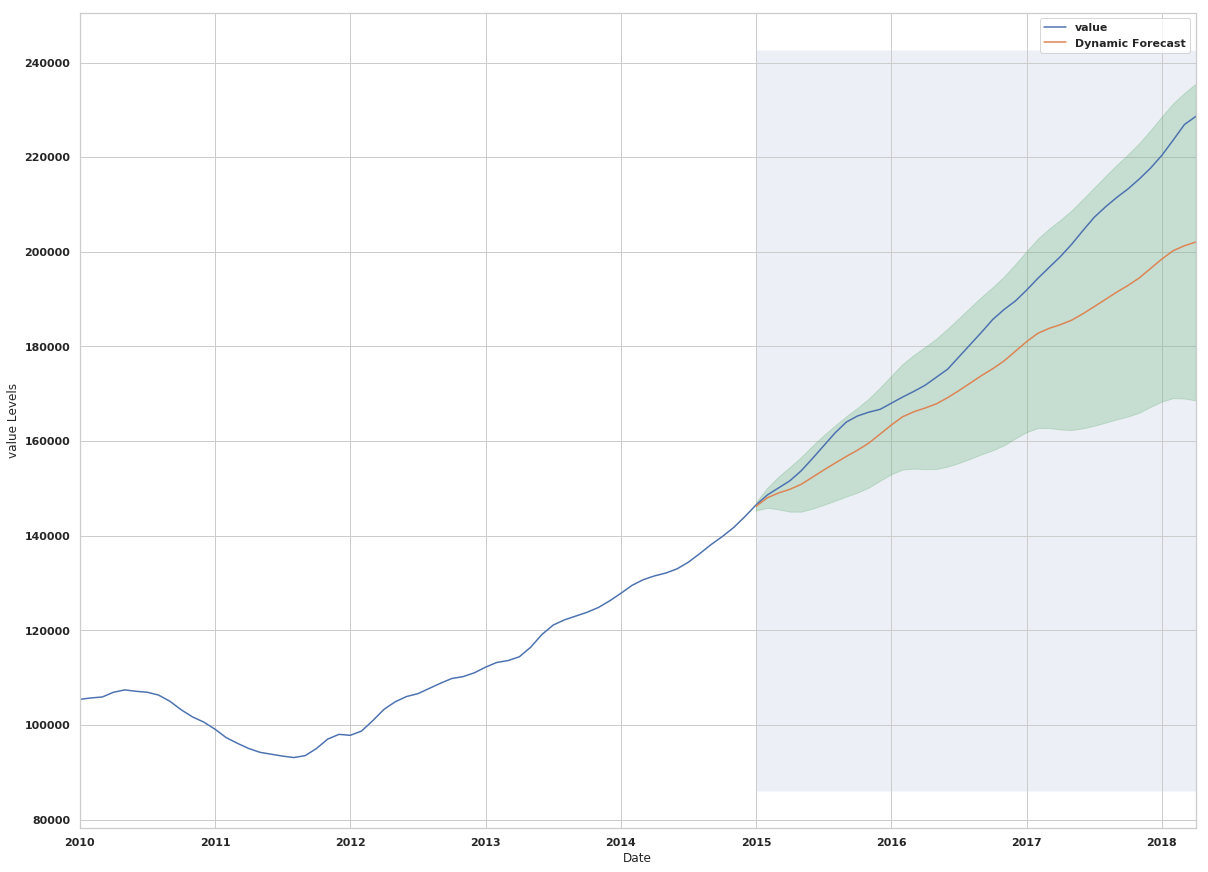

The Mean Squared Error of our forecasts is 174559004.17


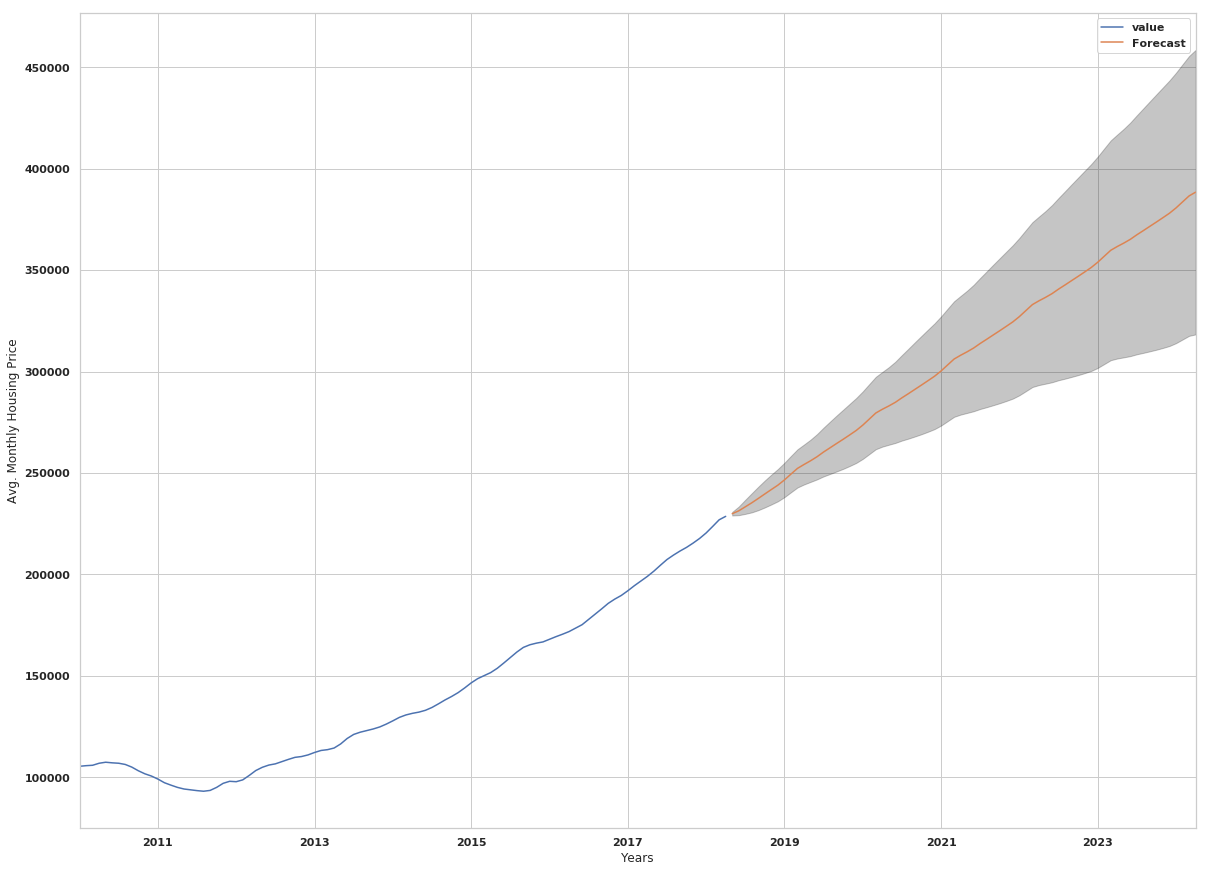

In [112]:
model_selection = [(2,1,0), (2,1,0,12)]

model(current_zip, model_selection[0], model_selection[1])

In [113]:
new_rate(80631, (2,1,0), (2,1,0,12), zcs['zip_80631'])

{'prior_rate': 0.10358596127437543,
 'yr1': 241253.5060021596,
 'yr2': 268205.069422513,
 'yr3': 294934.32320488774,
 'yr4': 321734.1284892768,
 'yr5': 348511.27223974036,
 'yr6': 375295.7281580318,
 'pred_ar': 0.09246459195413718}

80620

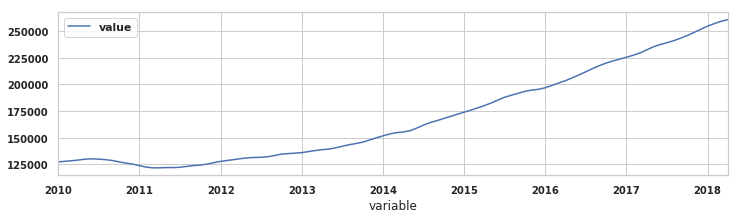

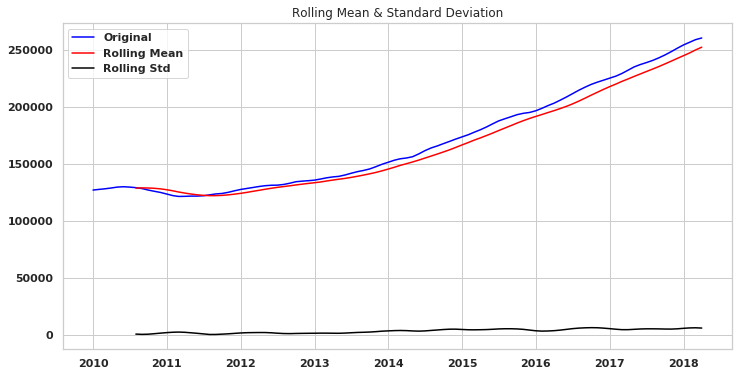

Results of Dickey-Fuller Test:
Test Statistic                  0.505774
p-value                         0.985048
#Lags Used                      6.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


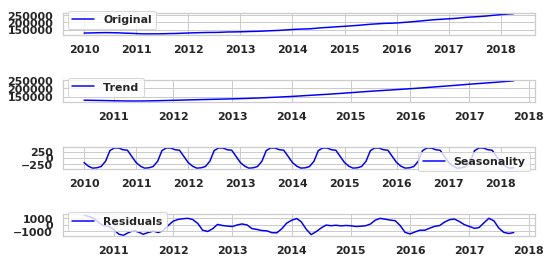

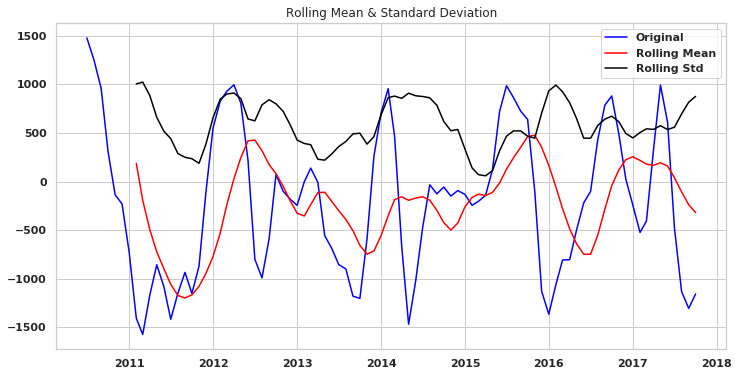

Results of Dickey-Fuller Test:
Test Statistic                 -3.794299
p-value                         0.002966
#Lags Used                      6.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


In [114]:
current_zip = zcs['zip_80620']

current_zip.plot(figsize=(12,3), linewidth=1.5, fontsize=10);

stationarity_check(current_zip);

decomp(current_zip)

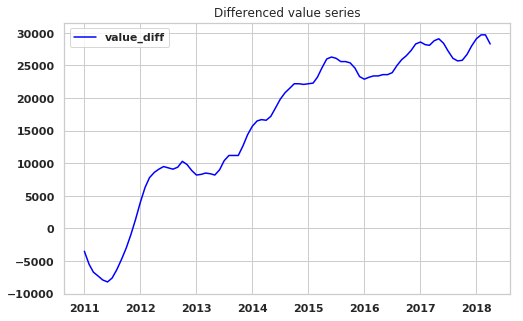

In [115]:
first_diff(current_zip)

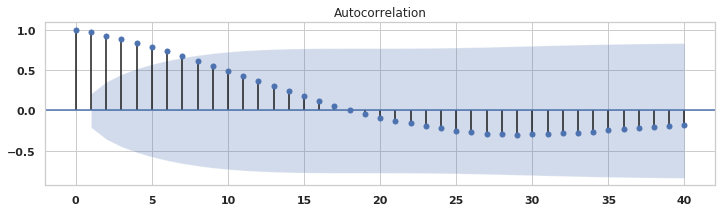

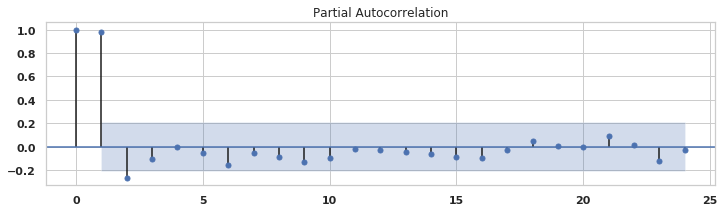

In [116]:
acf_pacf(zip_diff)

In [118]:
models = sarima_configs(2,1,3,2,1,2,12)

trial_models(current_zip)

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =2672.8822553126615
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =2308.786156022913
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =3473.9186913611925
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =1971.6326683741522
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =1711.3666519166723
ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =2408.4991016552167
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1847.8346280791498
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1744.376220705074
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =1484.0068219512682
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =1567.0761453935072
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =1554.2009027069132
ARIMA (0, 0, 0) x (1, 1, 2, 12)12 : AIC Calculated =2291.391818555096
ARIMA (0, 0, 0) x (2, 0, 0, 12)12 : AIC Calculated =1443.4577716405604
ARIMA (0, 0, 0) x (2, 0, 1, 12)12 : AIC Calculated =1524.954457085673
ARIMA (0, 

ARIMA (0, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =1157.5783620440848
ARIMA (0, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =1105.5098980854837
ARIMA (0, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =5388.00764630563
ARIMA (0, 1, 2) x (2, 0, 0, 12)12 : AIC Calculated =1137.5637744907126
ARIMA (0, 1, 2) x (2, 0, 1, 12)12 : AIC Calculated =1159.6981463936913
ARIMA (0, 1, 2) x (2, 0, 2, 12)12 : AIC Calculated =1216.6031674677913
ARIMA (0, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =943.4202945040121
ARIMA (0, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =950.1031015421867
ARIMA (0, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =2143.6029099998113
ARIMA (0, 1, 3) x (0, 0, 0, 12)12 : AIC Calculated =1450.6165502779775
ARIMA (0, 1, 3) x (0, 0, 1, 12)12 : AIC Calculated =1266.1178060367752
ARIMA (0, 1, 3) x (0, 0, 2, 12)12 : AIC Calculated =1067.9071314051257
ARIMA (0, 1, 3) x (0, 1, 0, 12)12 : AIC Calculated =1263.2953968912047
ARIMA (0, 1, 3) x (0, 1, 1, 12)12 : AIC Calculated =1064.1798339248412
ARIMA (0, 

ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =1250.6031906337498
ARIMA (1, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =1079.121682050332
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =1308.5005427569968
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =1106.4296940855045
ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =1626.5627067898017
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =1266.2913718214195
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =1252.4462726785005
ARIMA (1, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =1076.8605465244455
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =1125.1670263263484
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =1101.8237878180246
ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =2225.880870189697
ARIMA (1, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =1093.2962725224515
ARIMA (1, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =1091.3404580271042
ARIMA (1, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =1082.4110685009853
ARIMA (1

ARIMA (2, 0, 3) x (1, 1, 0, 12)12 : AIC Calculated =1119.5811561445603
ARIMA (2, 0, 3) x (1, 1, 1, 12)12 : AIC Calculated =1150.8582944799255
ARIMA (2, 0, 3) x (1, 1, 2, 12)12 : AIC Calculated =2659.723020326002
ARIMA (2, 0, 3) x (2, 0, 0, 12)12 : AIC Calculated =1071.977775932248
ARIMA (2, 0, 3) x (2, 0, 1, 12)12 : AIC Calculated =1136.367253283303
ARIMA (2, 0, 3) x (2, 0, 2, 12)12 : AIC Calculated =1220.173101990848
ARIMA (2, 0, 3) x (2, 1, 0, 12)12 : AIC Calculated =923.6260120656201
ARIMA (2, 0, 3) x (2, 1, 1, 12)12 : AIC Calculated =951.0690410938165
ARIMA (2, 0, 3) x (2, 1, 2, 12)12 : AIC Calculated =2649.8191996204578
ARIMA (2, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =1433.3682222700804
ARIMA (2, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =1275.8959820871764
ARIMA (2, 1, 0) x (0, 0, 2, 12)12 : AIC Calculated =1099.3526016980027
ARIMA (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =1296.36711449369
ARIMA (2, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =1125.909721948517
ARIMA (2, 1, 0)

pdq           pdqs         aic
429  (2, 1, 3)  (2, 1, 0, 12)  903.633997
430  (2, 1, 3)  (2, 1, 1, 12)  905.041160
412  (2, 1, 2)  (2, 1, 1, 12)  908.627980
393  (2, 1, 1)  (2, 1, 0, 12)  916.134115
411  (2, 1, 2)  (2, 1, 0, 12)  917.640805
394  (2, 1, 1)  (2, 1, 1, 12)  917.967026
285  (1, 1, 3)  (2, 1, 0, 12)  920.743056
267  (1, 1, 2)  (2, 1, 0, 12)  922.214243
339  (2, 0, 2)  (2, 1, 0, 12)  922.560558
286  (1, 1, 3)  (2, 1, 1, 12)  922.939304

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9346      0.249      3.754      0.000       0.447       1.423
ar.L2         -0.3238      0.244     -1.330      0.184      -0.801       0.154
ma.L1          0.5459      0.196      2.790      0.005       0.162       0.929
ar.S.L12      -0.3793      0.101     -3.740      0.000      -0.578      -0.181
ar.S.L24       0.0121      0.021      0.571      0.568      -0.030       0.054
sigma2      1.601e+05   3.18e+04      5.040      0.000    9.79e+04    2.22e+05


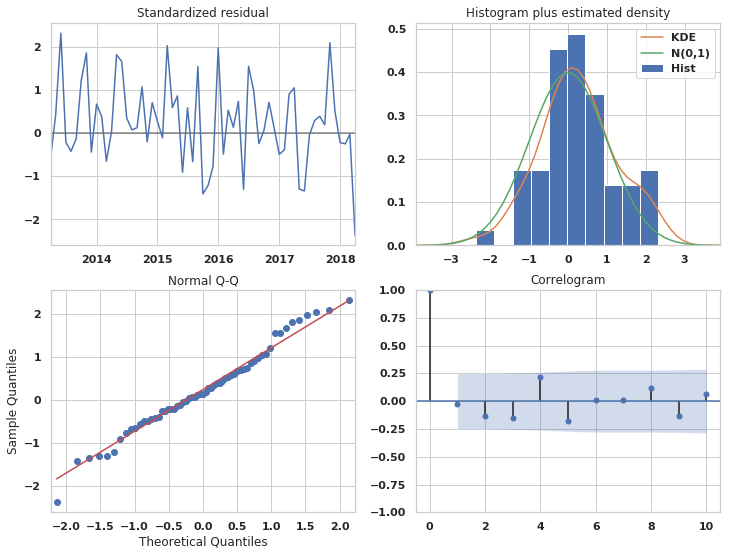

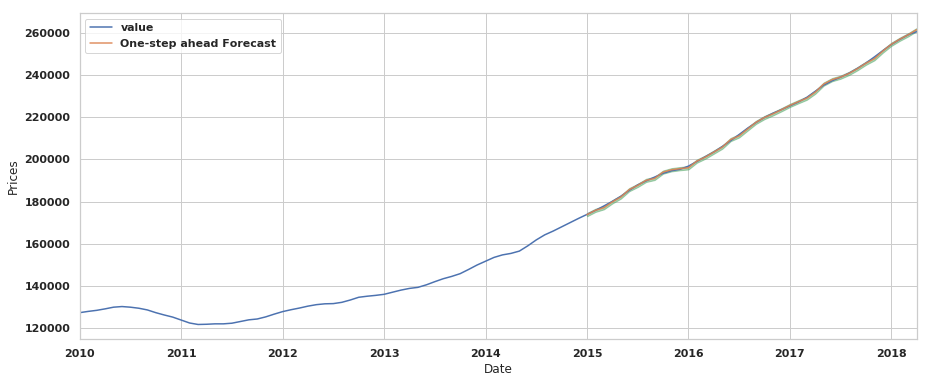

The Mean Squared Error of our forecasts is 162797.16


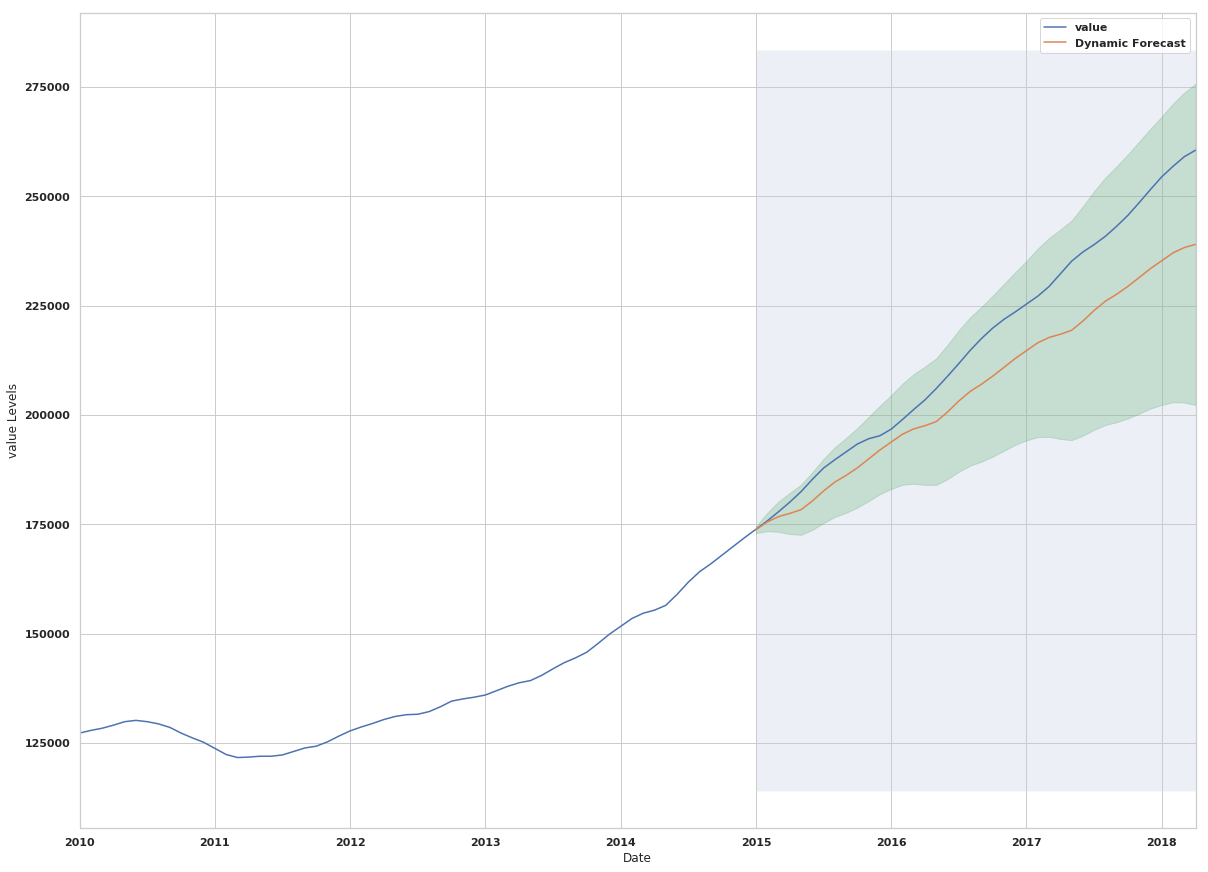

The Mean Squared Error of our forecasts is 132476456.3


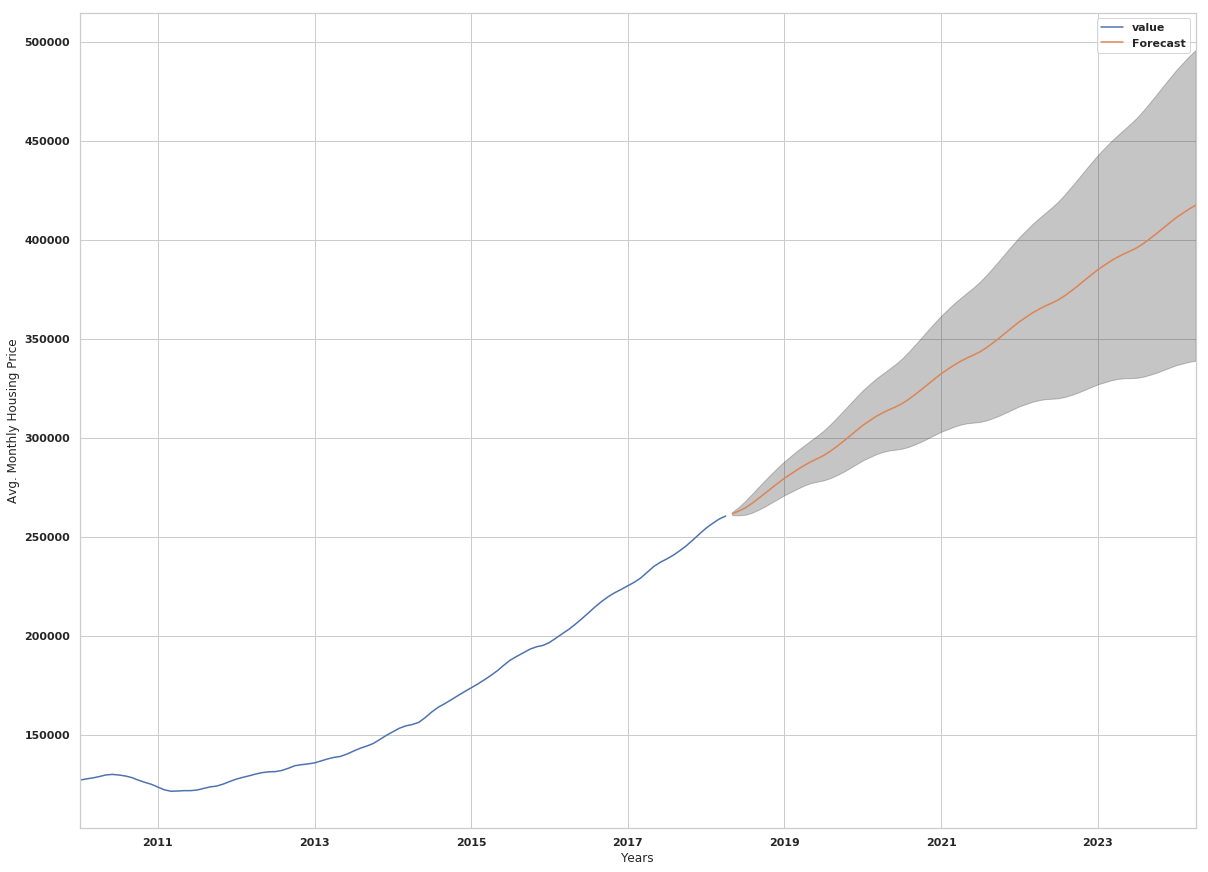

In [120]:
model_selection = [(2,1,1), (2,1,0,12)]

model(current_zip, model_selection[0], model_selection[1])

In [121]:
new_rate(80620, (2,1,1), (2,1,0,12), zcs['zip_80620'])

{'prior_rate': 0.09412343626794462,
 'yr1': 273460.52996550285,
 'yr2': 299896.1629407327,
 'yr3': 326044.37654277246,
 'yr4': 352310.00713477284,
 'yr5': 378527.6120315615,
 'yr6': 404764.8585826484,
 'pred_ar': 0.08163006769853197}

32163

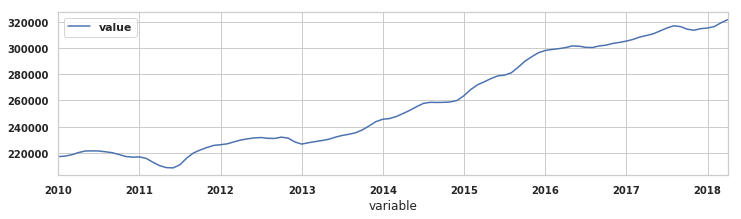

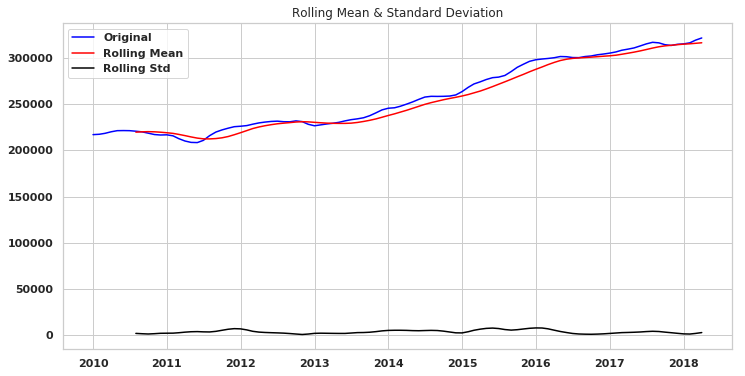

Results of Dickey-Fuller Test:
Test Statistic                  0.257350
p-value                         0.975301
#Lags Used                      7.000000
Number of Observations Used    92.000000
Critical Value (1%)            -3.503515
Critical Value (5%)            -2.893508
Critical Value (10%)           -2.583824
dtype: float64


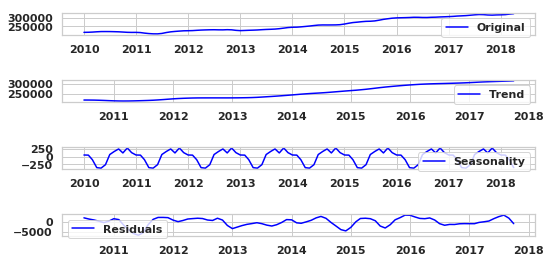

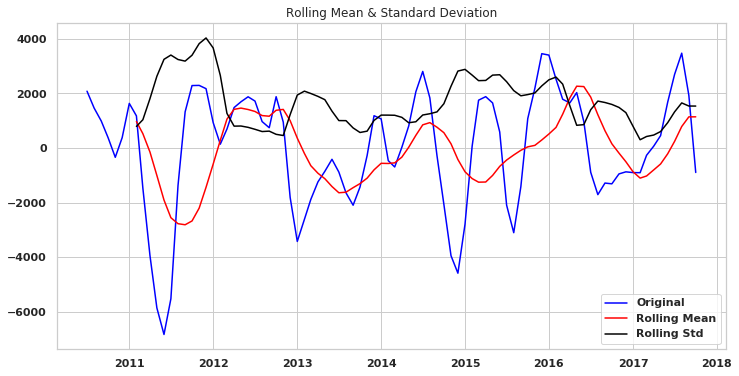

Results of Dickey-Fuller Test:
Test Statistic                 -4.568921
p-value                         0.000147
#Lags Used                      6.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


In [122]:
current_zip = zcs['zip_32163']

current_zip.plot(figsize=(12,3), linewidth=1.5, fontsize=10);

stationarity_check(current_zip);

decomp(current_zip)

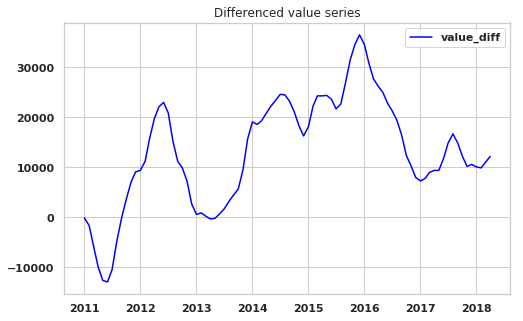

In [123]:
first_diff(current_zip)

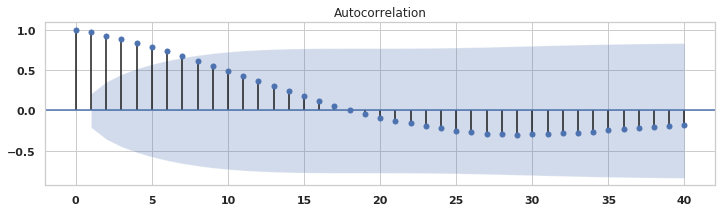

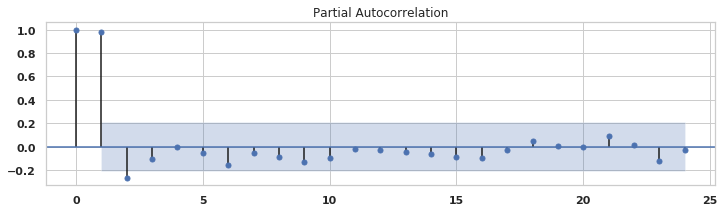

In [124]:
acf_pacf(zip_diff)

In [126]:
models = sarima_configs(2,1,3,2,1,2,12)

trial_models(current_zip)

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =2752.6736064790093
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =2373.0852626887613
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =3641.9060342553794
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =1946.599392394814
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =1688.2590285454037
ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =2423.6039590512055
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1885.6852868135365
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1834.232432301959
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =1606.040127445699
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =1670.6318070588693
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =2211.0885342914917
ARIMA (0, 0, 0) x (1, 1, 2, 12)12 : AIC Calculated =2072.3104708357514
ARIMA (0, 0, 0) x (2, 0, 0, 12)12 : AIC Calculated =1605.7445082384259
ARIMA (0, 0, 0) x (2, 0, 1, 12)12 : AIC Calculated =1606.3271513004697
ARIMA (0,

ARIMA (0, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =1252.8651323950166
ARIMA (0, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =2207.9520748772375
ARIMA (0, 1, 2) x (2, 0, 0, 12)12 : AIC Calculated =1227.0814887776428
ARIMA (0, 1, 2) x (2, 0, 1, 12)12 : AIC Calculated =1230.0901180772087
ARIMA (0, 1, 2) x (2, 0, 2, 12)12 : AIC Calculated =1241.2170725105773
ARIMA (0, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =1065.6156972365602
ARIMA (0, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =1062.8698387657118
ARIMA (0, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =2136.021222498252
ARIMA (0, 1, 3) x (0, 0, 0, 12)12 : AIC Calculated =1547.9487209816668
ARIMA (0, 1, 3) x (0, 0, 1, 12)12 : AIC Calculated =1359.3864544608612
ARIMA (0, 1, 3) x (0, 0, 2, 12)12 : AIC Calculated =1170.7261449819184
ARIMA (0, 1, 3) x (0, 1, 0, 12)12 : AIC Calculated =1440.5693440079206
ARIMA (0, 1, 3) x (0, 1, 1, 12)12 : AIC Calculated =1209.6289257157828
ARIMA (0, 1, 3) x (0, 1, 2, 12)12 : AIC Calculated =2393.609375437097
ARIMA (0

ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =1403.3859277990416
ARIMA (1, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =1202.9052125726225
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =1495.4953742110304
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =1261.1778706061507
ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =2603.4317678104185
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =1419.2566917780173
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =1400.7460460045231
ARIMA (1, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =1204.4929149185825
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =1275.450694268007
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =1255.4562231815084
ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =2525.172802950113
ARIMA (1, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =1218.361515812879
ARIMA (1, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =1217.6271621577735
ARIMA (1, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =1205.841210039017
ARIMA (1, 

ARIMA (2, 0, 3) x (1, 1, 1, 12)12 : AIC Calculated =1320.3492802676951
ARIMA (2, 0, 3) x (1, 1, 2, 12)12 : AIC Calculated =2535.6969041511934
ARIMA (2, 0, 3) x (2, 0, 0, 12)12 : AIC Calculated =1199.4875106668444
ARIMA (2, 0, 3) x (2, 0, 1, 12)12 : AIC Calculated =1314.5537388871871
ARIMA (2, 0, 3) x (2, 0, 2, 12)12 : AIC Calculated =1316.3646851461212
ARIMA (2, 0, 3) x (2, 1, 0, 12)12 : AIC Calculated =1048.6767625988632
ARIMA (2, 0, 3) x (2, 1, 1, 12)12 : AIC Calculated =1108.9792090946578
ARIMA (2, 0, 3) x (2, 1, 2, 12)12 : AIC Calculated =2019.0184233120358
ARIMA (2, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =1611.1434913648507
ARIMA (2, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =1431.0695870324878
ARIMA (2, 1, 0) x (0, 0, 2, 12)12 : AIC Calculated =1229.9313675933688
ARIMA (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =1479.575709946665
ARIMA (2, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =1281.8398512560507
ARIMA (2, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =2543.051805608786
ARIMA (2

pdq           pdqs          aic
376  (2, 1, 0)  (2, 1, 1, 12)  1022.672843
393  (2, 1, 1)  (2, 1, 0, 12)  1024.459895
394  (2, 1, 1)  (2, 1, 1, 12)  1025.021805
430  (2, 1, 3)  (2, 1, 1, 12)  1025.643774
375  (2, 1, 0)  (2, 1, 0, 12)  1027.025144
412  (2, 1, 2)  (2, 1, 1, 12)  1027.641232
429  (2, 1, 3)  (2, 1, 0, 12)  1028.409130
411  (2, 1, 2)  (2, 1, 0, 12)  1029.652849
286  (1, 1, 3)  (2, 1, 1, 12)  1040.722605
268  (1, 1, 2)  (2, 1, 1, 12)  1041.575652

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1506      0.135      8.547      0.000       0.887       1.415
ar.L2         -0.5223      0.121     -4.331      0.000      -0.759      -0.286
ar.S.L12      -0.7005      0.157     -4.452      0.000      -1.009      -0.392
ar.S.L24      -0.1709      0.163     -1.051      0.293      -0.490       0.148
sigma2      1.019e+06   1.67e+05      6.121      0.000    6.93e+05    1.35e+06


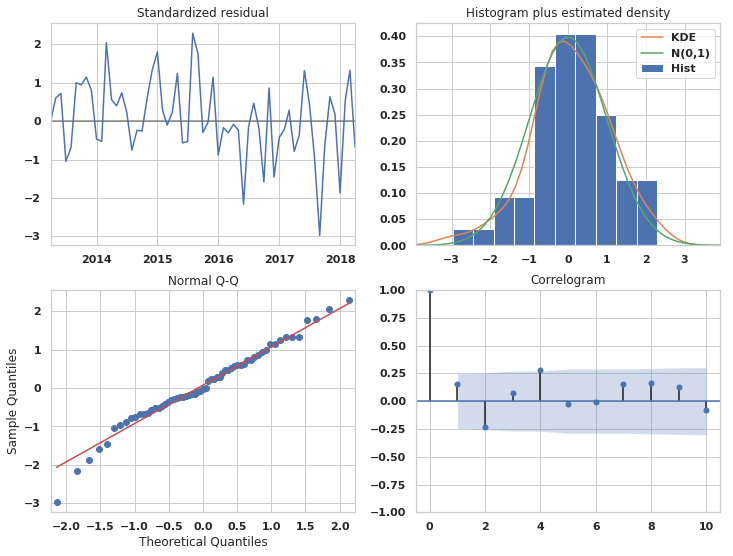

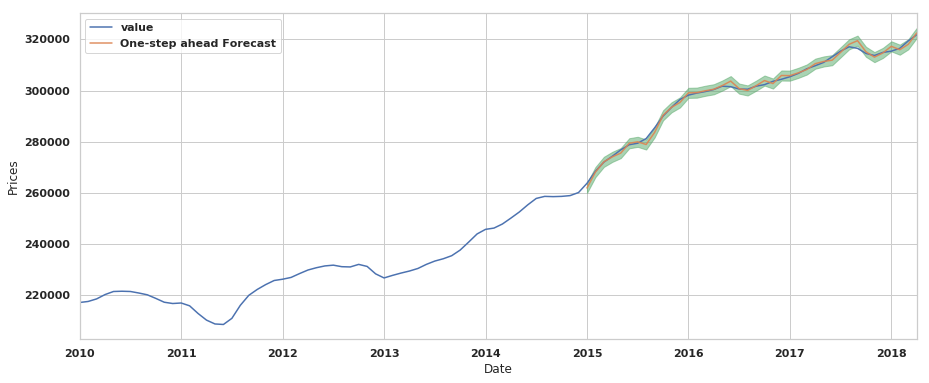

The Mean Squared Error of our forecasts is 1176112.66


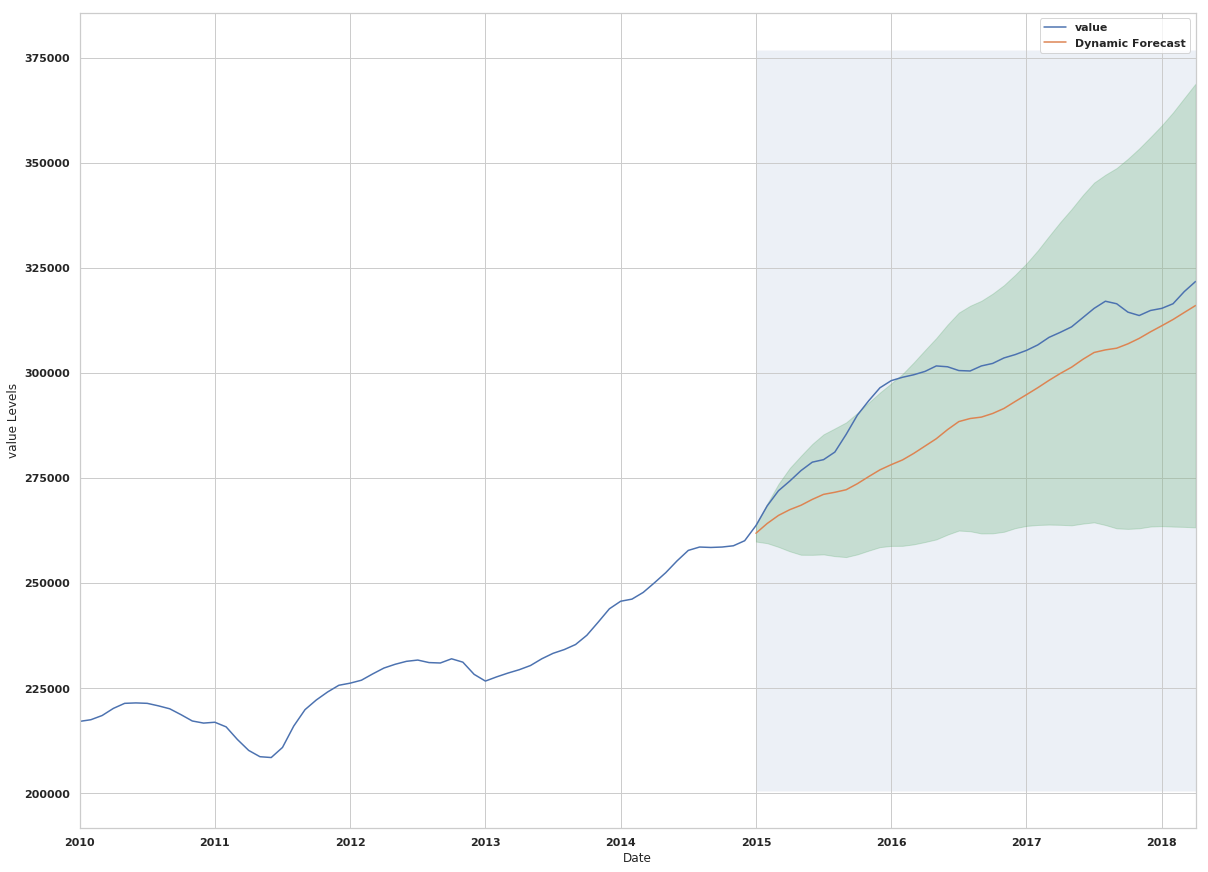

The Mean Squared Error of our forecasts is 138234086.52


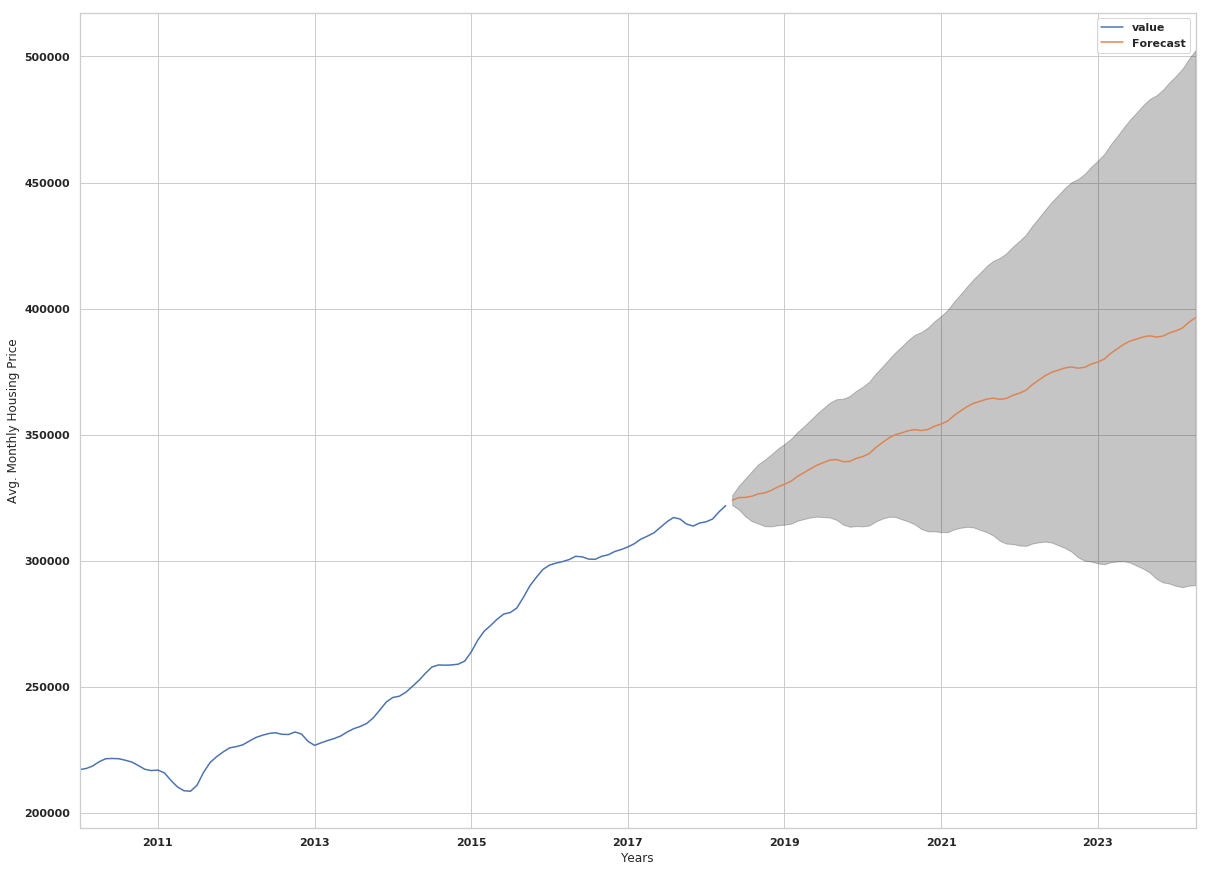

In [128]:
model_selection = [(2,1,0), (2,1,0,12)]

model(current_zip, model_selection[0], model_selection[1])

In [129]:
new_rate(32163, (2,1,0), (2,1,0,12), zcs['zip_32163'])

{'prior_rate': 0.05251994590560243,
 'yr1': 328335.63079428306,
 'yr2': 340648.0623611344,
 'yr3': 353016.26221648045,
 'yr4': 365386.45897025807,
 'yr5': 377745.7238446679,
 'yr6': 390112.30482970184,
 'pred_ar': 0.03508236986162445}

79764

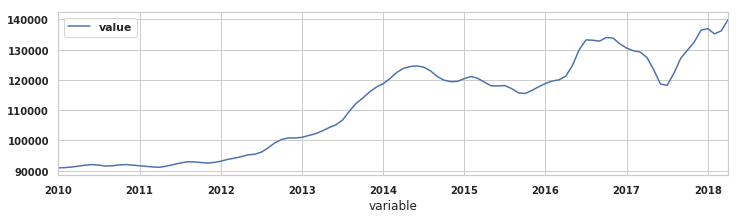

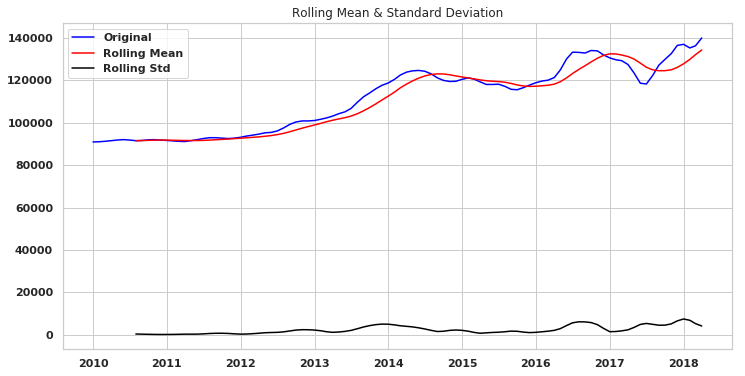

Results of Dickey-Fuller Test:
Test Statistic                 -0.229391
p-value                         0.934926
#Lags Used                      4.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


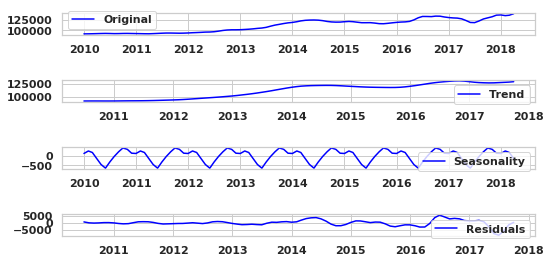

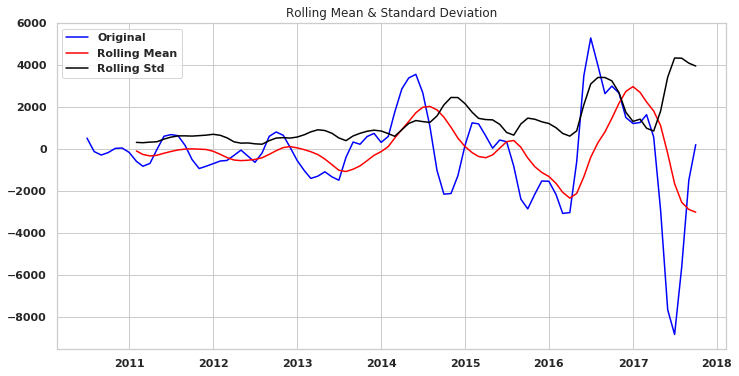

Results of Dickey-Fuller Test:
Test Statistic                 -5.035253
p-value                         0.000019
#Lags Used                      9.000000
Number of Observations Used    78.000000
Critical Value (1%)            -3.517114
Critical Value (5%)            -2.899375
Critical Value (10%)           -2.586955
dtype: float64


In [130]:
current_zip = zcs['zip_79764']

current_zip.plot(figsize=(12,3), linewidth=1.5, fontsize=10);

stationarity_check(current_zip);

decomp(current_zip)

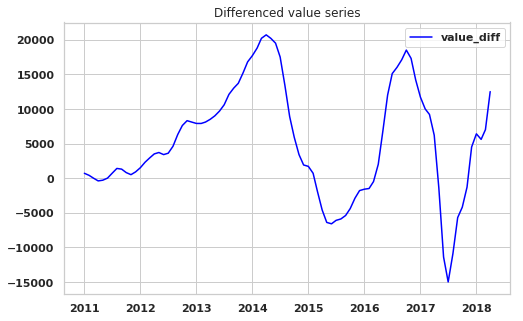

In [131]:
first_diff(current_zip)

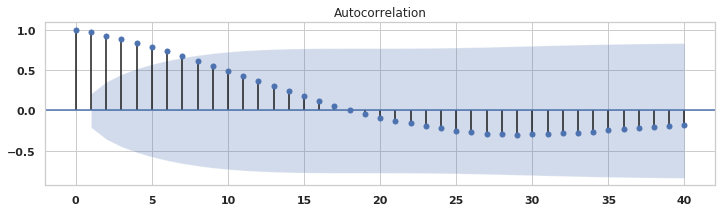

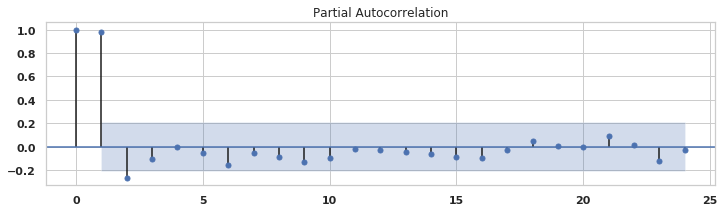

In [132]:
acf_pacf(zip_diff)

In [134]:
models = sarima_configs(2,1,3,2,1,2,12)

trial_models(current_zip)

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =2586.184791517919
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =2227.727834820182
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =1886.0773020982588
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =1844.7308893996506
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =1603.5289304242433
ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =1499.7635197782627
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1840.7471768892135
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1821.7353767954228
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =1533.2542625356327
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =1623.250621952284
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =1586.0052938026279
ARIMA (0, 0, 0) x (1, 1, 2, 12)12 : AIC Calculated =2534.3974678116065
ARIMA (0, 0, 0) x (2, 0, 0, 12)12 : AIC Calculated =1587.1141955167052
ARIMA (0, 0, 0) x (2, 0, 1, 12)12 : AIC Calculated =1588.41130827651
ARIMA (0, 0

ARIMA (0, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =1241.2739692184798
ARIMA (0, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =4896.92212560099
ARIMA (0, 1, 2) x (2, 0, 0, 12)12 : AIC Calculated =1230.6493558846219
ARIMA (0, 1, 2) x (2, 0, 1, 12)12 : AIC Calculated =1231.8671999495514
ARIMA (0, 1, 2) x (2, 0, 2, 12)12 : AIC Calculated =1186.6697148264338
ARIMA (0, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =1076.7745585179273
ARIMA (0, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =1109.9884425714895
ARIMA (0, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =nan
ARIMA (0, 1, 3) x (0, 0, 0, 12)12 : AIC Calculated =1538.1392771476924
ARIMA (0, 1, 3) x (0, 0, 1, 12)12 : AIC Calculated =1350.6457215630985
ARIMA (0, 1, 3) x (0, 0, 2, 12)12 : AIC Calculated =1166.6272918927011
ARIMA (0, 1, 3) x (0, 1, 0, 12)12 : AIC Calculated =1439.0214483577108
ARIMA (0, 1, 3) x (0, 1, 1, 12)12 : AIC Calculated =1200.6585378844125
ARIMA (0, 1, 3) x (0, 1, 2, 12)12 : AIC Calculated =2945.1862223751305
ARIMA (0, 1, 3) x (1, 0

ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =1393.5860627231102
ARIMA (1, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =1204.624525665157
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =1491.4080168921053
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =1260.7828457731205
ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =2402.662160976854
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =1419.010354947531
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =1393.077857349734
ARIMA (1, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =1206.4776360033707
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =1280.493470777224
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =1258.5433615697593
ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =nan
ARIMA (1, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =1225.7840404570766
ARIMA (1, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =1221.284756757319
ARIMA (1, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =1207.5800891799472
ARIMA (1, 1, 1) x (2, 1, 0,

ARIMA (2, 0, 3) x (1, 1, 1, 12)12 : AIC Calculated =1222.673687181531
ARIMA (2, 0, 3) x (1, 1, 2, 12)12 : AIC Calculated =2457.929368077128
ARIMA (2, 0, 3) x (2, 0, 0, 12)12 : AIC Calculated =1214.850505280177
ARIMA (2, 0, 3) x (2, 0, 1, 12)12 : AIC Calculated =1257.8735056580401
ARIMA (2, 0, 3) x (2, 0, 2, 12)12 : AIC Calculated =1211.271921233399
ARIMA (2, 0, 3) x (2, 1, 0, 12)12 : AIC Calculated =1053.11460018374
ARIMA (2, 0, 3) x (2, 1, 1, 12)12 : AIC Calculated =1057.8899682777255
ARIMA (2, 0, 3) x (2, 1, 2, 12)12 : AIC Calculated =2357.5359896467417
ARIMA (2, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =1613.6377858707688
ARIMA (2, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =1439.1050332499992
ARIMA (2, 1, 0) x (0, 0, 2, 12)12 : AIC Calculated =1244.6747576145392
ARIMA (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =1481.3074566131845
ARIMA (2, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =1298.8075206567678
ARIMA (2, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3134.2584710480987
ARIMA (2, 1,

pdq           pdqs          aic
430  (2, 1, 3)  (2, 1, 1, 12)  1035.865955
429  (2, 1, 3)  (2, 1, 0, 12)  1036.210368
412  (2, 1, 2)  (2, 1, 1, 12)  1036.855932
411  (2, 1, 2)  (2, 1, 0, 12)  1037.337694
393  (2, 1, 1)  (2, 1, 0, 12)  1043.086325
394  (2, 1, 1)  (2, 1, 1, 12)  1043.141842
267  (1, 1, 2)  (2, 1, 0, 12)  1051.084266
357  (2, 0, 3)  (2, 1, 0, 12)  1053.114600
268  (1, 1, 2)  (2, 1, 1, 12)  1054.292136
358  (2, 0, 3)  (2, 1, 1, 12)  1057.889968

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8011      0.152      5.261      0.000       0.503       1.100
ar.L2         -0.3616      0.148     -2.442      0.015      -0.652      -0.071
ma.L1          0.6939      0.103      6.716      0.000       0.491       0.896
ar.S.L12      -0.8918      0.192     -4.635      0.000      -1.269      -0.515
ar.S.L24       0.0165      0.125      0.132      0.895      -0.228       0.261
sigma2      1.406e+06   2.92e+05      4.807      0.000    8.33e+05    1.98e+06


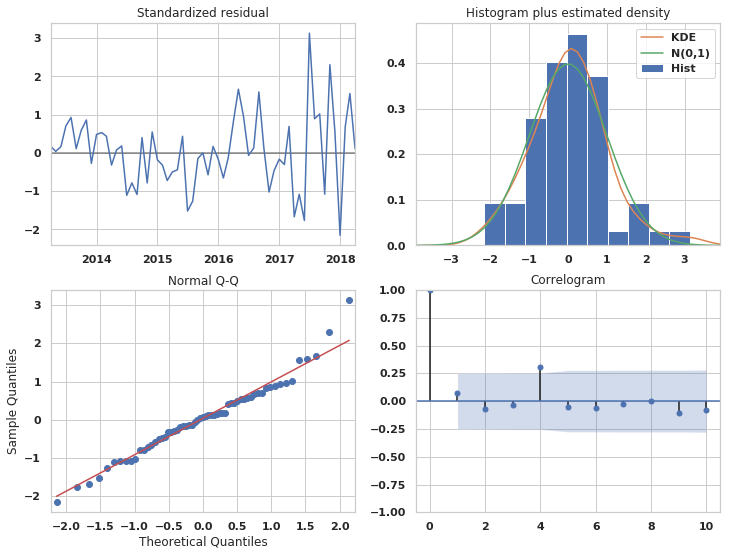

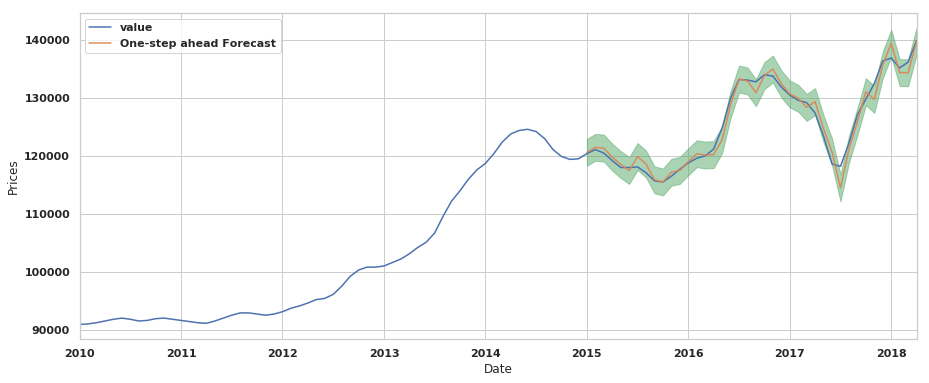

The Mean Squared Error of our forecasts is 1683628.86


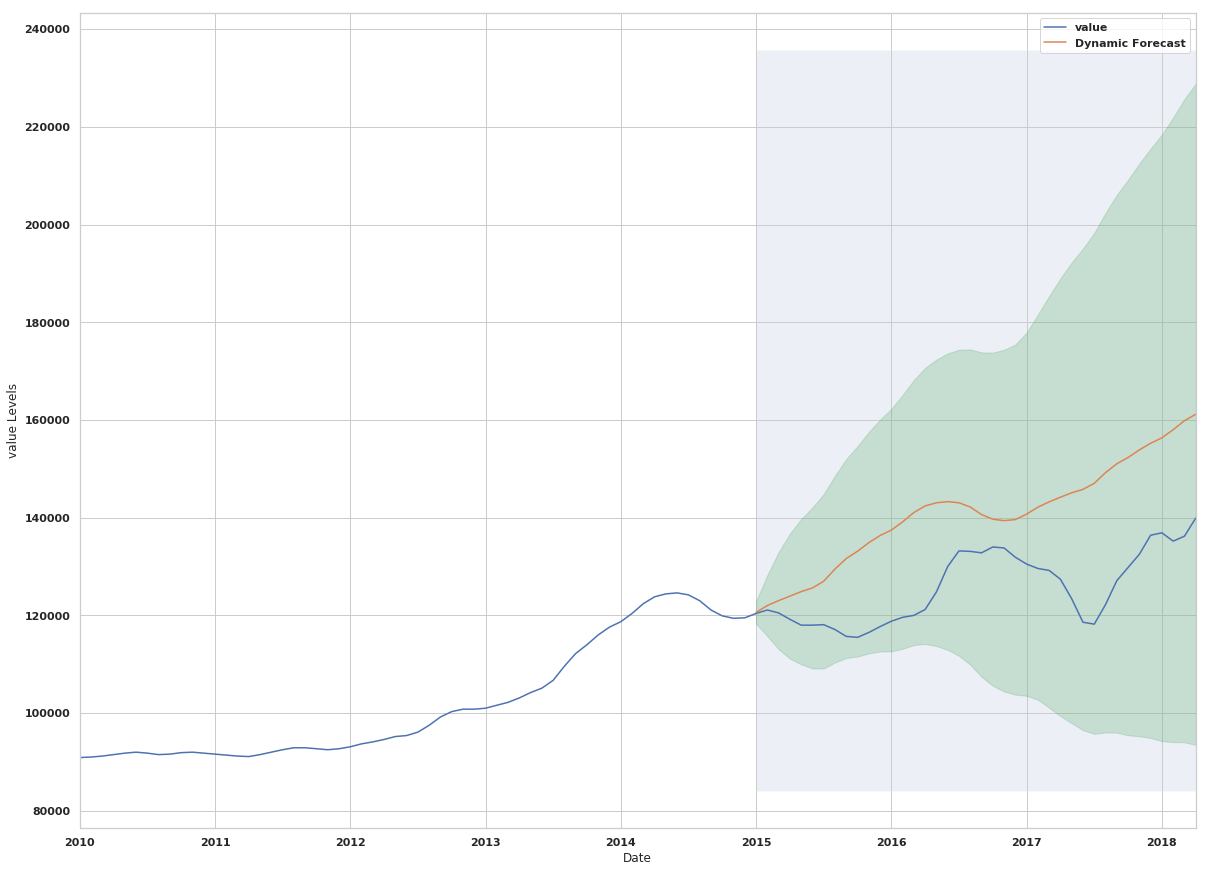

The Mean Squared Error of our forecasts is 285596065.51


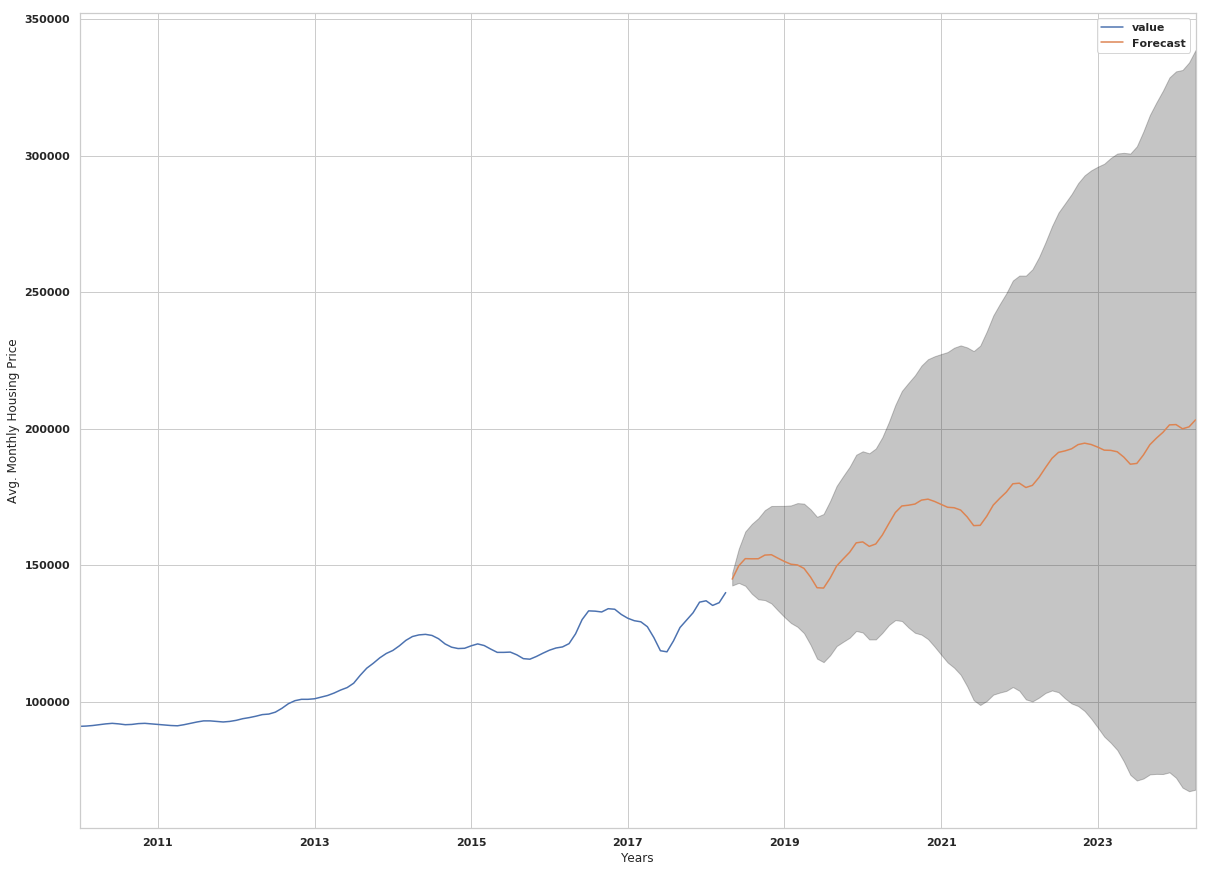

In [136]:
model_selection = [(2,1,1), (2,1,0,12)]

model(current_zip, model_selection[0], model_selection[1])

In [137]:
new_rate(79764, (2,1,1), (2,1,0,12), zcs['zip_79764'])

{'prior_rate': 0.049460861267927425,
 'yr1': 150980.4083374762,
 'yr2': 151891.22280127156,
 'yr3': 171337.7588698519,
 'yr4': 173918.53135285302,
 'yr5': 191845.58348278436,
 'yr6': 195808.94571350794,
 'pred_ar': 0.054572187195805}

# Step 6: Interpreting Results

In [138]:
a = [(84606, (0,1,3), (0,1,1,12), zcs['zip_84606']), (97701, (0,1,4), (0,1,1,12), zcs['zip_97701']), 
     (97756, (2,1,0), (2,1,0,12), zcs['zip_97756']), (97702, (2,1,1), (2,1,0,12), zcs['zip_97702']), 
     (83702, (2,1,1), (2,1,0,12), zcs['zip_83702']), (83705, (2,1,1), (2,1,0,12), zcs['zip_83705']),
     (80631, (2,1,0), (2,1,0,12), zcs['zip_80631']), (80620, (2,1,1), (2,1,0,12), zcs['zip_80620']),
     (32163, (2,1,0), (2,1,0,12), zcs['zip_32163']), (79764, (2,1,1), (2,1,0,12), zcs['zip_79764'])]

future_rates = {}
for i in a:
    future_rates[str(i[0])] = new_rate(i[0], i[1], i[2], i[3])['pred_ar']
    
future_rates
    

{'84606': 0.06721889272358215,
 '97701': 0.0565049783395849,
 '97756': 0.07186253048090294,
 '97702': 0.06616152783093888,
 '83702': 0.08834121210760154,
 '83705': 0.08310628074161029,
 '80631': 0.09246459195413718,
 '80620': 0.08163006769853197,
 '32163': 0.03508236986162445,
 '79764': 0.054572187195805}

In [139]:
x = []
y = []
for key in future_rates:
    x.append(str(key))
    y.append(future_rates[key])

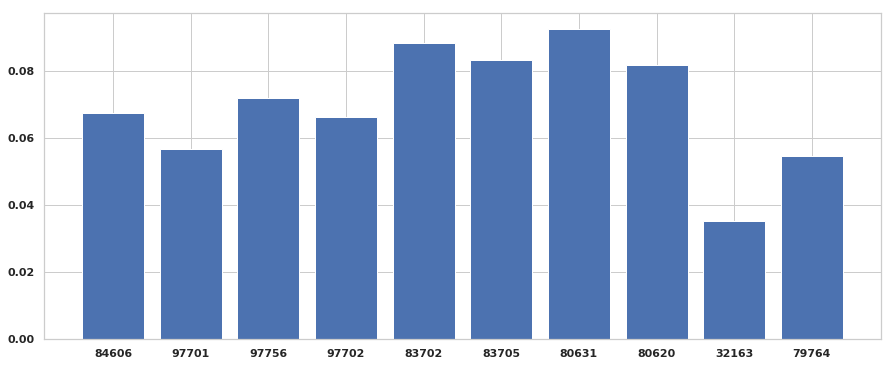

In [140]:
plt.bar(x,y);

In [141]:
returns = data[data['RegionName'].isin(future_rates.keys())]

cols = list(data.columns[7:271])

returns = returns.set_index(['RegionName'])
returns = returns.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 
                        'SizeRank'], axis=1)
returns = returns.drop(cols, axis=1)

fr = pd.DataFrame.from_dict(future_rates, orient='index')
fr.index = fr.index.astype('int64')

returns = returns.join(fr)

years = ['2019', '2020', '2021', '2022', '2023']
returns['2019'] = round(returns['2018-04'] * (1 + returns[0]),2)

for i, yr in enumerate(years[1:], 0):
    returns[yr] = round(returns[years[i]] * (1 + returns[0]),2)
    
for yr in years:
    returns['Rev_' + yr] = round(returns[yr] * 0.10,2)
    
f=[]
for i in returns.columns[-5:]:
    f.append(returns[i])
    returns['total_rev'] = sum(f)
    
returns['avg_ror'] = ((returns['total_rev']) / returns['2018-04']) / 5
returns['roi'] = (returns['2023'] - returns['2018-04']) / returns['2018-04']
    
returns

2018-04         0       2019       2020       2021       2022  \
RegionName                                                                  
97702        411100  0.066162  438299.00  467297.53  498214.65  531177.29   
80631        228600  0.092465  249737.41  272829.28  298056.33  325615.99   
97756        281200  0.071863  301407.74  323067.66  346284.12  371168.97   
97701        340200  0.056505  359422.99  379732.18  401188.94  423858.11   
32163        321800  0.035082  333089.51  344775.08  356870.61  369390.48   
83705        211800  0.083106  229401.91  248466.65  269115.79  291481.00   
83702        441000  0.088341  479958.47  522358.58  568504.37  618726.74   
84606        258700  0.067219  276089.53  294647.96  314453.87  335591.11   
79764        139900  0.054572  147534.65  155585.94  164076.61  173030.63   
80620        260600  0.081630  281872.80  304882.10  329769.65  356688.77   

                 2023  Rev_2019  Rev_2020  Rev_2021  Rev_2022  Rev_2023  \
RegionName                                                                
97702       566320.79  43829.90  46729.75  49821.46  53117.73  56632.08   
80631       355723.94  24973.74  27282.93  29805.63  32561.60  35572.39   
97756       397842.11  30140.77  32306.77  34628.41  37116.90  39784.21   
97701       447808.20  35942.30  37973.22  40118.89  42385.81  44780.82   
32163       382349.57  33308.95  34477.51  35687.06  36939.05  38234.96   
83705       315704.90  22940.19  24846.66  26911.58  29148.10  31570.49   
83702       673385.81  47995.85  52235.86  56850.44  61872.67  67338.58   
84606       358149.17  27608.95  29464.80  31445.39  33559.11  35814.92   
79764       182473.29  14753.46  15558.59  16407.66  17303.06  18247.33   
80620       385805.30  28187.28  30488.21  32976.97  35668.88  38580.53   

            total_rev   avg_ror       roi  
RegionName                                 
97702       250130.92  0.121689  0.377574  
80631       150196.29  0.131405  0.556098  
97756       173977.06  0.123739  0.414801  
97701       201201.04  0.118284  0.316309  
32163       178647.53  0.111030  0.188159  
83705       135417.02  0.127873  0.490580  
83702       286293.40  0.129838  0.526952  
84606       157893.17  0.122067  0.384419  
79764        82270.10  0.117613  0.304312  
80620       165901.87  0.127323  0.480450

In the five selected zip codes, the predicted average annual market growth will yield average ROI between 12.3 - 13.1%, which exceeds the market aim of 6-12%. Purchasing in cash will allow for an additional 41 - 56% return on the initial investment upon the successful sale of the asset at the 5 year mark.

In [142]:
returns = returns.sort_values('roi', ascending=False)

In [143]:
returns.head()

2018-04         0       2019       2020       2021       2022  \
RegionName                                                                  
80631        228600  0.092465  249737.41  272829.28  298056.33  325615.99   
83702        441000  0.088341  479958.47  522358.58  568504.37  618726.74   
83705        211800  0.083106  229401.91  248466.65  269115.79  291481.00   
80620        260600  0.081630  281872.80  304882.10  329769.65  356688.77   
97756        281200  0.071863  301407.74  323067.66  346284.12  371168.97   

                 2023  Rev_2019  Rev_2020  Rev_2021  Rev_2022  Rev_2023  \
RegionName                                                                
80631       355723.94  24973.74  27282.93  29805.63  32561.60  35572.39   
83702       673385.81  47995.85  52235.86  56850.44  61872.67  67338.58   
83705       315704.90  22940.19  24846.66  26911.58  29148.10  31570.49   
80620       385805.30  28187.28  30488.21  32976.97  35668.88  38580.53   
97756       397842.11  30140.77  32306.77  34628.41  37116.90  39784.21   

            total_rev   avg_ror       roi  
RegionName                                 
80631       150196.29  0.131405  0.556098  
83702       286293.40  0.129838  0.526952  
83705       135417.02  0.127873  0.490580  
80620       165901.87  0.127323  0.480450  
97756       173977.06  0.123739  0.414801

In [144]:
y = []
for i in returns.roi:
    y.append(i)
    
y = y[:5]

In [145]:
x = []
for i in returns.index:
    x.append(str(i))
    
x = x[:5]

In [153]:
roi = {'reference': 1}
for j, i in enumerate(y,0):
    roi[x[j]] = i
    
roi

{'reference': 1,
 '80631': 0.5560977252843394,
 '83702': 0.5269519501133788,
 '83705': 0.49058026440037783,
 '80620': 0.4804501151189562,
 '97756': 0.4148012446657183}

In [154]:
x = []
y = []
for key in roi:
    x.append(key)
    y.append(roi[key])

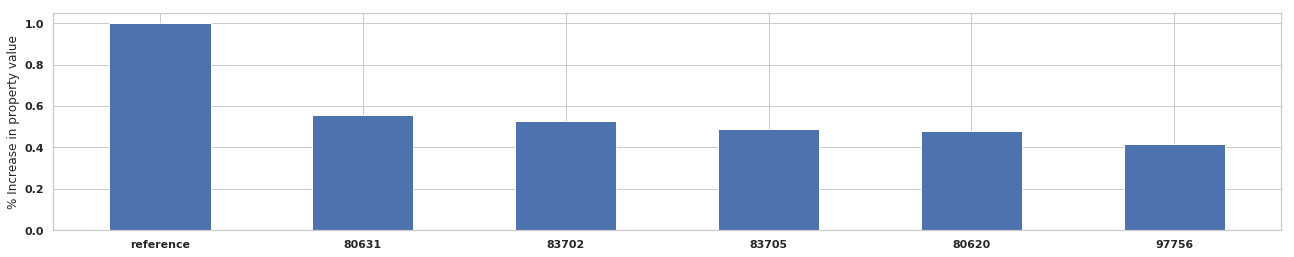

In [155]:
plt.figure(figsize=(22,4))
plt.ylabel('% Increase in property value')
plt.bar(x,y, width=0.5);

In [156]:
e = pd.read_excel('ZipLatLng.xlsx')
e['Zip'], e['Lat'], e['Long'] = e['ZIP,LAT,LNG'].str.split(',',2).str
del e['ZIP,LAT,LNG']

e['Zip'] = e['Zip'].astype(str)
e['Lat'] = e['Lat'].astype(float)
e['Long'] = e['Long'].astype(float)

e = e.append({'Zip': '32163', 'Lat': 28.8591, 'Long': -81.9698}, ignore_index=True)

In [157]:
u = []
for i in data['RegionName']:
    u.append(str(i))

locs = e[e['Zip'].isin(u)]

In [158]:
#Provo-Orem UT
provooremUT = ['84097', '84601', '84604', '84606', '84663', '84057', '84058']

#Bend-Redmond OR
bendOR = ['97701', '97702', '97703', '97756']

#Boise City, ID
boiseID = ['83702', '83703', '83704', '83705', '83706', '83709', '83712', 
           '83713', '83714', '83716']

#Greeley, CO
greeleyCO = ['80543', '80550', '80620', '80631', '80634']

#The Villages, FL
villagesFL = ['32159', '32162', '32163', '34484', '34731', '34785']

#Midlane - Odessa, TX
midlandTX = ['79761', '79762', '79763', '79764', '79765', '79766']

zc = [provooremUT, bendOR, boiseID, greeleyCO, villagesFL, midlandTX]

In [159]:
u = e[e['Zip'].isin(boiseID)]
m = folium.Map(location=[u.Lat.mean(), u.Long.mean()], zoom_start=11)
for j in u.index:
    folium.Marker(location=[u.loc[j]['Lat'], u.loc[j]['Long']], tooltip=str(u.loc[j]['Zip'])).add_to(m)
    folium.Marker(location=[u.loc[28715]['Lat'], u.loc[28715]['Long']], tooltip=str(u.loc[28715]['Zip']),icon=folium.Icon(color='green')).add_to(m)
    folium.Marker(location=[u.loc[28718]['Lat'], u.loc[28718]['Long']], tooltip=str(u.loc[28718]['Zip']),icon=folium.Icon(color='green')).add_to(m)

m

In [160]:
u = e[e['Zip'].isin(greeleyCO)]
m = folium.Map(location=[u.Lat.mean(), u.Long.mean()], zoom_start=11)
for j in u.index:
    folium.Marker(location=[u.loc[j]['Lat'], u.loc[j]['Long']], tooltip=str(u.loc[j]['Zip'])).add_to(m)
    folium.Marker(location=[u.loc[28013]['Lat'], u.loc[28013]['Long']], tooltip=str(u.loc[28013]['Zip']),icon=folium.Icon(color='green')).add_to(m)
    folium.Marker(location=[u.loc[28018]['Lat'], u.loc[28018]['Long']], tooltip=str(u.loc[28018]['Zip']),icon=folium.Icon(color='green')).add_to(m)

m

In [161]:
u = e[e['Zip'].isin(bendOR)]
m = folium.Map(location=[u.Lat.mean(), u.Long.mean()], zoom_start=10)
for j in u.index:
    folium.Marker(location=[u.loc[j]['Lat'], u.loc[j]['Long']], tooltip=str(u.loc[j]['Zip'])).add_to(m)
    folium.Marker(location=[u.loc[32236]['Lat'], u.loc[32236]['Long']], tooltip=str(u.loc[32236]['Zip']),icon=folium.Icon(color='green')).add_to(m)

m

In [162]:
g = [i for i in future_rates.keys()]
f = e[e['Zip'].isin(g)]

In [163]:
m = folium.Map(location=[38, -101], zoom_start=4.5)

k = ['red', 'blue', 'green', 'purple', 'orange', 'darkblue', 'beige', 'pink', 
     'black', 'lightgray']

marker_cluster = MarkerCluster().add_to(m)

for j, i in enumerate(f.index):
    c = k[j]
    folium.Marker(location=[f.loc[i]['Lat'], f.loc[i]['Long']], 
                  tooltip=str(f.loc[i]['Zip'])+'\n - \n'+str(round(future_rates[f.loc[i]['Zip']]*100,2))+'%', 
                  icon=folium.Icon(color=c)).add_to(marker_cluster)
m

## Conclusion

From the 7 preselected cities, I modeled out 10 zip codes. Based on the model predictions, I was able to calculate a return on investment for the properties if they were purchased today and sold in 5 years time. Based on that criteria, I selected the five zip codes that would show the greatest growth in property value over five years. It was also important to find the average monthly ROI, as these are expected to be rental properties.